In [1]:
import os
import json
import glob
import lzma
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib import colors

import operator
from functools import reduce
from itertools import product
from scipy.ndimage import measurements

import tensorflow as tf

SEED = 420

LOG_DIR = os.path.join('../models', 'train_log')
DATA_DIR = '../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'training')
EVAL_DIR = os.path.join(DATA_DIR, 'evaluation')
TEST_DIR = os.path.join(DATA_DIR, 'test')

df_sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))

train_ids = [fn.split('.json')[0] for fn in os.listdir(TRAIN_DIR)]
eval_ids = [fn.split('.json')[0] for fn in os.listdir(EVAL_DIR)]
test_ids = [fn.split('.json')[0] for fn in os.listdir(TEST_DIR)]
eval_ids = list(set(eval_ids).difference(test_ids))

train_filepaths = glob.glob(TRAIN_DIR + '/*')
eval_filepaths = glob.glob(EVAL_DIR + '/*')
test_filepaths = glob.glob(TEST_DIR + '/*')

id_to_filepath = {}

for task_id in train_ids:
    id_to_filepath[task_id] = os.path.join(TRAIN_DIR, f'{task_id}.json')
for task_id in eval_ids:
    id_to_filepath[task_id] = os.path.join(EVAL_DIR, f'{task_id}.json')

In [2]:
def load_task(filepath, verbose=0):
    if verbose:
        task_id = filepath.split('/')[-1].split('.json')[0]
        group = filepath.split('/' + task_id)[0].split('/')[-1]
        print(f"Loading {group} task {task_id}")
    with open(filepath, 'r') as f:
        task = json.load(f)
    return task

def load_task_from_id(task_id):
    task_filename = f'{task_id}.json'
    task_filepath = None
    for root in [TRAIN_DIR, EVAL_DIR, TEST_DIR]:
        if task_filename in os.listdir(root):
            task_filepath = os.path.join(root, task_filename)
    if task_filepath is None:
        raise ValueError(f'`task_id` {task_id} not found.')
    return load_task(task_filepath)

def strip_task(filepath):
    return filepath.split('/')[-1].split('.json')[0]
        

def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def unflattener(str_pred):
    pred = []
    for row in str_pred.strip('|').split('|'):
        pred.append([int(row[i]) for i in range(len(row))])
    return np.array(pred, dtype=np.uint8)

# https://github.com/fchollet/ARC/blob/master/apps/css/common.css
COLORS = [
    '#000000',
    '#0074D9',
    '#FF4136',
    '#2ECC40',
    '#FFDC00',
    '#AAAAAA',
    '#F012BE',
    '#FF851B',
    '#7FDBFF',
    '#870C25',
]

idx_to_color = {
    0: 'black',
    1: 'blue',
    2: 'red',
    3: 'green',
    4: 'yellow',
    5: 'grey',
    6: 'pink',
    7: 'orange',
    8: 'light blue',
    9: 'brown',
}

color_to_idx = {v: k for k, v in idx_to_color.items()}

idx_to_hex = {
    0: '#000000',
    1: '#0074D9',
    2: '#FF4136',
    3: '#2ECC40',
    4: '#FFDC00',
    5: '#AAAAAA',
    6: '#F012BE',
    7: '#FF851B',
    8: '#7FDBFF',
    9: '#870C25',
}

cmap = colors.ListedColormap(COLORS)
norm = colors.Normalize(vmin=0, vmax=9)
grid_params = {
    'cmap': cmap,
    'norm': norm
}

def generate_idx_to_rgb(hex_list):
    idx_to_rgb = {}
    for i, color in enumerate(hex_list):
        h = color.strip('#')
        rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
        idx_to_rgb[i] = rgb
    return idx_to_rgb

idx_to_rgb = generate_idx_to_rgb(COLORS)

In [159]:
################################################################################
# plot functions
################################################################################

def plot_grid(x, ax=None, title=None, **kwargs):
    kwargs = dict(grid_params, **kwargs)
    x = np.asarray(x)
    
    ax = ax or plt.axes()
    ax.imshow(x, **kwargs)
    
    ax.set_title(title, size=16)
    ax.set_xticks(list(range(x.shape[1])))
    ax.set_yticks(list(range(x.shape[0])))
    [ax.axvline(i+0.5, c='#555', lw=.75) for i in range(x.shape[1])]
    [ax.axhline(i+0.5, c='#555', lw=.75) for i in range(x.shape[0])]
    
    
def plot_grids(x, ch_to_symbols=None, mask_th=0):
    n = len(x)
    fig, ax = plt.subplots(1, n, figsize=(n*5, n*4))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax if isinstance(ax, np.ndarray) else [ax]
    for i in range(n):
        x_grid = x[i]
        if ch_to_symbols is not None:
            x_grid = channel_to_grid(x_grid, ch_to_symbols[i], mask_th)
        plot_grid(x_grid, ax=ax[i])
    
    plt.show();
    
    
def plot_gradient(x, ax=None):
    ax = ax or plt.axes()
    p = ax.imshow(x)
    plt.colorbar(p, ax=ax)
    ax.set_xticks(list(range(x.shape[1])))
    ax.set_yticks(list(range(x.shape[0])))
    [ax.axvline(i+0.5, c='#555', lw=.5) for i in range(x.shape[1])]
    [ax.axhline(i+0.5, c='#555', lw=.5) for i in range(x.shape[0])];

    
def plot_task(task, pred_fn=None, task_id=None, **kwargs):
    """Plots the train and test input & outputs for a `task`."""
    num_train = len(task['train'])
    num_test = len(task['test'])
    num_rows = 3 if pred_fn else 2
    N = num_train + num_test
    
    fig, ax = plt.subplots(num_rows, 
                           N, 
                           figsize=(6 * N, 12), 
                           dpi=50)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    if task_id is not None:
        print(task_id)
    
    for i in range(num_train):
        x_grid = np.array(task['train'][i]['input'])
        y_grid = np.array(task['train'][i]['output'])

        plot_grid(x_grid, ax[0][i], title=f'train_{i} in', **kwargs)
        plot_grid(y_grid, ax[1][i], title=f'train_{i} out', **kwargs)
        
        if pred_fn is not None:
            y_pred = pred_fn(x_grid)
            plot_grid(y_pred, ax[2][i], title=f'train_{i} pred', **kwargs)
        
    for i in range(num_test):
        x_grid = np.array(task['test'][i]['input'])
        plot_grid(x_grid, ax[0][num_train+i], title=f'test_{i} in', **kwargs)
        
        if task['test'][i].get('output'):
            y_grid = np.array(task['test'][i]['output'])
            plot_grid(y_grid, ax[1][num_train+i], title=f'test_{i} out', **kwargs)
        
        if pred_fn is not None:
            y_pred = pred_fn(x_grid)
            plot_grid(y_pred, ax[2][num_train+i], title=f'test_{i} pred', **kwargs)
        
    plt.show()
    
    
def get_input_output(samples):
    x_grids = []
    y_grids = []
    for i in range(len(samples)):
        x_grids.append(np.array(samples[i]['input']))
        if samples[i].get('output'):
            y_grids.append(np.array(samples[i]['output']))
        
    return x_grids, y_grids

def score_task(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
#     if y_true.shape != y_pred.shape:
#         raise ValueError("Output and prediction shapes don't match. "
#                         f"Expected {y_true.shape}, got {y_pred.shape}")
    
    score = np.sum(y_true == y_pred) / y_pred.size
    return score


def score_tasks(y_true, y_pred):
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_pred, list):
        y_pred = [y_pred]
    return np.mean([score_task(y_true[i], y_pred[i]) for i in range(len(y_true))])


def solve_task_symbolic(task, solve_fn, plot_task=True, **kwargs):
    train_samples = task['train']
    test_samples = task['test']

    num_train = len(train_samples)
    num_test = len(test_samples)
    N = num_train + num_test
    
    if plot_task:
        fig, ax = plt.subplots(3, 
                               N, 
                               figsize=(6 * N, 12), 
                               dpi=50)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)

    is_scores = []
    oos_scores = []
    oos_preds = []

    for i in range(num_train):
        x_train = train_samples[i]['input']
        y_train = train_samples[i]['output']
        y_pred = solve_fn(x_train)
        is_scores.append(score_task(y_train, y_pred))
        
        if plot_task:
            plot_grid(x_train, ax[0][i], title=f'train_{i} in', **kwargs)
            plot_grid(y_train, ax[1][i], title=f'train_{i} out', **kwargs)
            plot_grid(y_pred, ax[2][i], title=f'train_{i} pred', **kwargs)
    
    for i in range(num_test):
        x_test = test_samples[i]['input']
        y_pred = solve_fn(x_test)
        
        if plot_task:
            plot_grid(x_test, ax[0][num_train+i], title=f'test_{i} in', **kwargs)
            plot_grid(y_pred, ax[2][num_train+i], title=f'test_{i} pred', **kwargs)

        if test_samples[i].get('output'):
            y_test = test_samples[i]['output']
            oos_scores.append(score_task(y_test, y_pred))
            if plot_task:
                plot_grid(y_test, ax[1][num_train+i], title=f'test_{i} out', **kwargs)

        oos_preds.append(y_pred)
        
    
    print(f'IS acc  : {np.mean(is_scores):.4f}')
    if len(oos_scores) > 0:
        print(f'OOS acc : {np.mean(oos_scores):.4f}')
    
    return np.array(oos_preds)

In [245]:
channel_to_grid(x[0], ch_to_symbols[0], .1)

(array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

In [4]:
# dataframe utils
def display_row(s):
    if len(s) == 1 & isinstance(s, pd.DataFrame):
        s = s.iloc[0]
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(s)

def loc_all(conditions):
    return reduce(operator.and_, conditions, True)

def loc_any(conditions):
    return reduce(operator.or_, conditions, True)

def subset_df(df, conditions, how='all'):
    if how == 'any':
        return df.loc[loc_any(conditions(df))]
    else:
        return df.loc[loc_all(conditions(df))]

# non essential functions
def compute_objs(x, background_color=None):
    x = np.asarray(x)
    if background_color:
        _x = np.ravel(x[0]).tolist()
        background_color = max(set(_x), key=_x.count)
    else:
        background_color = 0
    return measurements.label(x != background_color)[1]

def compute_freq(x, value):
    return np.ravel(x).tolist().count(value)

def compute_most_freq(x):
    _x = np.ravel(x).tolist()
    return max(set(_x), key=_x.count)
    
def compute_objectness(x):
    x = np.asarray(x)
    bkgr_color = compute_most_freq(x)
    num_bkgr_color = compute_freq(x, bkgr_color)
    num_objs = measurements.label(x != bkgr_color)[1]
    return num_objs, bkgr_color, num_bkgr_color


In [5]:
################################################################################

# geometric functions (objects)

################################################################################

def identity(x):
    return x

def transpose(x):
    h, w = x.shape
    y = np.zeros((w, h), dtype=np.uint8)

    for i in range(w):
        for j in range(h):
            y[i][j] = x[j][i]
    return y

def rot90(x):
    n, m = x.shape
    return np.array([[x[n-1-i,j] for i in range(n)] for j in range(m)])

def flip_x(x):
    n, m = x.shape
    return np.array([[x[i,m-1-j] for j in range(m)] for i in range(n)])

def flip_y(x):
    _x = x.T
    n, m = _x.shape
    return np.array([[_x[i,m-1-j] for j in range(m)] for i in range(n)]).T

def flip_xy(x):
    return flip_y(flip_x(x))


################################################################################

# algorithmic complexity functions

################################################################################

COMPRESSION_METHODS = [
    'lzma',
#     'gzip',
#     'zlib',
#     'bz2'
]

METHOD_TO_BOUND = {
    'lzma': 60,
    'gzip': 21,
    'zlib': 9,
    'bz2': 37
}


def compute_complexity(x, method='lzma'):
    if method not in COMPRESSION_METHODS:
        raise(f'Unrecognized method {method}')
    bound = METHOD_TO_BOUND.get(method, 0)
    
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(x, list):
        x = flattener(x)
    
    bytes_in = x.encode('utf-8')
    num_bytes_out = len(eval(method).compress(bytes_in)) - bound
    return num_bytes_out, num_bytes_out / len(bytes_in)


# state functions
from numpy.lib.stride_tricks import as_strided

def tile_array(x, h_factor, w_factor):
    h, w = x.shape
    hs, ws = x.strides
    x_up = as_strided(x, (h, h_factor, w, w_factor), (hs, 0, ws, 0))
    return x_up.reshape(h * h_factor, w * w_factor)


def copy_state(x):
    return x.copy()


################################################################################

# object functions 

################################################################################

def compute_object_matrix(x, background_color=0):
    num_labels = 0
    object_matrix = np.zeros_like(x, dtype=np.uint8)
    values = [v for v in set(np.unique(x)) if v != background_color]
    
    for v in values:
        matrix, n = measurements.label(x == v)
        matrix[matrix != 0] += num_labels
        object_matrix = object_matrix + matrix
        num_labels += n
    
    return object_matrix

def get_objects(x, f=None, background_color=0):
    """Returns a list of object coordinates, colors, and shapes.
    
    Applies a function THEN saves off the indices, meta data, etc
    """
    x = np.asarray(x)
    if f is not None:
        x = f(x)
    x_1d = np.ravel(x).tolist()
    
    obj_matrix = compute_object_matrix(x, background_color)
    labels = np.unique(obj_matrix)[1:]
    
    if len(labels) > 0:
        # construct object with coordinates, colors, and shape
        objs = []
        for label in labels:
            coords = np.array(list(zip(*np.where(obj_matrix == label))), dtype=np.uint8)
            symbols = x[tuple(zip(*coords))]
            shape = np.ptp(coords, axis=0) + 1
            objs.append(Object(symbols, coords, shape))
    else:
        objs = [identity_object(x)]
        
    return objs


def identity_object(x):
    x = np.asarray(x)
    n, m = x.shape
    coords = np.array(list(product(range(n), range(m))), dtype=np.uint8)
    values = x.ravel()
    shape = np.array([n,m], dtype=np.uint8)
    return Object(symbols, coords, shape)


def plot_object(values, coordinates, shape):
    """Plots an object."""
    xy = coordinates - coordinates.min(axis=0)
    obj = np.zeros(shape, dtype=np.uint8)
    obj[tuple(zip(*xy))] = values
    plot_grid(obj)
    
    
################################################################################

# state functions

################################################################################

from numpy.lib.stride_tricks import as_strided

def tile_array(x, h_factor, w_factor):
    h, w = x.shape
    hs, ws = x.strides
    x_up = as_strided(x, (h, h_factor, w, w_factor), (hs, 0, ws, 0))
    return x_up.reshape(h * h_factor, w * w_factor)


def project_to_2d(w, indices):
    indices = np.asarray(indices, dtype=int)
    output_x = indices // w
    output_y = indices % w
    return output_x, output_y


def project_to_1d(w, coordinates):
    """Returns indices on a 1D vector that correspond to the 2D `coordinates`."""
    coordinates = np.asarray(coordinates, dtype=np.uint8)
    indices = coordinates[:,1] % w + (coordinates[:,0] * w)
    return indices


def matched_filter(x_input, obj, coordinates, shape):
    """Slides a filter (object) across a state and checks for matches."""
    x_input = np.asarray(x_input)
    x_input_1d = x_input.ravel()

    input_h, input_w = x_input.shape
    strided_h = output_h - shape[0] + 1
    strided_w = output_w - shape[1] + 1

    coordinates_scaled = coordinates - coordinates.min(axis=0)
    indices = project_to_1d(output_w, coordinates_scaled)
    matches = []

    # slide the object across every possible region and check for matches
    for i in range(strided_h):
        for j in range(strided_w):
            strided_indices = indices + j + i * output_w
            if all(x_input_1d[strided_indices] == obj):
                matches.append([tuple(map(tuple, coordinates)), tuple(strided_indices)])
    
    return matches


# def get_background_color(x_grids):
#     x_flat = list(map(np.ravel, x_grids))
#     values_inter = reduce(set.intersection, map(set, x_flat))
#     if len(values_inter) == 0:
#         return 0
#     elif len(values_inter) == 1:
#         return list(values_inter)[0]
#     else:
#         return max(values_inter, key=[v for x in x_flat for v in x].count)
    
def get_background_color(x, y):
    if 0 in x or 0 in y:
        return 0
    # compute ratio of color to number of objects with color
    xy = np.concatenate((np.ravel(x), np.ravel(y))).tolist()
    return max(xy, key=xy.count)


################################################################################

# core utils 

################################################################################

def intersection(*args):
    """Returns a list of all intersection values in a nested list."""
    tmp = []
    for iterable in args:
        if not isinstance(iterable, set):
            tmp.append(list(map(tuple, iterable)))
        else:
            tmp.append(iterable)
    return reduce(set.intersection, tmp)
#     return list(set.intersection(*map(set, tmp))) 

def union(*args):
    tmp = []
    for iterable in args:
        if not isinstance(iterable, set):
            tmp.append(list(map(tuple, iterable)))
        else:
            tmp.append(iterable)
    return reduce(set.union, tmp)

def diff(*args):
    tmp = []
    for iterable in args:
        if not isinstance(iterable, set):
            tmp.append(list(map(tuple, iterable)))
        else:
            tmp.append(iterable)
    return reduce(set.difference, tmp)

def sample_coordinate(n, m, random_state=None):
    if random_state:
        return (random_state.choice(range(n)), random_state.choice(range(m)))
    else:
        return (np.random.choice(range(n)), np.random.choice(range(m)))

    
# random utils

from tensorflow_core.python.framework.convert_to_constants import convert_variables_to_constants_v2
from google.protobuf.json_format import MessageToDict

def save_model(model, filename, sched=None, **params):
    """Saves model weights and configurations to disk.
    
    Parameters
    ----------
    model : tf.keras.Model
        Model.
    filename : str
        Output path to save model configurations.
    """
    if len(params) > 0:
        tensor_params = {k: tf.constant(v.value) for k, v in params.items()}
    else:
        tensor_params = {}
    model.save_weights(filename)

    concrete_fn = model.call.get_concrete_function(
        x=tf.TensorSpec([None, None, None, model.num_channels]), 
        **tensor_params)
    concrete_fn = convert_variables_to_constants_v2(concrete_fn)
    graph_def = concrete_fn.graph.as_graph_def()
    graph_json = MessageToDict(graph_def)
    model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
    }
    
    with open(f'{filename}.json', 'w') as f:
        json.dump(model_json, f)
        
        
def cleanup(min_files=1):
    ckpt_dirs = os.listdir(LOG_DIR)
    for filename in ckpt_dirs:
        filepath = os.path.join(LOG_DIR, filename)
        if len(os.listdir(filepath)) < min_files:
            os.rmdir(filepath)
            

In [6]:
import gzip
import lzma
import zlib
import bz2


def generate_df_meta(task_filepaths):
    """Generates a dataframe of algorithmic complexity scores for each task."""
    df_meta = pd.DataFrame()

    for i, filepath in enumerate(task_filepaths):
        task_id = strip_task(filepath)
        task = load_task(filepath)
        x_train, y_train = get_input_output(task['train'])
        x_test, y_test = get_input_output(task['test'])

        data = {
            'task_id': [task_id],
            'filepath': [filepath],
            'num_train_samples': len(x_train),
            'num_test_samples': len(x_test)
        }
        
        # shape
        train_inp_shape = np.array([x.shape for x in x_train])
        train_out_shape = np.array([x.shape for x in y_train])
        test_inp_shape = np.array([x.shape for x in x_test])
        
        data['train_input_shape_w_uq'] = len(np.unique(train_inp_shape[:,0]))
        data['train_input_shape_w_mode'] = compute_most_freq(train_inp_shape[:,0])
        data['train_input_shape_h_uq'] = len(np.unique(train_inp_shape[:,1]))
        data['train_input_shape_h_mode'] = compute_most_freq(train_inp_shape[:,1])
        data['train_output_shape_w_uq'] = len(np.unique(train_out_shape[:,0]))
        data['train_output_shape_w_mode'] = compute_most_freq(train_out_shape[:,0])
        data['train_output_shape_h_uq'] = len(np.unique(train_out_shape[:,1]))
        data['train_output_shape_h_mode'] = compute_most_freq(train_out_shape[:,1])
        
        train_shape_delta = train_inp_shape - train_out_shape
        data['train_shape_delta_w_mean'] = train_shape_delta[:,0].mean()
        data['train_shape_delta_h_mean'] = train_shape_delta[:,1].mean()
        
        data['test_input_shape_w_uq'] = len(np.unique(test_inp_shape[:,0]))
        data['test_input_shape_w_mode'] = compute_most_freq(test_inp_shape[:,0])
        data['test_input_shape_h_uq'] = len(np.unique(test_inp_shape[:,1]))
        data['test_input_shape_h_mode'] = compute_most_freq(test_inp_shape[:,1])
        
        # objectness
        train_inp_objs = np.array([compute_objectness(x) for x in x_train])
        train_out_objs = np.array([compute_objectness(x) for x in y_train])
        test_inp_objs = np.array([compute_objectness(x) for x in x_test])
        
        data['train_input_bkgr_color_mode'] = np.argmax(np.bincount(train_inp_objs[:,1]))
        data['train_input_bkgr_color_uq'] = len(np.unique(train_inp_objs[:,1]))
        data['train_input_bkgr_color_count_mean'] = np.mean(train_inp_objs[:,2])
        data['train_input_num_objects_mean'] = np.mean(train_inp_objs[:,0])
        data['train_input_num_objects_std'] = np.std(train_inp_objs[:,0])
        
        data['train_output_bkgr_color_mode'] = np.argmax(np.bincount(train_out_objs[:,1]))
        data['train_output_bkgr_color_uq'] = len(np.unique(train_out_objs[:,1]))
        data['train_input_bkgr_color_count_mean'] = np.mean(train_out_objs[:,2])
        data['train_output_num_objects_mean'] = np.mean(train_out_objs[:,0])
        data['train_output_num_objects_std'] = np.std(train_out_objs[:,0])
        
        data['test_input_bkgr_color_mode'] = np.argmax(np.bincount(test_inp_objs[:,1]))
        data['test_input_bkgr_color_uq'] = len(np.unique(train_out_objs[:,1]))
        data['train_input_bkgr_color_count_mean'] = np.mean(test_inp_objs[:,2])
        data['test_input_num_objects_mean'] = np.mean(test_inp_objs[:,0])
        data['test_input_num_objects_std'] = np.std(test_inp_objs[:,0])
        
        # algorithmic complexity
        if len(y_test) > 0:
            test_out_objs = np.array([compute_objectness(x) for x in y_test])
            data['test_output_bkgr_color_mode'] = np.argmax(np.bincount(test_out_objs[:,1]))
            data['test_output_bkgr_color_uq'] = len(np.unique(test_out_objs[:,2]))
            data['test_output_bkgr_color_count_mean'] = np.mean(test_out_objs[:,2])
            data['test_output_num_objects_mean'] = np.mean(test_out_objs[:,0])
            data['test_output_num_objects_std'] = np.std(test_out_objs[:,0])       
        
        for method in COMPRESSION_METHODS:
            
            train_inp_comp = [compute_complexity(x, method) for x in x_train]
            train_out_comp = [compute_complexity(x, method) for x in y_train]
            test_inp_comp = [compute_complexity(x, method) for x in x_test]

            data[f'train_input_bytes_mean_{method}'] = [np.mean(train_inp_comp, 0)[0]]
            data[f'train_input_ratio_mean_{method}'] = [np.mean(train_inp_comp, 0)[1]]
            data[f'train_input_ratio_std_{method}'] = [np.std(train_inp_comp, 0)[1]]
            data[f'train_output_bytes_mean_{method}'] = [np.mean(train_out_comp, 0)[0]]
            data[f'train_output_ratio_mean_{method}'] = [np.mean(train_out_comp, 0)[1]]
            data[f'train_output_ratio_std_{method}'] = [np.std(train_out_comp, 0)[1]]
            data[f'test_input_bytes_mean_{method}'] = [np.mean(test_inp_comp, 0)[0]]
            data[f'test_input_ratio_mean_{method}'] = [np.mean(test_inp_comp, 0)[1]]
            data[f'test_input_ratio_std_{method}'] = [np.std(test_inp_comp, 0)[1]]
            
            
            if len(y_test) > 0:
                test_out_comp = [compute_complexity(y, method) for y in y_test]

                data[f'test_output_bytes_mean_{method}'] = [np.mean(test_out_comp, 0)[0]]
                data[f'test_output_ratio_mean_{method}'] = [np.mean(test_out_comp, 0)[1]]
                data[f'test_output_ratio_std_{method}'] = [np.std(test_out_comp, 0)[1]]
        
        df_meta = pd.concat((df_meta, pd.DataFrame(data)), ignore_index=True)
    
    return df_meta

In [7]:
functions = [identity, rot90, transpose, flip_x, flip_y, flip_xy]

def solver(task, functions):

    x_train, y_train = get_input_output(task['train'])
    x_test, y_test = get_input_output(task['test'])
    
    in_shapes_train = np.array([x.shape for x in x_train], np.uint8)
    out_shapes_train = np.array([x.shape for x in y_test] ,np.uint8)
    inp_shapes_test = np.array([x.shape for x in x_test], np.uint8)
    
    slv = ShapeSolver().fit(in_shapes_train, out_shapes_train)
    pred_shapes_train = slv.predict(in_shapes_train)
    if not np.all(in_shapes_train == pred_shapes_train):
        return [], []
        

    num_train = len(x_train)
    num_test = len(x_test)

    h_in, w_in = x_train[0].shape
    h_out, w_out = y_train[0].shape

    programs = []

    # apply to symmetric, non-invariant tasks
    for f in functions:
        in_objs_train = [get_objects(x, f) for x in x_train]
        num_in_objs_train = list(map(len, in_objs_train))
        num_objs_x0 = num_in_objs_train[0]

        if all([num_objs_x0 == n for n in num_in_objs_train]):
            for i in range(num_objs_x0):
                # find any matching input coordinates and where they map to
                matches = [conv(y_train[j], *in_objs_train[j][i]) for j in range(num_train)]
                candidates = intersection(matches)
                # NEED to handle when there are 2 or more candidates
                if len(candidates) > 0:
                    programs.extend([(f, *candidates[i]) for i in range(len(candidates))])

    is_preds = []
    oos_preds = []

    if len(programs) > 0:
        for i in range(len(x_train)):
            x = x_train[i]
            y_pred = np.zeros((h_out, w_out), dtype=np.uint8)
            for j in range(len(programs)):
                f, x_coord, y_idx = programs[j]
                y_pred[project_to_2d(w_out, y_idx)] = f(x)[tuple(zip(*x_coord))]
            is_preds.append(y_pred)

        for i in range(len(x_test)):
            x = x_test[i]
            y_pred = np.zeros((h_out, w_out), dtype=np.uint8)

            for j in range(len(programs)):
                f, x_coord, y_idx = programs[j]
                y_pred[project_to_2d(w_out, y_idx)] = f(x)[tuple(zip(*x_coord))]
            oos_preds.append(y_pred)

    return is_preds, oos_preds

In [8]:
df_train = generate_df_meta(train_filepaths)
df_eval = generate_df_meta(eval_filepaths)
df_test = generate_df_meta(test_filepaths)

conditions = lambda df: [
    df['train_input_shape_w_uq'] == 1,
    df['train_input_shape_h_uq'] == 1,
    
    df['train_output_shape_w_uq'] == 1,
    df['train_output_shape_h_uq'] == 1,
    
#     df['train_input_shape_w_mode'] == df['train_input_shape_h_mode'],
    
#     df['train_input_bkgr_color_uq'] == 1,
#     df['train_output_bkgr_color_uq'] == 1,
    
#     df['train_input_bkgr_color_mode'] == 0,
#     df['train_output_bkgr_color_mode'] == 0,
]    

df_cond_train = subset_df(df_train, conditions)
df_cond_eval = subset_df(df_eval, conditions)
df_cond_test = subset_df(df_test, conditions)

In [9]:
def generate_prediction(filepaths, solver, functions, df_pred=None, show=False):
    if df_pred is not None:
        df_pred = df_pred.copy()
        df_pred['IS_acc'] = 0
    else:
        df_pred = pd.DataFrame(columns=['output_id', 'output', 'IS_score', 'OOS_score'])
    
    for filepath in filepaths:
        task_id = strip_task(filepath)
        task = load_task(filepath)
        y_pred_train, y_pred_test = solver(task, functions)
        
        data = {
            'output_id': task_id,
            'output': '',
            'IS_score': 0,
            'OOS_score': None
        }
        
        if len(y_pred_train) > 0:
            x_train, y_train = get_input_output(task['train'])
            x_test, y_test = get_input_output(task['test'])
            print(task_id)
            train_acc = score_tasks(y_train, y_pred_train)
            data['IS_acc'] = train_acc
            
            print(task_id)
            print('-'*12)
            print(f'IS  : {train_acc:.4f}')
            if len(y_test) > 0:
                test_acc = score_tasks(y_test, y_pred_test)
                print(f'OOS : {test_acc:.4f}')
                data['OOS_score'] = test_acc
            print()
            
            if show:
                plot_task(task)
                for i in range(len(y_train)):
                    plot_grid(y_pred_train[i])
                    plt.show()
            for i in range(len(y_pred_test)):
                if show:
                    plot_grid(y_pred_test[i])
                    plt.show()
                output_id = f'{task_id}_{i}'
                y_pred_str = flattener(y_pred_test[i].tolist())
                data['output'] = y_pred_str
        
        df_pred = df_pred.append(data, ignore_index=True)
        
    
    print(f"IS score  : {(df_pred['IS_score'] == 1).sum()} / {len(df_pred)}")
    print(f"OOS score : {(df_pred['OOS_score'] == 1).sum()} / {len(df_pred)}")
    return df_pred

In [10]:
class ShapeSolver(object):
    """Linear shape solver."""
    def __init__(self):
        self.coef_ = None
        self.w_coef_ = None
        self.h_coef_ = None
        self.n_coef = None
        
    def fit(self, input_shapes, output_shapes):
        input_shapes = np.asarray(input_shapes, dtype=np.uint8)
        output_shapes = np.asarray(output_shapes, dtype=np.uint8)
        n = len(input_shapes)
        
        h_input = np.hstack((np.expand_dims(input_shapes[:,0], axis=1), 
                             np.ones((n, n-1))))
        h_output = output_shapes[:,0]
        
        w_input = np.hstack((np.expand_dims(input_shapes[:,1], axis=1), 
                             np.ones((n, n-1))))
        w_output = output_shapes[:,1]
        
        if np.linalg.det(h_input) == 0:
            self.h_coef_ = np.concatenate(([1], np.zeros(n-1)))
        else:
            self.h_coef_ = np.linalg.solve(h_input, h_output)
        
        if np.linalg.det(w_input) == 0:
            self.w_coef_ = np.concatenate(([1], np.zeros(n-1)))
        else:
            self.w_coef_ = np.linalg.solve(w_input, w_output)
        
        self.coef_ = np.vstack((self.h_coef_, self.w_coef_))
        self.n_coef = self.coef_.shape[1]
        return self
    
    def predict(self, input_shapes):
        input_shapes = np.array(input_shapes, dtype=np.uint8)
        if input_shapes.ndim == 1:
            input_shapes = np.expand_dims(input_shapes, axis=0)
        n = len(input_shapes)
        
        h_input = np.hstack((np.expand_dims(input_shapes[:,0], axis=1), 
                             np.ones((n, self.n_coef-1))))
        w_input = np.hstack((np.expand_dims(input_shapes[:,1], axis=1), 
                             np.ones((n, self.n_coef-1))))
        
        h_output = np.dot(h_input, self.h_coef_)
        w_output = np.dot(w_input, self.w_coef_)
        
        return np.stack((h_output, w_output), axis=1)

In [11]:
correct = []
for i,fp in enumerate(eval_filepaths):
    task = load_task(fp)
    x0, y0 = get_input_output(task['train'])
    x1, y1 = get_input_output(task['test'])
    
    x0_input_shapes = np.array([x.shape for x in x0], np.uint8)
    x0_output_shapes = np.array([x.shape for x in y0] ,np.uint8)
    x1_input_shapes = np.array([x.shape for x in x1], np.uint8)
    x1_output_shapes = np.array([x.shape for x in y1] ,np.uint8)
    
    slv = ShapeSolver().fit(x0_input_shapes, x0_output_shapes)
    if np.alltrue(x0_output_shapes == slv.predict(x0_input_shapes)):
        if np.alltrue(x1_output_shapes == slv.predict(x1_input_shapes)):
            correct.append(fp)
#         print(i, 'train')
#         break
#     if not np.alltrue(x1_output_shapes == slv.predict(x1_input_shapes)):
#         print(i, 'test')
#         break

In [12]:
# for fp in df_eval.loc[df_eval['filepath'].isin(correct)].sort_values('train_input_bytes_mean_lzma')['filepath']:
#     task = load_task(fp,1)
#     plot_task(task)

In [13]:
def shift_obj(state, obj, state_f=None, steps=None):
    if state_f is not None:
        state = state_f(state)
    pass

In [14]:
# # apply to symmetric, non-invariant tasks
# for f in functions:
#     objs = [get_objects(x, f) for x in x_train]
#     num_obs_per_sample = list(map(len, objs))
#     num_objs_x0 = num_obs_per_sample[0]

#     if all([num_objs_x0 == n for n in num_obs_per_sample]):
#         for i in range(num_objs_x0):
#             # find any matching input coordinates and where they map to
#             matches = [conv(y_train[j], *objs[j][i]) for j in range(num_train)]
#             candidates = intersection(matches)
#             # NEED to handle when there are 2 or more candidates
#             if len(candidates) > 0:
#                 programs.extend([(f, *candidates[i]) for i in range(len(candidates))])

In [15]:
def pattern_sweep(task, random_state=None):
    x_train, y_train = get_input_output(task['train'])
    x_test, y_test = get_input_output(task['test'])
    
    n_in, m_in = x_train[0].shape
    n_out, m_out = y_train[0].shape
    
    input_objs_train = [get_objects(x) for x in x_train]
    output_objs_train = [get_objects(y) for y in y_train]
    input_objs_test = [get_objects(x) for x in x_test]
    
    input_ij_to_color = {}
    output_ij_to_input_ij = {}
    
    # map each output coordinate to the input coordinate with the matched color 
    for i in range(n_out):
        for j in range(m_out):
            seq = [y[i][j] for y in y_train]
            matches = [k for k, v in input_ij_to_color.items() if v == seq]
            if len(matches) > 0:
                # need to handle when there are multiple matches
                output_ij_to_input_ij[(i,j)] = matches[0]
                if len(matches) > 1:
                    print(i, j, matches)
            else:
                output_ij_to_input_ij[(i,j)] = None # sample_coordinate(n_in, m_in, random_state)
    
    is_preds = []
    oos_preds = []
    
    for idx in range(len(x_train)):
        x_train_idx = x_train[idx]
        y_pred = np.zeros((n_out, m_out), dtype=int)
        for i in range(n_out):
            for j in range(m_out):
                coord = output_ij_to_input_ij[(i,j)]
                print(coord)
                y_pred[i,j] = x_train_idx[coord] if coord else 10
        is_preds.append(y_pred)
        
    print('\n\n\n')
    for idx in range(len(x_test)):
        x_test_idx = x_test[idx]
        y_pred = np.zeros((n_out, m_out), dtype=int)
        
        for i in range(n_out):
            for j in range(m_out):
                coord = output_ij_to_input_ij[(i,j)]
                print(coord)
                y_pred[i,j] = x_test_idx[coord] if coord else 10
#                 y_pred[i,j] = x_test_idx[output_ij_to_input_ij[(i,j)]]
        oos_preds.append(y_pred)
 
    return is_preds, oos_preds

In [16]:
class Type(object):
    """DSL data type base class."""
    def __init__(self, name):
        self.name = name
        self._hash = hash(self.name)

    def __hash__(self):
        return self._hash

    def __eq__(self, other):
        return hash(self) == hash(other)

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name
    

class FunctionType(Type):
    
    def __init__(self, input_type, output_type):
        super(FunctionType, self).__init__(
            f'F({str(input_type)}, {str(output_type)})'
        )
        self.input_type = input_type if isinstance(input_type, tuple) else (input_type,)
        self.output_type = output_type
        

INT = Type('INT')
STR = Type('STR')
BOOL = Type('BOOL')
LIST = Type('LIST')
ARRAY = Type('ARRAY')
NULL = Type('NULL')


class Variable(object):
    """DSL base variable class."""
    
    def __init__(self, data_source, dtype):
        self.data_source = data_source
        self._dtype = dtype
        self._name = str(data_source)
        if dtype in (LIST, ARRAY):
            self._hash = hash(tuple(np.ravel(data_source)))
        else:
            self._hash = hash(data_source)
            
    @property
    def dtype(self):
        return self._dtype

    @property
    def value(self):
        return self._data

    def __hash__(self):
        return self._hash

    def __eq__(self, other):
        if not isinstance(other, Variable):
            return False
        return self._data == other._data and self._dtype == other._dtype

    def __str__(self):
        return self._name

    def __repr__(self):
        return self._name

    def __call__(self, value):
        if value is None:
            return NULL
        elif isinstance(value, (int, INT)):
            return Int(value)
        elif isinstance(value, (list, LIST)):
            return List(value)
        elif isinstance(value, (np.ndarray, ARRAY)):
            return Array(value)
        else:
            raise ValueError(f'Unrecognized type {type(value)}')
    
#     @classmethod
#     def construct(self, value, value_type=None):
#         if value is None:
#             return null_

#         if value_type is None:
#             raw_type = type(value)
#             if raw_type == int:
#                 value_type = int_
#             elif raw_type == list:
#                 value_type = list_

#         if value_type == int_:
#             return Int(value)
#         elif value_type == list_:
#             return List(value)
#         else:
#             raise ValueError(f'Unrecognized type {value_type}')


class Int(Variable):
    """DSL int data type."""
    def __init__(self, data):
        super(Int, self).__init__(data, INT)

class Str(Variable):
    def __init__(self, data):
        super(Str, self).__init__(data, STR)
        
class List(Variable):
    """DSL list data type."""
    def __init__(self, data):
        super(List, self).__init__(data, LIST)
        
class Array(Variable):
    """DSL array data type."""
    def __init__(self, data):
        super(Array, self).__init__(data, ARRAY)

Null = Variable(None, NULL)


class Function(Variable):
    """DSL function base class."""
    def __init__(self, name, f, input_type, output_type):
        super(Function, self).__init__(f, FunctionType(input_type, output_type))
        self.name = name

    def __call__(self, *args):
        for arg in args:
            if arg is NULL:
                raise NullInputError(f'{self.name}({args})')
        raw_args = [x.value for x in args]
        output_raw = self._data(*raw_args)
        output_value = Variable(output_raw, self.output_type)
        return output_value

    @property
    def input_type(self):
        return self.dtype.input_type

    @property
    def output_type(self):
        return self.dtype.output_type

    def __eq__(self, other):
        if not isinstance(other, Function):
            return False
        return self.name == other.name

    def __hash__(self):
        return hash(self.name)

    def __repr__(self):
        return str(self)

    def __str__(self):
        return self.name #+ '(' + str(self.input_type) + ',' + str(self.output_type + ')'
    
    
class Program(object):
    """
    Attributes:
        input_types (tuple): tuple of Type (INT,LIST) representing inputs
        stmts (tuple): tuple of statements. each statement is pair of function, tuple of mixed type representing arguments
        types (tuple): tuple of Type for all variables
        prefix (str): prefix string that completely describes program
    """
    def __init__(self, input_types, statements):
        self.input_types = input_types if isinstance(input_types, tuple) else (input_types,)
        self.statements = tuple(statements)
        self._functions = [stmt[0] for stmt in self.statements]
        self.output_types = [f.dtype.output_type for f in self._functions]
        self.dtypes = (*self.input_types, *self.output_types)
        self._prefix = self._set_prefix()
        self._hash = hash(self.prefix)

    def functions(self):
        for fn, args in self.statements:
            yield fm
            for arg in args:
                if isinstance(arg, Function):
                    yield arg
    @property
    def prefix(self):
        self._prefix
        
    def _set_prefix(self):
        expressions = [x.name for x in self.input_types]
        for f, inputs in self.statements:
            expressions.append(','.join(map(str, [f] + list(inputs))))

        return '|'.join(expressions)

    def __str__(self):
        return self.prefix

    def __repr__(self):
        return str(self)

    def __hash__(self):
        return self._hash

    def __eq__(self, other):
        return hash(self) == hash(other)

    def __lt__(self, other):
        return self.prefix < other.prefix

    @classmethod
    def parse(cls, prefix):
        input_types = []
        stmts = []

        def get_stmt(term):
            stmt = []
            for inner in term.split(','):
                if inner.isdigit():
                    stmt.append(int(inner))
                else:
                    stmt.append(NAME2FUNC[inner])
            return stmt[0], tuple(stmt[1:])

        for tok in prefix.split('|'):
            if ',' in tok:
                stmts.append(get_stmt(tok))
            else:
                if tok == INT.name:
                    typ = INT
                elif tok == LIST.name:
                    typ = LIST
                else:
                    raise ValueError('invalid input type {}'.format(tok))
                input_types.append(typ)

        return Program(input_types, tuple(stmts))

    def __call__(self, *inputs):
        if not self.statements:
            return NULL
        values = list(inputs)
        for f, inputs in self.statements:
            args = []
            for x in inputs:
                if isinstance(x, int):
                    args.append(values[x])
                else:
                    args.append(x)
            value = f(*args)
            values.append(value)
        return values[-1]

In [17]:
def pal_per_example(examples):
    if examples is None:
        return [{}]
    return [set(x.ravel()) for x in examples]

In [62]:
class Object(object):
    
    def __init__(self, symbols, coordinates, shape):
        self.symbols = symbols
        self.coordinates = coordinates
        self.shape = shape
        
        self._xy = self.coordinates - self.coordinates.min(axis=0)
        self._obj = np.zeros(self.shape, dtype=np.uint8)
        self._obj[tuple(zip(*self._xy))] = self.symbols
        
        self._dtype = self._obj.dtype
        
    @property
    def size(self):
        return len(self.symbold)
    
    def __repr__(self):
        return (f'<Object: shape={tuple(self.shape)}, dtype={self._dtype}, '
                f'numpy=\n{self._obj.__repr__()}>')
    
    def __eq__(self, other):
        if isinstance(other, Object):
            return np.alltrue(self._obj == other._obj)
        else:
            return False
    
    def plot(self):
        plot_object(self.symbols, self.coordinates, self.shape)
        

class Example(object):
    
    def __init__(self):
        self.data_source = None
        self.input = None
        self.output = None
        self.objects = None
        
        self.train_objects = None
        self.test_objects = None

    def __eq__(self, other):
        return np.alltrue(self.output == other)
    
        
class Palette(Example):
    """Symbols (colors)."""
    
    def __init__(self):
        self.input_palettes = None
        self.output_palettes = None
        self.example_palettes = None
        self.input_palette = None
        self.output_palette = None
        self._palette = None
        self.shared_input_palette = None
        self.shared_output_palette = None
        self.input_palette_sizes = None
        self.output_palette_sizes = None
        
        self.ch_to_colors = None
    
    def _set_palette(self):
        self.background_colors = self._get_background_colors()
        
        self.input_palettes, self.output_palettes, self.example_palettes = self._get_palette()

        self.input_palette = union(*self.input_palettes)
        self.output_palette = union(*self.output_palettes)
        self._palette = self.input_palette.union(self.output_palette)
        
        self.shared_input_palette = intersection(*self.input_palettes)
        self.shared_output_palette = intersection(*self.output_palettes)
        
        self.input_palette_sizes = list(map(len, self.input_palettes))
        self.output_palette_sizes = list(map(len, self.output_palettes))
        
    @property
    def palette(self):
        return self._palette
    
    @property
    def palette_size(self):
        return len(self._palette)
    
    @property
    def new_colors(self):
        """New colors in the output not found in the input."""
        return diff(self.output_palette, self.input_palette) - {self.background_color}
    
    @property
    def missing_colors(self):
        """Missing colors from the input not found in the output."""
        return diff(self.input_palette, self.output_palette) - {self.background_color}
    
    @property
    def max_input_palette(self):
        return max(self.input_palette_sizes)
    
    @property
    def max_output_pallete(self):
        return max(self.output_palette_sizes)
    
    @property
    def max_palette_size(self):
        return max(self.max_input_palette, self.max_output_pallete)
    
    @property
    def shared_palette(self):
        return set(self.shared_input_palette) & set(self.shared_output_palette)
    
    def default_background(self):
        return 0
    
    def _get_background_colors(self):
        return [get_background_color(x, y) for x, y in self.examples]

    def _get_palette(self):
        input_palettes = pal_per_example(self.input)
        output_palettes = pal_per_example(self.output)
        example_palettes = [input_palettes[i] | output_palettes[i] 
                            for i in 
                            range(len(input_palettes))]
        return input_palettes, output_palettes, example_palettes
    

class Shape(Example):
    
    def __init__(self):
        self.input_shapes = None
        self.output_shapes = None
        self._shapes = None
        
    def _set_shape(self):
        self.input_shapes = np.array([x.shape for x in self.input], np.uint8)
        self.output_shapes = np.array([x.shape for x in self.output], np.uint8)
                                 
        self._shapes = np.concatenate([self.input_shapes, self.output_shapes], 
                                      axis=0)
        
    @property
    def shapes(self):
        return self._shapes
    
    @property
    def max_shape(self):
        return self.shapes.max(axis=0)
    
    @property
    def min_shape(self):
        return self.shapes.min(axis=0)
    
    @property
    def max_height(self):
        return self.shapes[:,0].max()
        
    @property
    def max_width(self):
        return self.shapes[:,1].max()
    
    @property
    def min_height(self):
        return self.shapes[:,0].min()
        
    @property
    def min_width(self):
        return self.shapes[:,1].min()
    
    
class Task(Shape, Palette):
    
    def __init__(self, filepath):
        self.filepath = filepath
        
        self.data_source = self._load()
        self._train = self.data_source['train']
        self._test = self.data_source['test']
        self.train_input, self.train_output = get_input_output(self._train)
        self.test_input, self.test_output = get_input_output(self._test)
        self.train = list(zip(self.train_input, self.train_output))
        self.test = list(zip(self.test_input, self.test_output))
        self.input = self.train_input + self.test_input
        self.output = self.train_output + self.test_output
        self._id = self.filepath.split('/')[-1].split('.json')[0]
        
        self._set_objects()
        self._set_shape()
        self._set_palette()
        self._set_ch_to_colors()
        
    @property
    def num_samples(self):
        return len(self.input)
    
    @property
    def num_train(self):
        return len(self.train)
    
    @property
    def num_test(self):
        return len(self.test)
    
    @property
    def examples(self):
        return self.train + self.test
    
    @property
    def name(self):
        return self._id
    
    def __repr__(self):
        return f'<Task: {self._id}>'
    
    def __len__(self):
        return self.num_samples
    
    def _load(self):
        return load_task(self.filepath)
    
    def _set_objects(self):
        self.objects = []
        for example in self.examples:
            self.objects.append([get_objects(x) for x in example])
    
    def _set_ch_to_colors(self):
        self.ch_to_colors = []
        shared_palette = self.shared_input_palette | self.shared_output_palette
        for idx in range(self.num_samples):
            ch_to_color = {}
            background_color = {self.background_colors[idx]}
            ex_shared_palette = list(shared_palette - background_color)
            palette = list(self.input_palettes[idx] - background_color - shared_palette)

            # redo this but leave out background color
            for i in range(self.max_palette_size-1):
                if i < len(ex_shared_palette):
                    ch_to_color[i] = ex_shared_palette[i]
                else:
                    ch_to_color[i] = palette[i-len(ex_shared_palette)]

            self.ch_to_colors.append(ch_to_color)
    
    def plot(self):
        plot_task(self.data_source)

In [287]:
task = Task(id_to_filepath['93b581b8'])

a85d4709


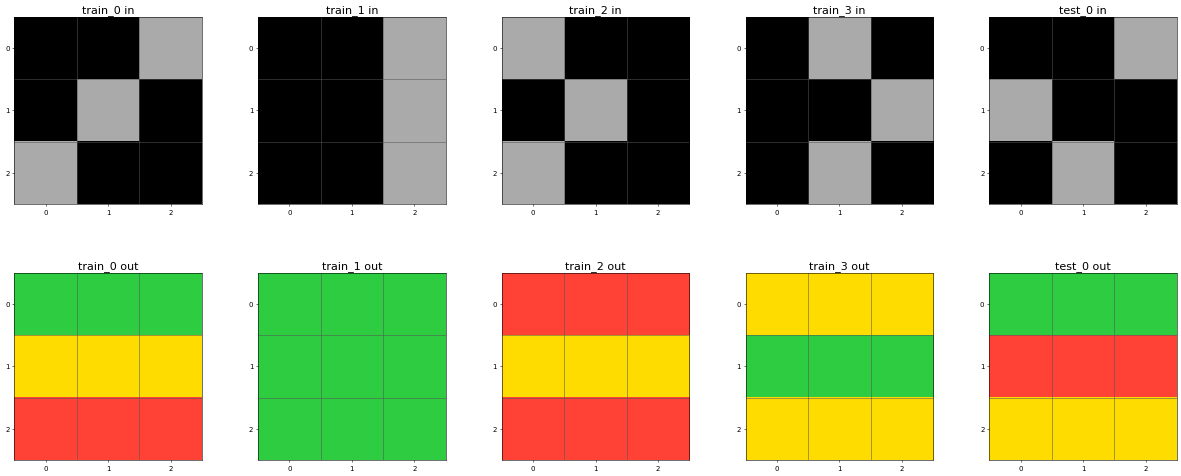

c8cbb738


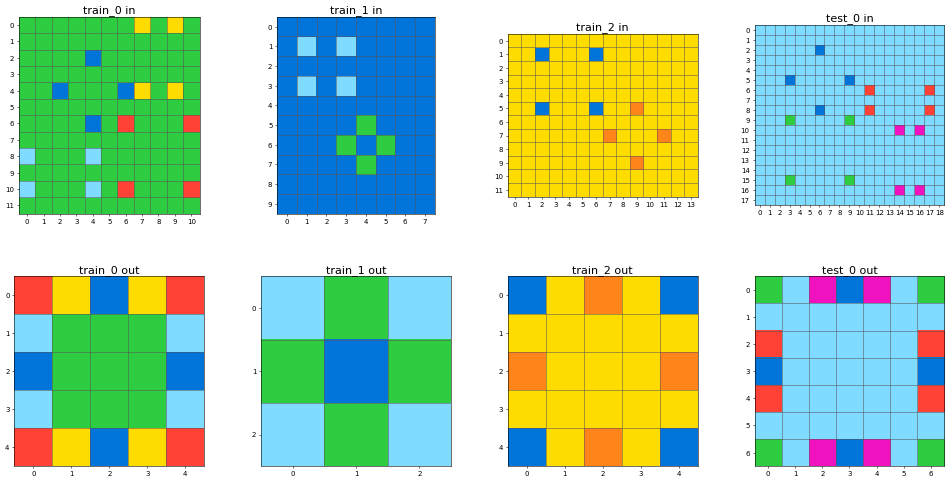

8e1813be


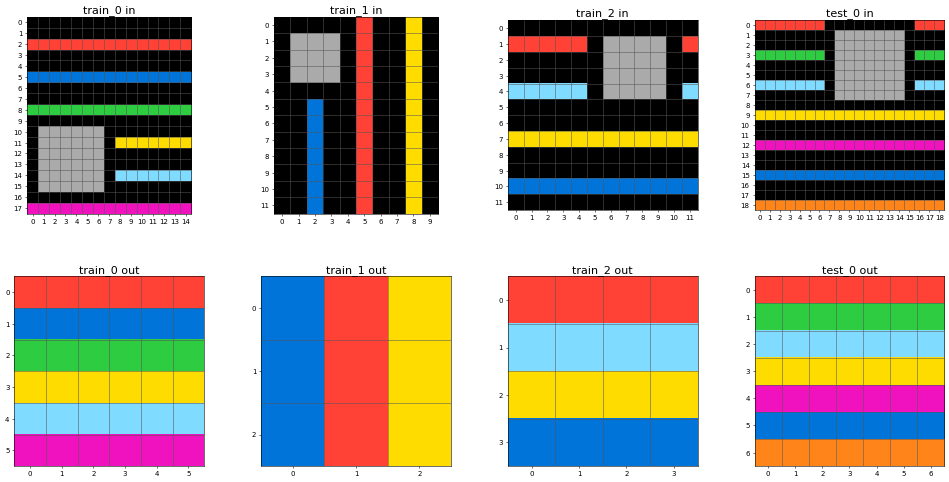

a699fb00


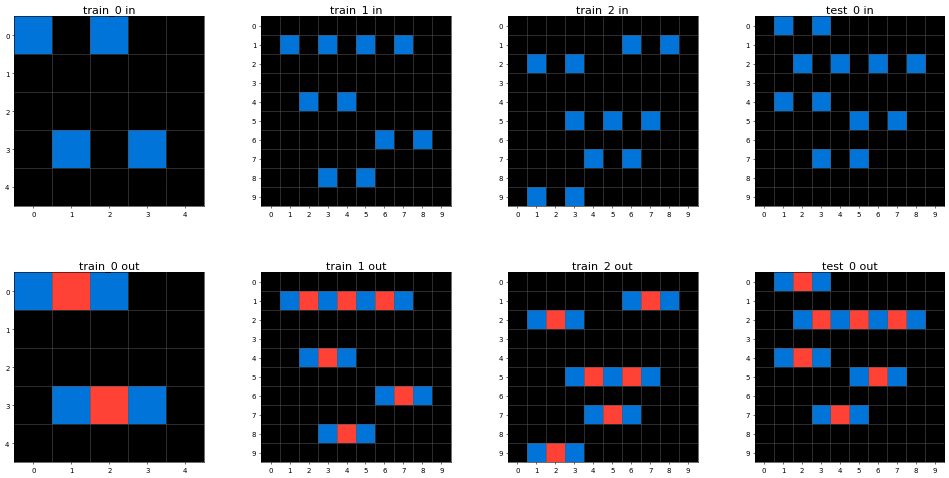

5c2c9af4


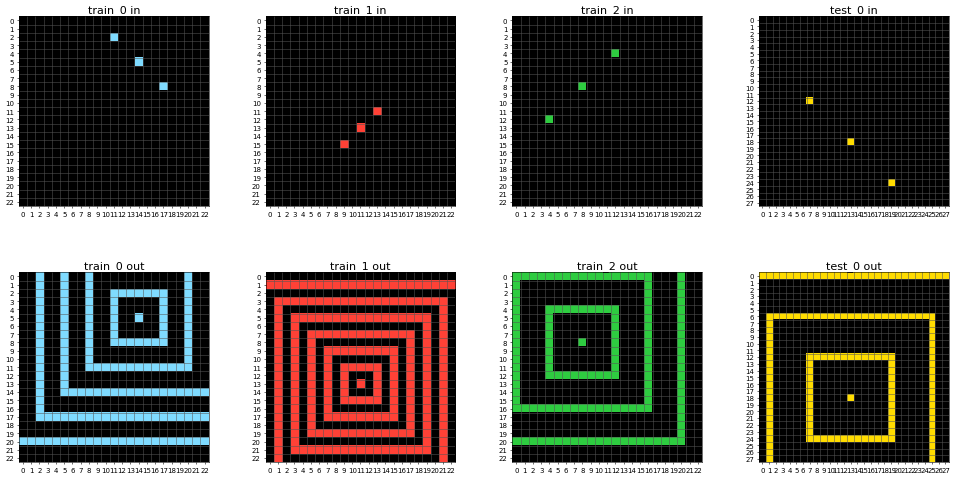

44f52bb0


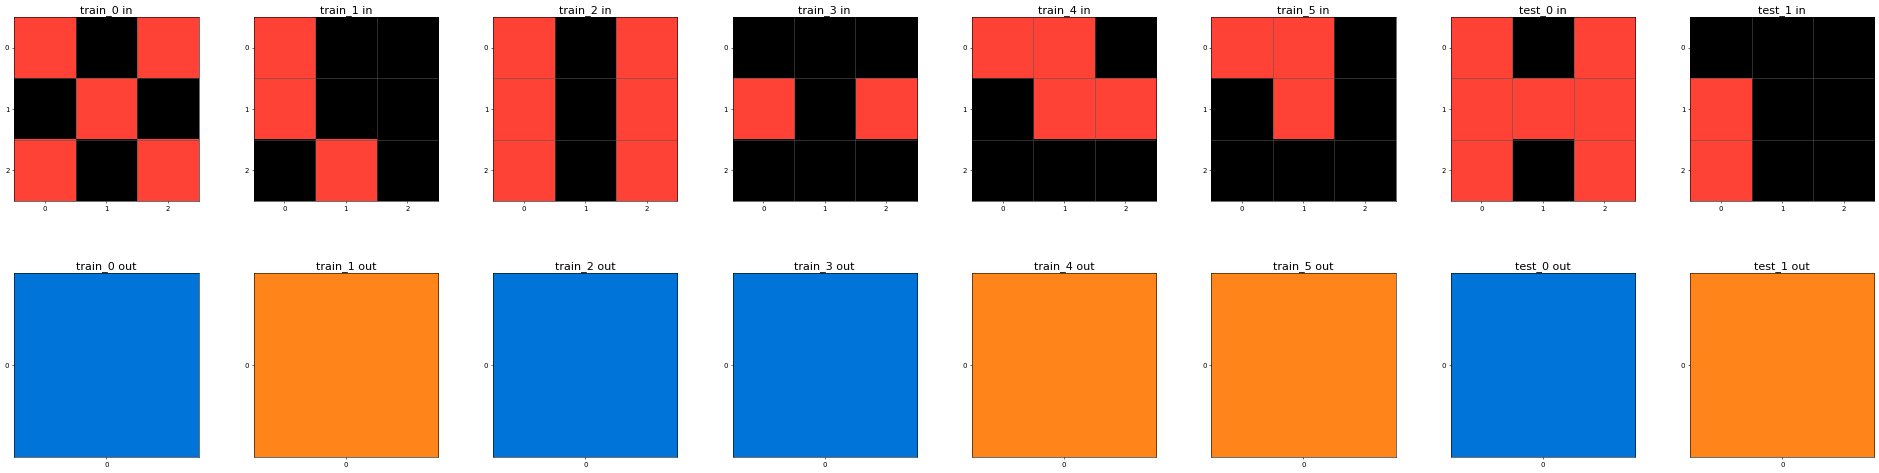

23581191


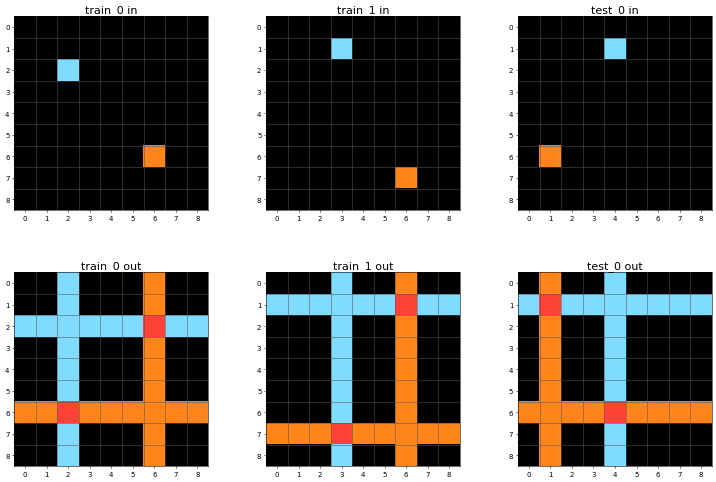

94f9d214


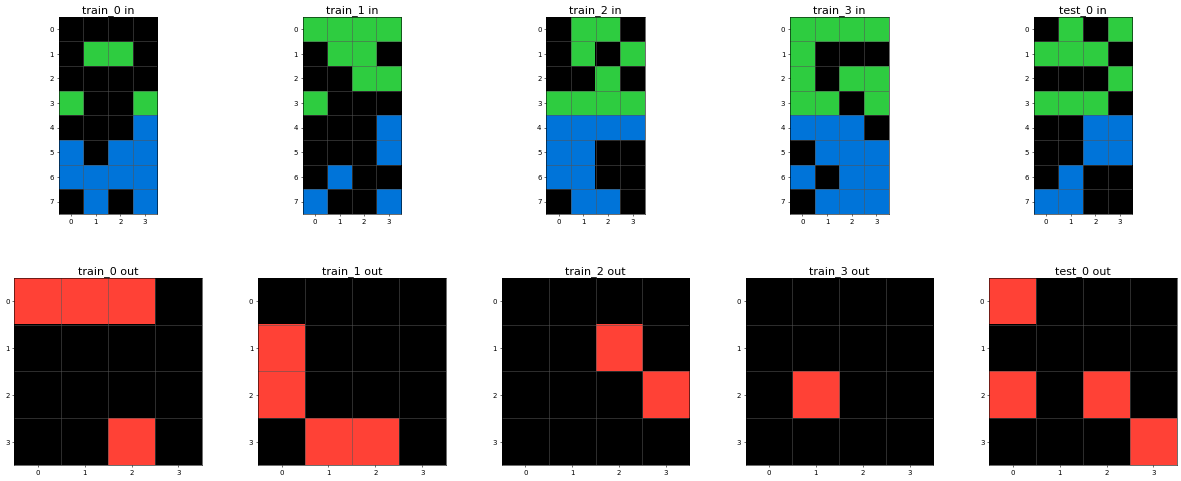

f9012d9b


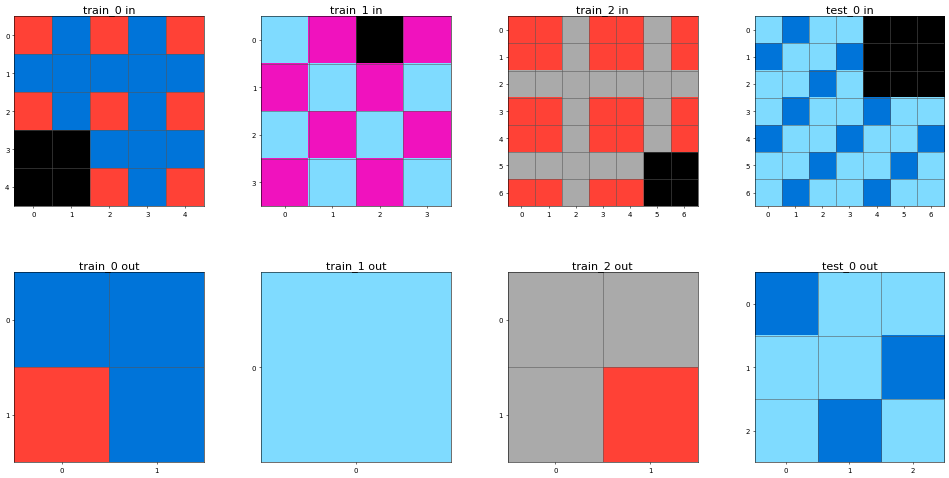

4258a5f9


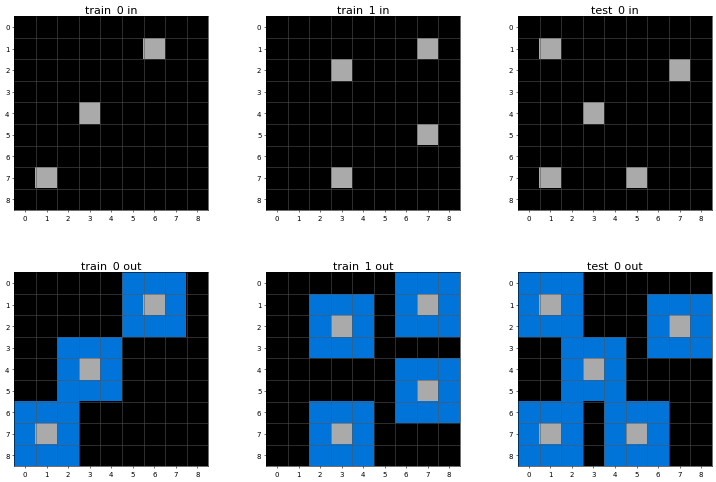

bdad9b1f


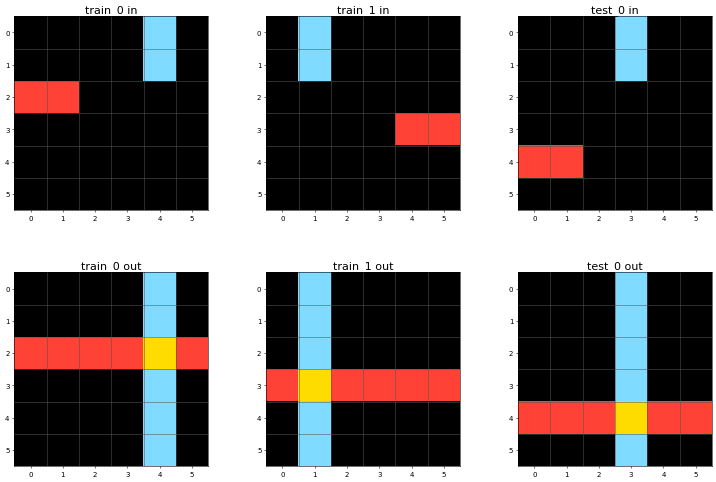

d06dbe63


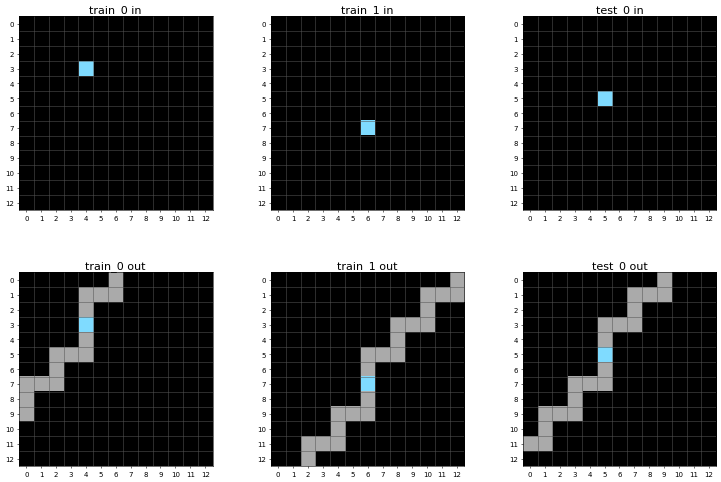

8403a5d5


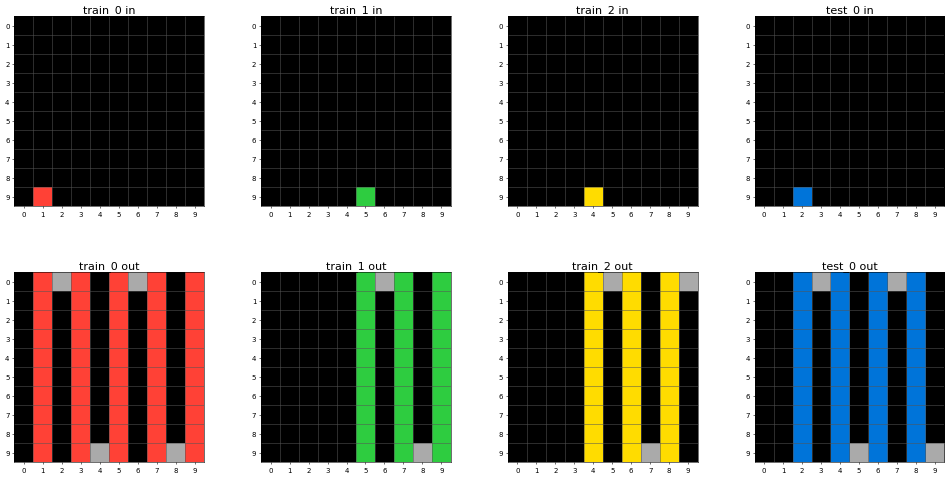

67e8384a


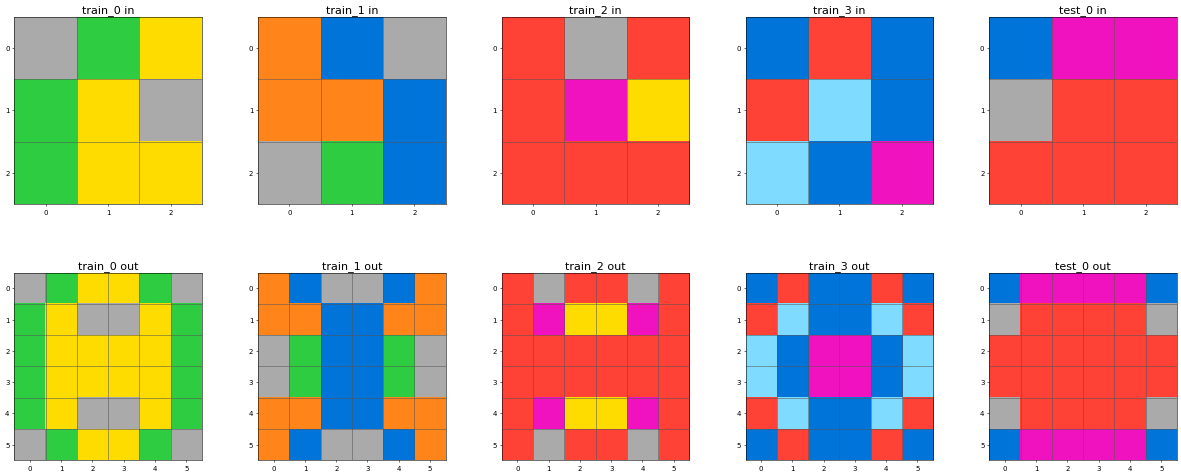

8731374e


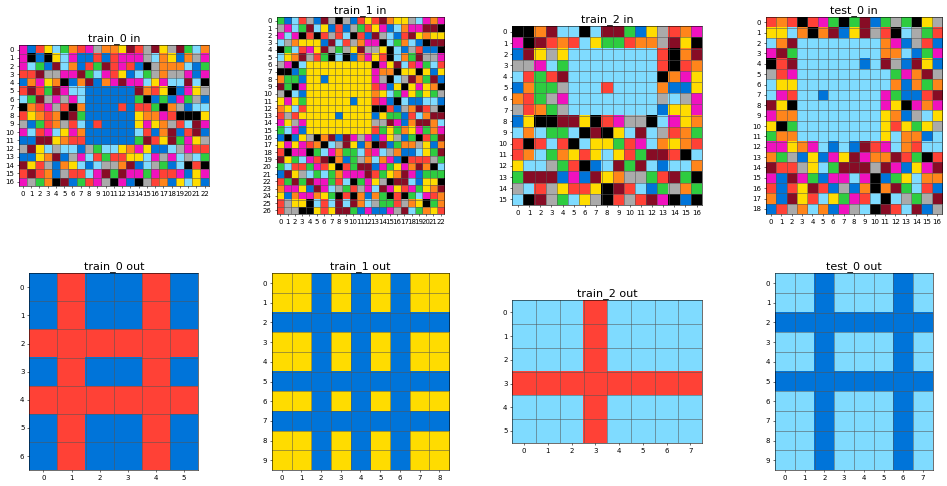

25ff71a9


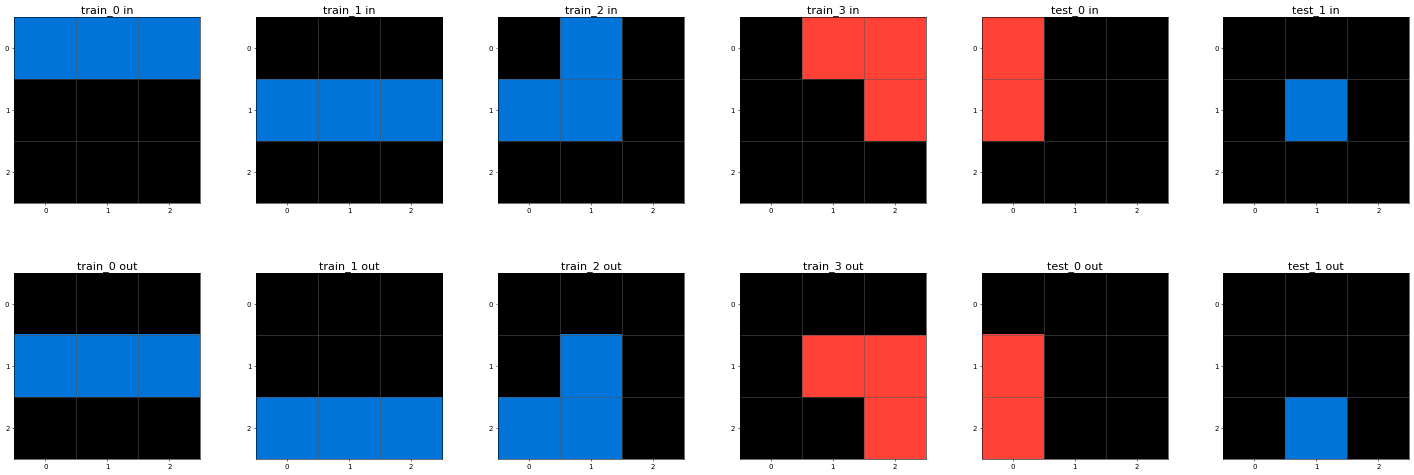

ecdecbb3


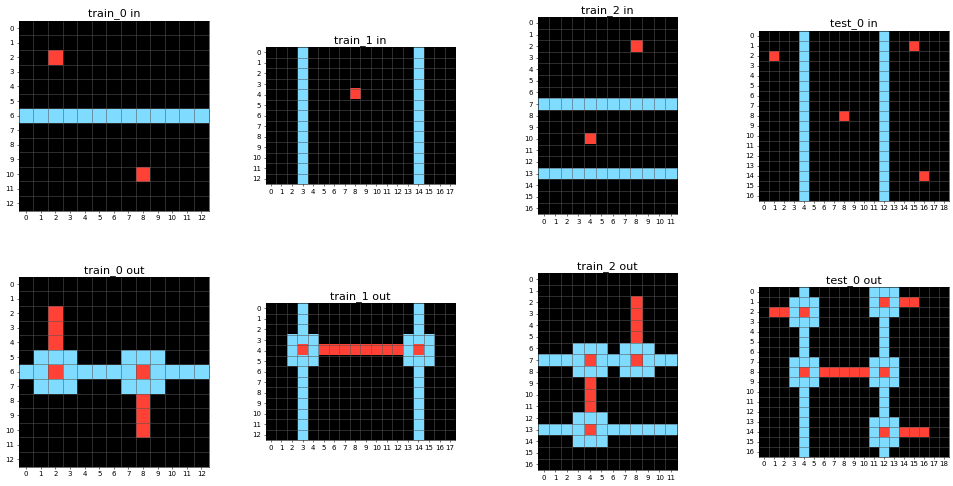

6e19193c


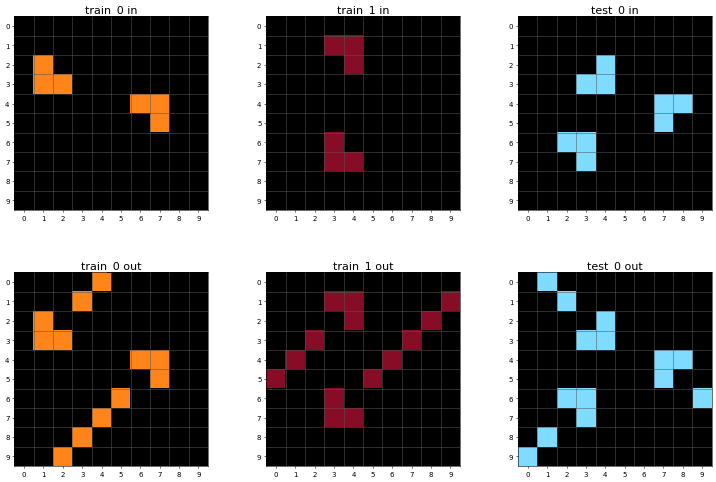

39e1d7f9


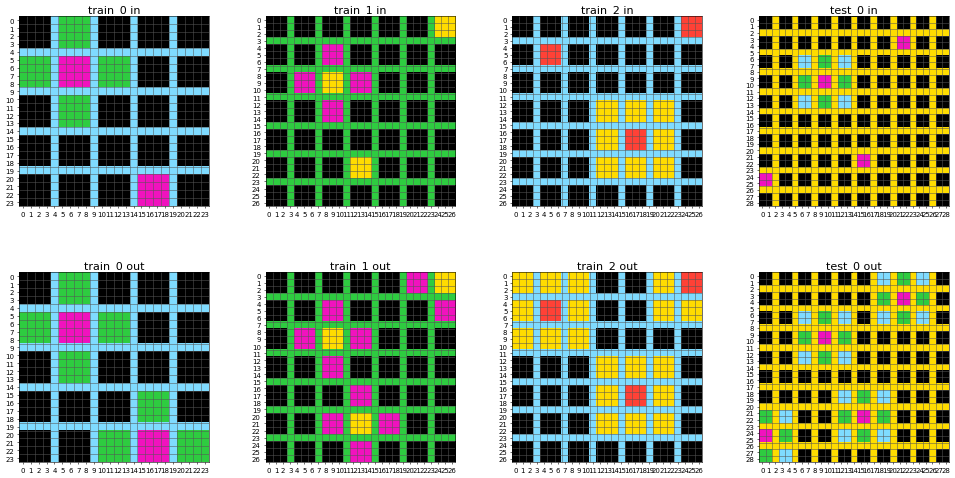

ba97ae07


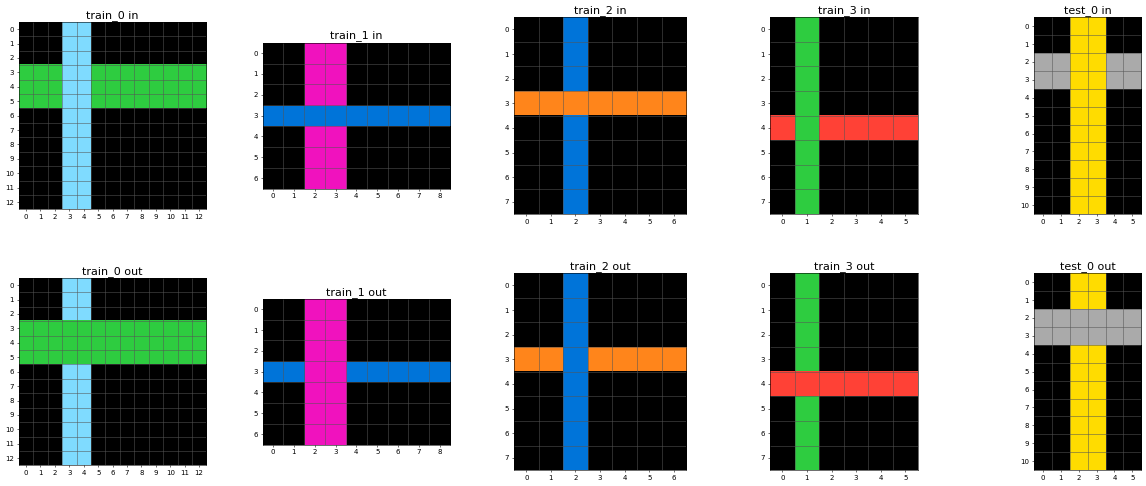

99b1bc43


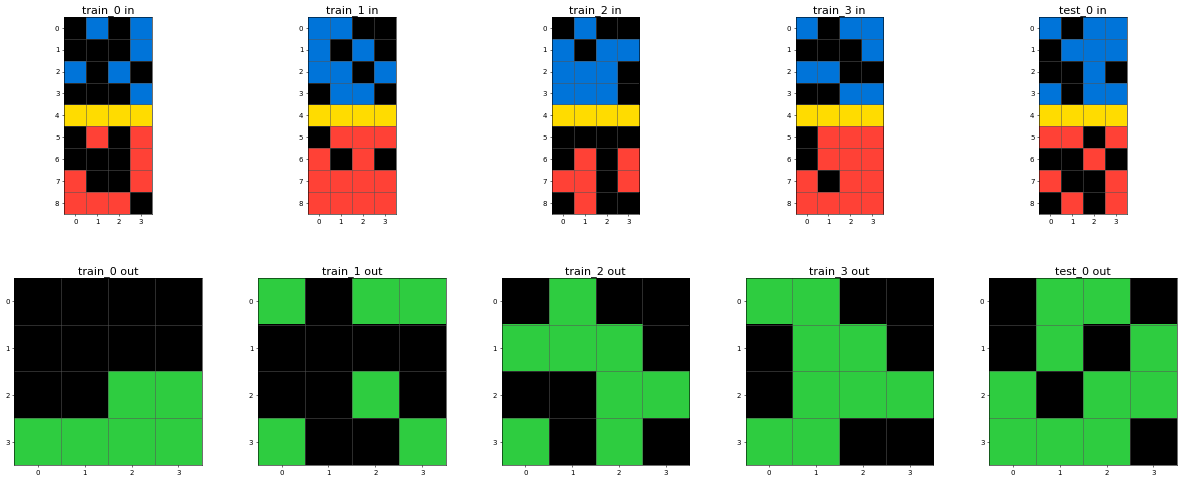

77fdfe62


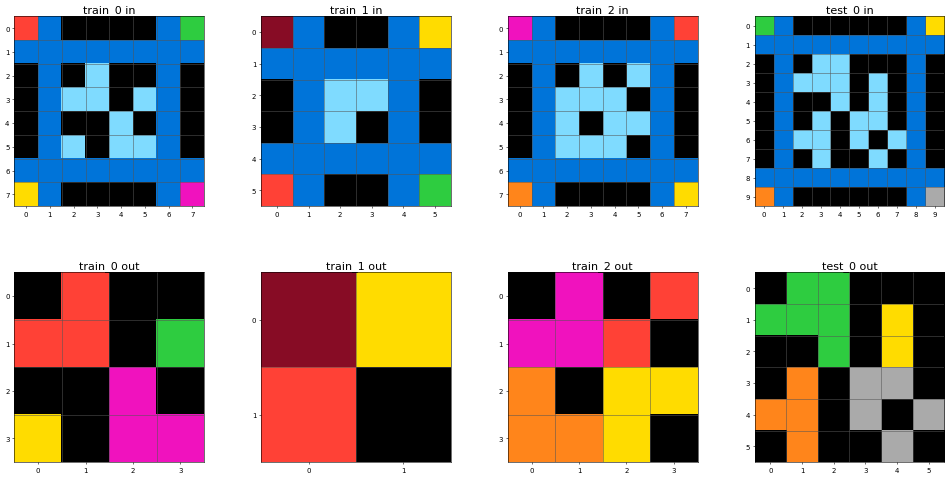

50cb2852


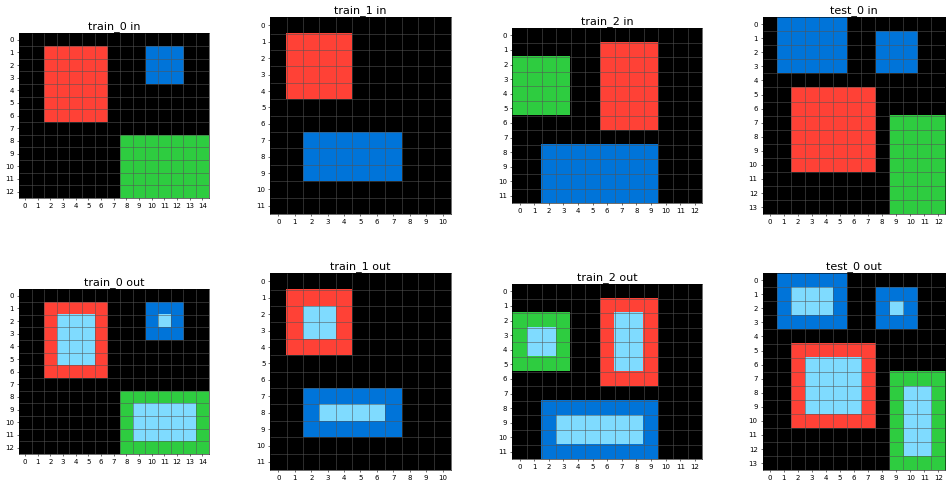

4c5c2cf0


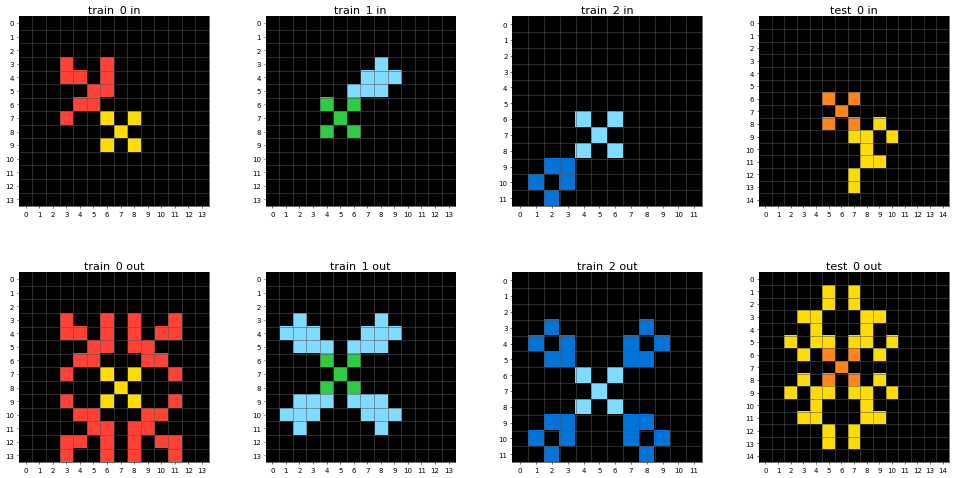

d5d6de2d


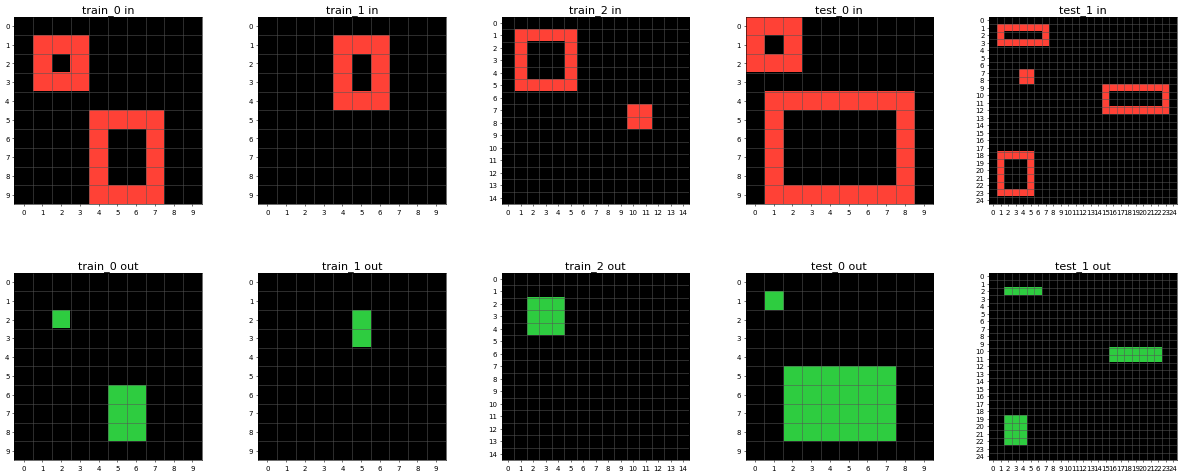

b91ae062


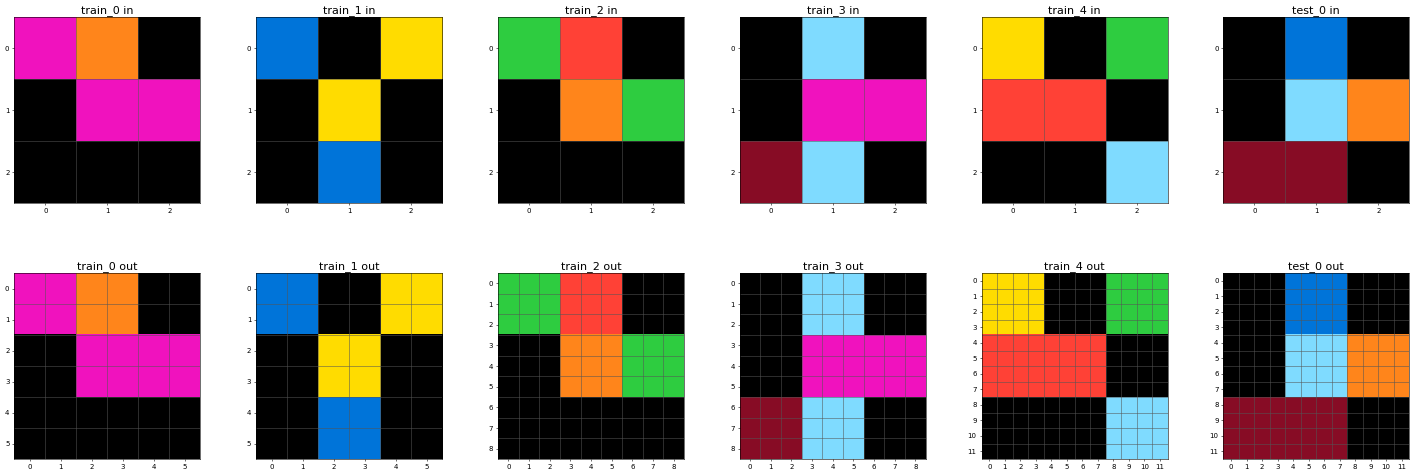

d037b0a7


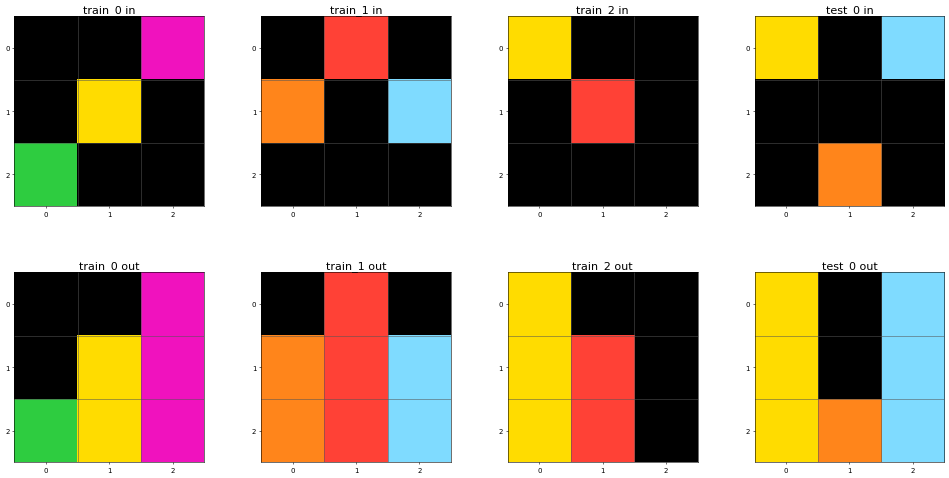

93b581b8


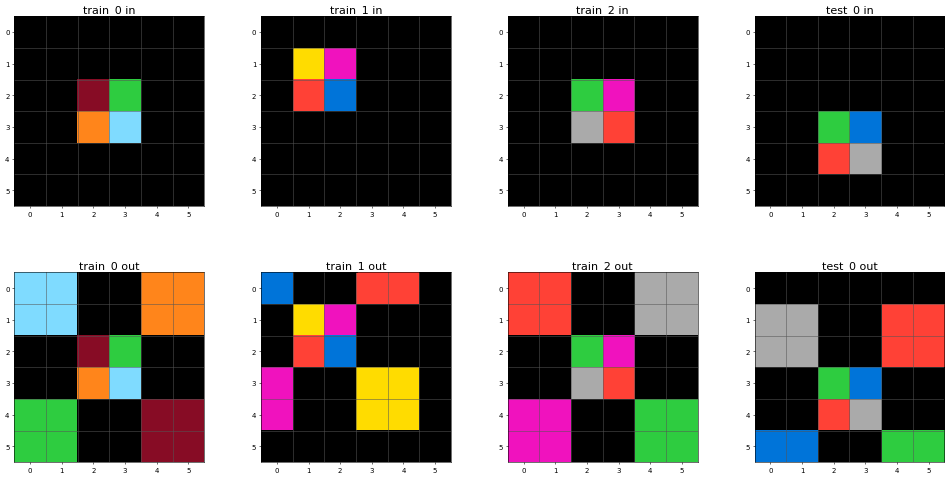

025d127b


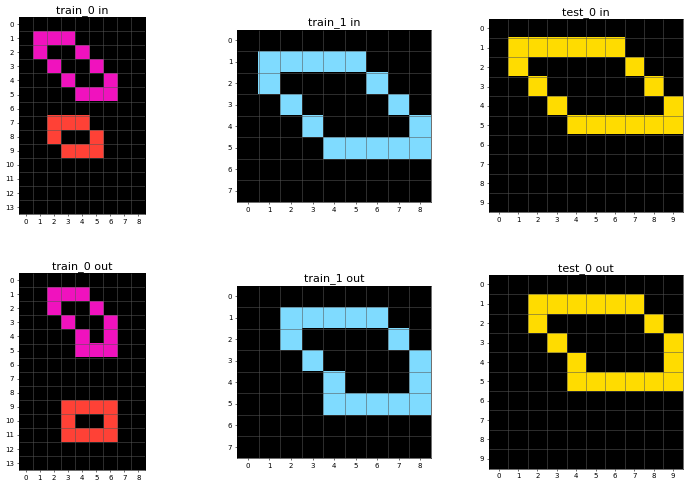

d2abd087


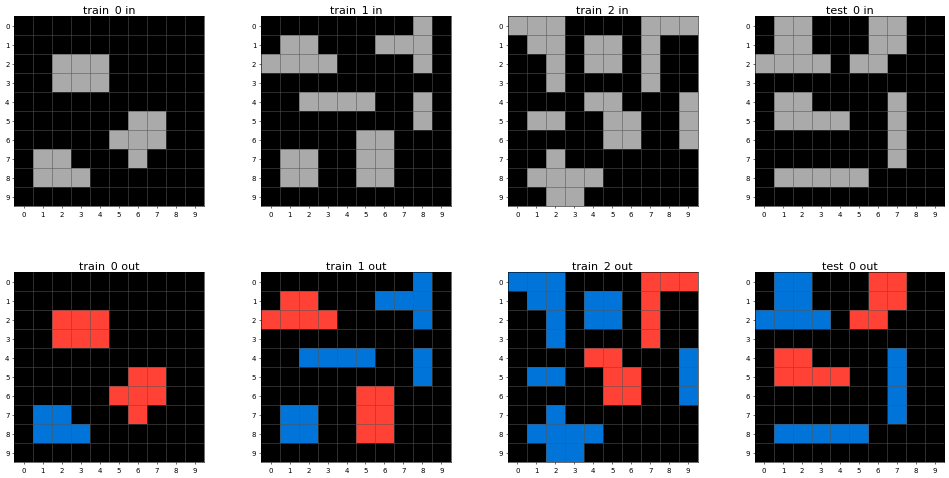

017c7c7b


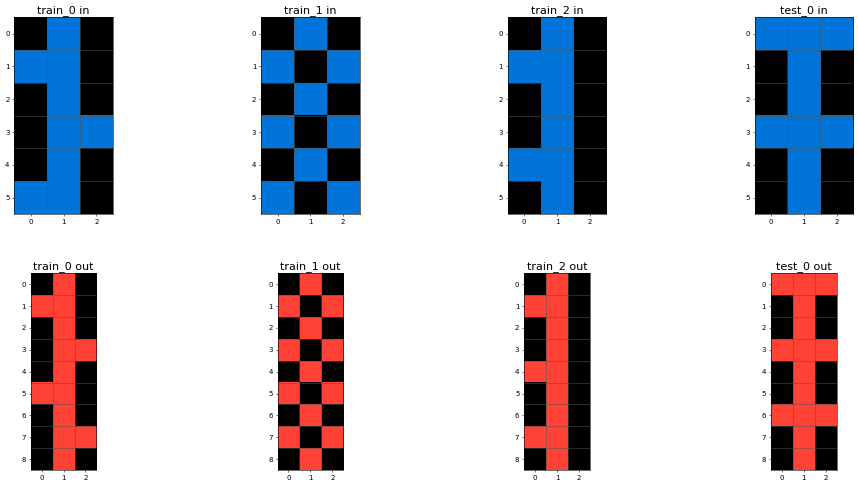

28bf18c6


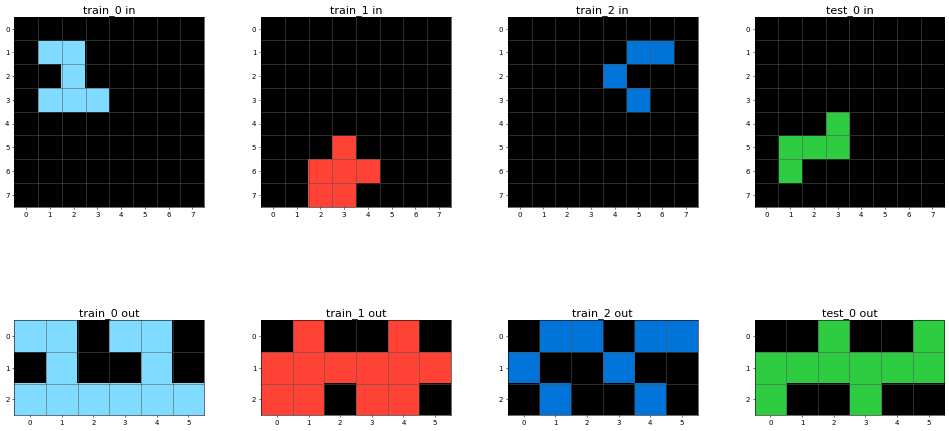

9f236235


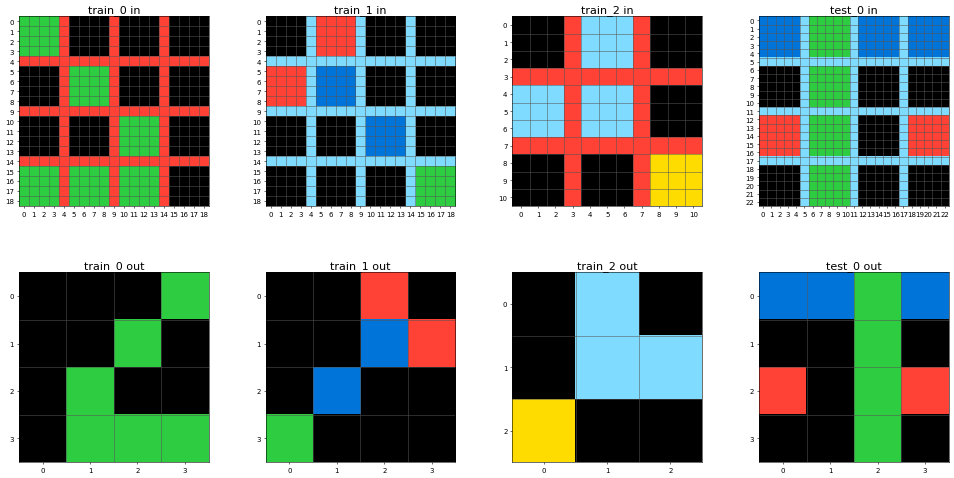

c3e719e8


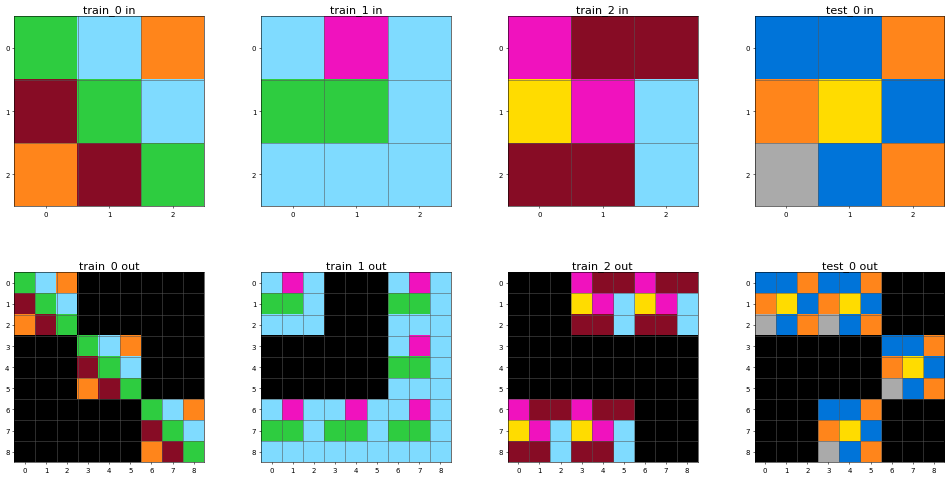

264363fd


KeyboardInterrupt: 

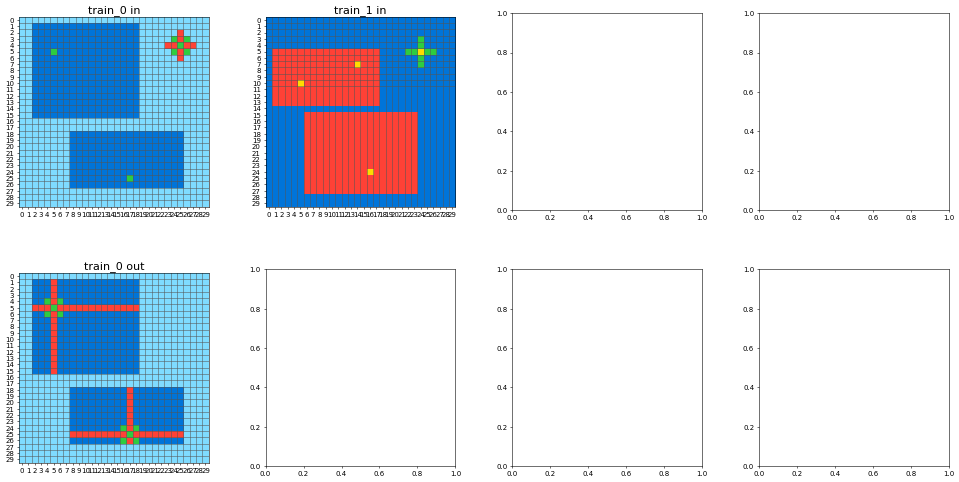

In [26]:
for task_id in train_ids:
    print(task_id)
    plot_task(load_task_from_id(task_id))

In [337]:
NUM_CHANNELS = len(COLORS)

def grid_to_rgb(x):
    """Returns a 3D array of RGB values of an ARC grid."""
    x_rgb = np.asarray(x)
    if x_rgb.ndim == 2:
        x_rgb = x_rgb[None, ...]
    if x_rgb.ndim == 3:
        x_rgb = x_rgb[..., None]
    
    x_rgb = np.repeat(x_rgb, 3, axis=-1)
    values = np.unique(x_rgb)
    for v in values:
        x_rgb[x_rgb[:,:,:,0] == v] = idx_to_rgb[v]
    return x_rgb[0] if x_rgb.shape[0] == 1 else x_rgb


def grid_to_rgba(x):
    """Returns a 3D array of RGB values of an ARC grid."""
    x = np.asarray(x)
    a = arc_conv2d((x != background_color).astype(np.float32), 
                   kernel=np.ones((3, 3), dtype=np.float32) / 9.,
                   padding='same')
    x_rgb = grid_to_rgb(x)
    x_rgba = np.concatenate([x_rgb, np.expand_dims(a, axis=-1)], axis=-1)
    return x_rgba.astype(np.float32)


def get_alpha(x, kernel=None, bkgr_color=0):
    """Returns a 3D array of RGB values of an ARC grid."""
    x = np.asarray(x, dtype=np.float32)
    ndim = x.ndim
    if ndim == 2:
        x = x[None, ..., None]
    if ndim == 3:
        raise ValueError(f"Expected 2 or 4 dims. Got {ndim}")
        
    if kernel is None:
        kernel = np.ones((3, 3, 1, 1)) / 9.
    else:
        kdim = kernel.ndim
        if kdim == 2:
            kernel = kernel[..., None]
        if kdim == 3:
            kernel = kernel[..., None]
    
    kernel = kernel.astype(np.float32)       
    a = tf.nn.depthwise_conv2d(x, kernel, [1,1,1,1], 'SAME')[0, ..., 0].numpy()
    
    return np.clip(a.astype(np.float32), 0, 1.)


def grid_to_channel(x, ch_to_value=None, background_color=0):
    """Transforms a 2D grid of color indices to a 3D tensor where each channel
    corresponds to a color.
    """
    x = np.asarray(x)
    x_channels = []
    if ch_to_value is None:
        ch_to_value = {i: i for i in range(NUM_CHANNELS)}
    
    for ch, v in ch_to_value.items():
        if v == background_color:
            x_channels.append(np.zeros_like(x, dtype=np.float32))
        else:
            x_channels.append((x == v).astype(np.float32))
    return np.stack(x_channels, axis=2)     

def channel_to_grid(x, 
                    ch_to_symbol=None,
                    mask_th=0,
                    num_channels=None,
                    background_color=0):
    """Transforms a binarized 3D matrix to a 2D grid of color indices."""
    x = np.array(x)
    if ch_to_symbol is None:
        ch_to_symbol = {i: i for i in range(NUM_CHANNELS)}
    num_channels = len(ch_to_symbol)
    
    mask = x[...,-1] > mask_th

    x_grid = np.argmax(x[..., :num_channels], axis=-1)
    x_grid = np.vectorize(ch_to_symbol.__getitem__)(x_grid)
    x_grid[np.where(mask == 0)] = background_color
    
    return x_grid

def unpad(x, output_shape):
    ndim = x.ndim
    if ndim == 2:
        h, w = x.shape
    elif ndim == 4:
        h, w = x.shape[1:3]
    else:
        raise ValueError(f"Expected 2 or 4 dims, got {x.ndim}")
    
    hp = h - output_shape[0]
    wp = w - output_shape[1]
    if hp > 0:
        hp = (hp//2, -hp//2) if hp % 2 == 0 else (hp//2+1, -hp//2)
    else:
        hp = (0, h)
    if wp > 0:
        wp = (wp//2, -wp//2) if wp % 2 == 0 else (wp//2+1, -wp//2)
    else:
        wp = (0, w)
    
    if x.ndim == 2:
        return x[hp[0]:hp[1], wp[0]:wp[1]]
    else:
        return x[:,hp[0]:hp[1], wp[0]:wp[1],:]
        
def plot_numeric(x, bold_th=None, figsize=None):
    h,w = x.shape
    s = 1
    figsize = figsize or (int(w*.8),int(h*.8))
    
    bold_th = bold_th or 0
    
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(0, h*s+1)
    ax.set_xlim(0, w*s+1)
    
    for i in range(0, h*s, s):
        for j in range(0, w*s, s):
            v = x[i//s,j//s]
            weight = 'bold' if v > bold_th else None
            ax.text(j+.5, h-i+.5, f' {v:.3f} ', weight=weight)

    ax.set(frame_on=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
def arc_conv2d(x_input, kernel, padding='same', strides=1):
    """Slides a filter (object) across a state and checks for matches."""
    x_input = np.asarray(x_input)
    kernel_h, kernel_w = kernel.shape
    
    if padding == 'same':
        hp = kernel_h // 2
        wp = kernel_w // 2
        x_input = np.pad(x_input, [(hp, wp), (hp, wp)])
    
    x_input_1d = x_input.ravel()
    kernel_1d = np.ravel(kernel)
    
    input_h, input_w = x_input.shape
    strided_h = (input_h - kernel_h + 1) // strides
    strided_w = (input_w - kernel_w + 1) // strides
    y_output = np.zeros((strided_h, strided_w), np.float32)

    indices = project_to_1d(input_w, list(product(range(kernel_h), range(kernel_w))))

    # slide the object across every possible region and check for matches
    for i in range(strided_h):
        for j in range(strided_w):
            strided_indices = indices + j + i * input_w
            dot = np.dot(x_input_1d[strided_indices], kernel_1d)
            y_output[i, j] = np.dot(x_input_1d[strided_indices], kernel_1d)
    
    return y_output

In [21]:
identity = np.outer([0,1,0], [0,1,0]).astype(np.float32)
sobel_x = np.outer([1, 2, 1], [-1, 0, 1]).astype(np.float32)
sobel_y = sobel_x.T

In [354]:
def get_living_mask(x, mask_th=.1):
    """As long as one neighbor has a value > `th` it will be considered 'alive'.
    Any cells with no neighbors > `th` will be considered dead (zero'd out)
    """
    a = x[:,:,:,-1:]
    return tf.nn.max_pool2d(a, 3, [1, 1, 1, 1], 'SAME') > mask_th

class CAModel(tf.keras.Model):

    def __init__(self, num_channels=11, dropout=.5, mask_th=.1):
        super().__init__()
        self.num_channels = num_channels
        self.dropout = dropout
        self.mask_th = mask_th
        self.kernel = None
        
        identity = np.array([0, 1, 0], dtype=np.float32)
        identity = np.outer(identity, identity)
        self.identity = np.repeat(identity[..., None, None], self.num_channels, 2)
        
        # add a switcharoo too???
        dx = np.array(np.outer([1, 2, 1], [-1, 0, 1]) / 8., dtype=np.float32)
        dy = dx.T
        self.dx_a = np.repeat(dx[..., None, None], self.num_channels, 2)
        self.dy_a = np.repeat(dy[..., None, None], self.num_channels, 2)
        self.dx_b = self.dx_a * -1.
        self.dy_b = self.dy_a * -1.
        
        self.dcontext = tf.keras.layers.Conv2D(self.num_channels * 3, 
                                               1,
                                               padding='same',
                                               activation=tf.nn.relu,
                                               use_bias=False)
        self.dmodel = tf.keras.Sequential([
              tf.keras.layers.Conv2D(128,
                                     1,
                                     activation=tf.nn.relu,
                                     use_bias=False
                                    ),
              tf.keras.layers.Conv2D(self.num_channels, 
                                     1,
                                     activation=None,
                                     use_bias=False,
                                     kernel_initializer=tf.zeros_initializer
                                    )
            
        ])
        
        self._set_inputs(tf.zeros([1, 3, 3, self.num_channels]))

    @tf.function
    def perceive(self, x):
        y = tf.concat([
            tf.nn.depthwise_conv2d(x, self.identity, [1,1,1,1], 'SAME'),
            tf.nn.depthwise_conv2d(x, self.dx_a, [1,1,1,1], 'SAME'),
            tf.nn.depthwise_conv2d(x, self.dy_a, [1,1,1,1], 'SAME'),
#             tf.nn.depthwise_conv2d(x, self.dx_b, [1,1,1,1], 'SAME'),
#             tf.nn.depthwise_conv2d(x, self.dy_b, [1,1,1,1], 'SAME'),
#             self.dcontext(x)
        ], axis=-1)
        return tf.clip_by_value(y, -1., 1.)

    @tf.function
    def call(self, x, dropout=0.5, step_size=1.0, mask_th=0.1):
        mask_th = self.mask_th if mask_th is None else mask_th
        dropout = self.dropout if dropout is None else self.dropout
        step_size = self.step_size if step_size is None else step_size
        
        # get alive mask from input (before any updates)
        pre_life_mask = get_living_mask(x, mask_th)

        y = self.perceive(x)
        dx = self.dmodel(y) * step_size
        # "dropout out" - only update `rate_rate` of the spatial features
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= dropout
        x += dx * tf.cast(update_mask, tf.float32)
        
        # get alive mask from input (before any updates)
        post_life_mask = get_living_mask(x, mask_th)
        # only keep cells who are alive before and after
        # thought (but not true) i need to use the alpha fro the output, but remember it's a 3x3 pool
        life_mask = pre_life_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)

In [75]:
# # 423a55dc next
# # task = load_task_from_id('21f83797')
# # task = load_task('../data/evaluation/21f83797.json')
# # task = load_task_from_id('639f5a19')
# task = load_task_from_id('da2b0fe3')
# # task = load_task_from_id('5207a7b5')
# # task = load_task_from_id('db3e9e38')
# plot_task(task)
# x_train, y_train = get_input_output(task['train'])
# x_test, y_test = get_input_output(task['test'])
# x_grid , y_grid = x_train[0], y_train[0]

In [67]:
################################################################################
# preprocess functions
################################################################################

def preprocess(x, 
               shape,
               ch_to_value=None,
               alpha=None,
               input_template=None,
               add_channels=0,
               background_color=0):
    h, w = x.shape[:2]
    hp = (shape[0] - h)
    wp = (shape[1] - w)
    
    hp = (hp//2,)*2 if hp % 2 == 0 else (hp//2+1, hp//2)
    wp = (wp//2,)*2 if wp % 2 == 0 else (wp//2+1, wp//2)
    
    x_padded = pad(x, hp, wp)
    x_channel = grid_to_channel(x_padded, ch_to_value, background_color=background_color)
    
    if alpha is None:
        alpha = get_alpha(x_padded) * x_padded.astype(bool)
        if input_template is not None:
            alpha = alpha + pad(input_template, hp, wp)
        alpha = np.clip(alpha, 0., 1.)
    elif alpha.shape != shape:
        alpha = np.pad(alpha, [hp, wp])
    if add_channels > 0:
        x_channel = np.repeat(x_channel, add_channels, axis=-1)
#         x_extra = np.repeat(x_padded[..., None], add_channels, axis=-1)
#         x_channel = np.concatenate([x_channel, x_extra], axis=-1)
        
    x_output = np.concatenate([x_channel, alpha[..., None]], axis=-1)
    return x_output


def pad(x, hp=0, wp=0, dp=0):
    ndim = x.ndim
    if not isinstance(hp, (list, tuple)):
        hp = (hp, hp)
    if not isinstance(wp, (list, tuple)):
        wp = (wp, wp)
    if not isinstance(dp, (list, tuple)):
        dp = (dp, dp)

    if ndim == 2:
        pad_width = [hp, wp]
    else:
        pad_width = [hp, wp, dp]
    return np.pad(x, pad_width)


def generate_pairs(x, y, num_samples=8, max_shift=3):
    """Generates shifted samples of an input and output."""
    x_new = []
    y_new = []
    
    h, w = x.shape[:2]
    h_indices = np.arange(h)
    w_indices = np.arange(w)

    for i in range(num_samples):
        shift_w = np.random.choice(range(-max_shift+1, max_shift))
        shift_h = np.random.choice(range(-max_shift+1, max_shift))
        
        h_idx = h_indices[:shift_h] if shift_h < 0 else h_indices[shift_h:]
        w_idx = w_indices[:shift_w] if shift_w < 0 else w_indices[shift_w:]
        
        hp = (-shift_h, 0) if shift_h < 0 else (0, shift_h)
        wp = (-shift_w, 0) if shift_w < 0 else (0, shift_w)
        
        x_new.append(pad(x[h_idx,:][:,w_idx], hp, wp))
        y_new.append(pad(y[h_idx,:][:,w_idx], hp, wp))
        
    return np.stack(x_new), np.stack(y_new)


def score_ca(y_true, y_pred, ch_to_symbols=None, mask_th=0.01):
    if ch_to_symbols is not None:
        y_true_grid = []
        y_pred_grid = []
        if not isinstance(ch_to_symbols, list):
            ch_to_symbols = [ch_to_symbols]
        for i in range(len(y_true)):
            y_true_grid.append(channel_to_grid(y_true[i], 
                                               ch_to_symbols[i],
                                               0))
            y_pred_grid.append(channel_to_grid(y_pred[i], 
                                               ch_to_symbols[i],
                                               mask_th))
        y_true = np.asarray(y_true_grid)
        y_pred = np.asarray(y_pred_grid)
    
    acc = score_task(y_true, y_pred)
    return acc

def get_active_ch(x, num_colors=10):
    chs = tuple(range(num_colors)) + (-1,)
    if x.ndim == 3:
        values = (x[:,:,:num_colors], x[:,:,-1:])
        if isinstance(x, tf.Tensor):
            return tf.concat(values, axis=-1)
        else:
            return np.concatenate(v, axis=-1)
    else:
        values = [x[:,:,:,:num_colors], x[:,:,:,-1:]]
        if isinstance(x, tf.Tensor):
            return tf.concat(values, axis=-1)
        else:
            return np.concatenate(v, axis=-1)
        return x[:,:,chs]

In [66]:
################################################################################
# loss functions
################################################################################


def mean_squared_error(y_true, y_pred, axis=None):
    if axis is None:
        axis = [-3, -2, -1]
    return tf.reduce_mean(tf.square(y_true-y_pred), axis=axis)

def bernoulli_loss(y_true, y_pred, from_logits=True):
    """Computes the bernoulli loss (log loss) between the targets (input)
    and predictions (reconstruction).
    """
    if from_logits:
        loss = tf.reduce_sum(
            tf.nn.sigmoid_cross_entropy_with_logits(
                labels=y_true, logits=y_pred
            ),
            axis=1,
        )
    else:
        loss = - tf.reduce_sum(
            y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred),
            axis=1
        )
    return tf.reduce_mean(loss)

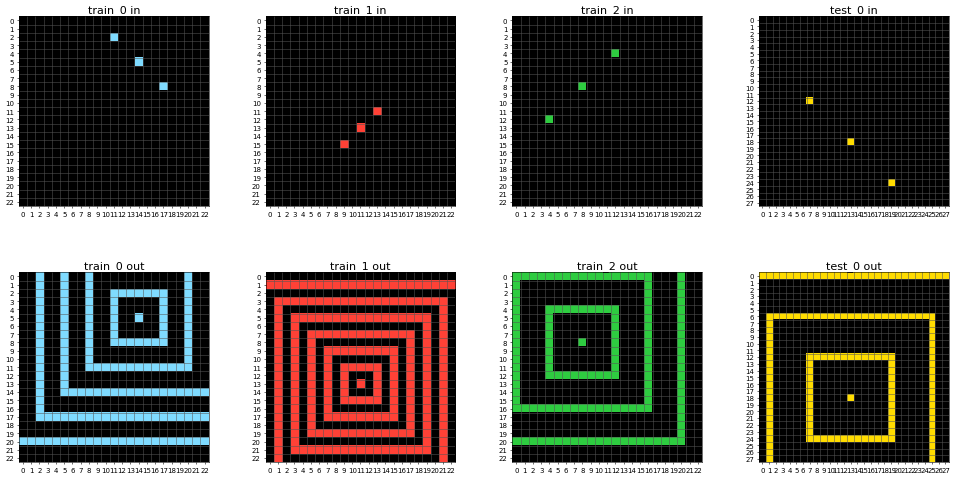

In [25]:
task = Task(id_to_filepath['5c2c9af4'])
task.plot()

In [292]:
padding = 5
padded_shape = task.max_shape + padding * 2
add_samples = 8
add_channels = 0

input_train = []
output_train = []
input_test = []
output_test = []
ch_to_symbols = []

for i in range(1):
    i += 2
    input_template = task.train_input[i].astype(bool).astype(np.float32)
    background_color = task.background_colors[i]
    ch_to_symbol = task.ch_to_colors[i]
    input_example = preprocess(
        task.train_input[i], 
        padded_shape, 
        ch_to_value=ch_to_symbol,
        input_template=task.train_input[i].astype(bool).astype(np.float32),
        add_channels=add_channels,
        background_color=background_color,
    )
    output_example = preprocess(
        task.train_output[i], 
        padded_shape,
        ch_to_value=ch_to_symbol,
        input_template=task.train_output[i].astype(bool).astype(np.float32),
        background_color=background_color,
    )
    if add_samples > 0:
        train_pairs = generate_pairs(input_example, 
                                     output_example,
                                     add_samples, 
                                     max_shift=padding)
        input_train.append(train_pairs[0])
        output_train.append(train_pairs[1])
    else:
        input_train.append(input_example[None, ...])
        output_train.append(output_example[None, ...])
    
    ch_to_symbols.extend([ch_to_symbol for _ in range(max(add_samples, 1))])
    
input_train = np.vstack(input_train)#[...,:-1]
output_train = np.vstack(output_train)#[...,:-1]

for i in range(task.num_test):
    input_template = task.train_input[i].astype(bool).astype(np.float32)
    ch_to_symbol = task.ch_to_colors[task.num_train + i]
    background_color = task.background_colors[task.num_train + i]
    input_test.append(
        preprocess(
            task.test_input[i], 
            padded_shape, 
            ch_to_value=ch_to_symbol,
            add_channels=add_channels,
            input_template=task.test_input[i].astype(bool).astype(np.float32),
            background_color=background_color,
        )
    )
    output_test.append(
        preprocess(
            task.test_output[i], 
            padded_shape, 
            ch_to_value=ch_to_symbol,
            input_template=task.test_output[i].astype(bool).astype(np.float32),
            background_color=background_color,
        )
    )
    
    ch_to_symbols.append(ch_to_symbol)
    
input_test = np.stack(input_test)#[...,:-1]
output_test = np.stack(output_test)#[...,:-1]

num_channels = input_train.shape[-1] - 1 - 1

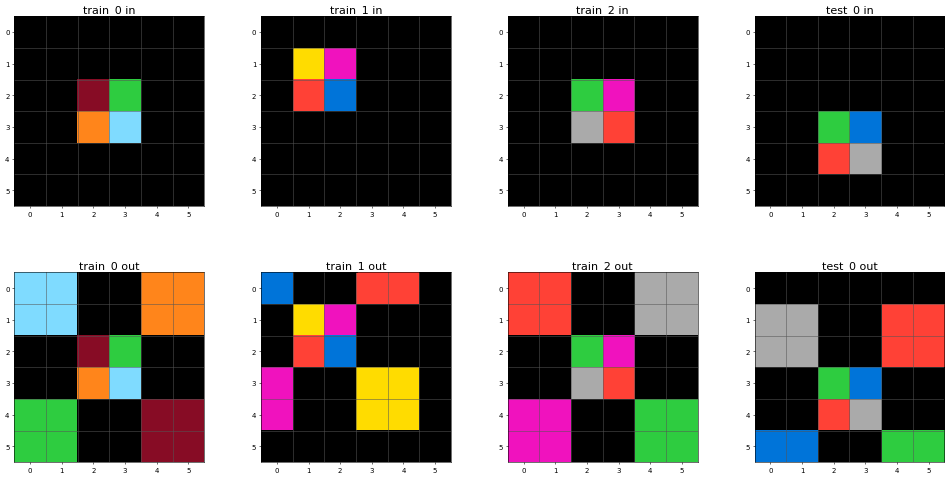

In [290]:
task.plot()

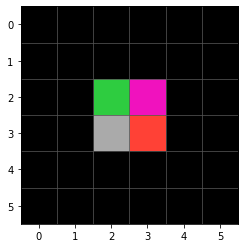

In [293]:
plot_grid(channel_to_grid(input_train[0], ch_to_symbols[0]))

In [295]:
class CASampler:
    def __init__(self, data_source, pool_size=512, parent=None, parent_indices=None):
        self.data_source = data_source
        self.pool_size = pool_size
        self._parent = parent
        self._parent_indices = parent_indices
        
        self._num_samples = len(self.data_source)
    
    @property
    def num_samples(self):
        if self._num_samples is None:
            return len(self.data)
        return self._num_samples
    
    @property
    def data(self):
        return self.data_source
    
    def sample(self, n):
        indices = np.random.choice(self.num_samples, n, False)
        batch = self.data_source[indices]
        batch_sampler = CASampler(batch, parent=self, parent_indices=indices)
        return batch_sampler

    def update(self, batch):
        self.data_source[:] = batch
        self._parent.data_source[self._parent_indices] = self.data_source[:]

In [355]:
class AdapativeParam(object):
    
    def __init__(self, 
                 start_value,
                 factor=.9, 
                 update_fn=None,
                 patience=5,
                 mode='min',
                 min_delta=0,
                 cooldown=0,
                 lower_bound=0,
                 upper_bound=np.inf,
                 name=None,
                 update_params=None):
        self.start_value = start_value
        self.factor = factor
        self.patience = patience
        if update_fn is not None:
            self.update_fn = update_fn
        else:
            self.update_fn = lambda x, eps, *args, **kwargs: x * eps
        self.mode = mode
        self.min_delta = min_delta
        self.cooldown = cooldown
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.name = name
        self.update_params = update_params or {}
        
        self.value = self.start_value
        self.best = None
        self.monitor_op = None
        self.current_step = 0
        self.wait = 0
        self.cooldown_counter = 0
        self.best_step = 0
        self.history = {}
        
        self._reset()
    
    def __repr__(self):
        return f'<{self.__class__.__name__} ({self.name}): {self.value}>'
    
    def __add__(self, other):
        return self.value + other
    
    def __radd__(self, other):
        return self.value + other
    
    def __mul__(self, other):
        return self.value * other
    
    def __rmul__(self, other):
        return self.value * other
    
    def __truediv__(self, other):
        return self.value / float(other)
    
    def __rtruediv__(self, other):
        return float(other) / self.value
    
    def __sub__(self, other):
        return self.value - other
    
    def __rsub__(self, other):
        return other - self.value
    
    def __pow__(self, other):
        return self.value ** other
    
    def __rpow__(self, other):
        return other ** self.value
    
    def __le__(self, other):
        return self.value <= other
    
    def __lt__(self, other):
        return self.value < other
    
    def __ge__(self, other):
        return self.value >= other
    
    def __gt__(self, other):
        return self.value > other
    
    def __eq__(self, other):
        return self.value == other
    
    def __neq__(self, other):
        return self.value != other
    
    def __hash__(self):
        return hash(self.value)
    
    def _reset(self):
        if self.mode not in ['min', 'max', 'auto']:
            raise ValueError( 'Expected `mode` in (min, max, auto).' 
                             f'got {self.mode}')

        if self.mode == 'max':
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        else:
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        
        self.history['best'] = [self.best]
        self.history['best_step'] = [self.best_step]
        self.history['value'] = [self.value]
    
    def step(self, current, step=None, **kwargs):
        if step is None:
            self.current_step += 1
        
        if self.monitor_op(current, self.best):
            self.best = current
            self.best_step = self.current_step
            self.history['best'].append(self.best)
            self.history['best_step'].append(self.best_step)
            self.history['value'].append(self.value)
            
            self.wait = 0
            self.cooldown_counter = 0
        else:
            self.cooldown_counter += 1
            if self.cooldown_counter > self.cooldown:
                self.wait += 1
                if self.wait > self.patience:
                    new_value = self.update_fn(self.value, 
                                               self.factor,
                                               self.current_step,
                                               **self.update_params,
                                               **kwargs)
                    if new_value > self.lower_bound and new_value < self.upper_bound:
                        print(f'Updating {self.name} from {self.value} to {new_value} '
                              f'at step {self.current_step}')
                        self.value = new_value
                    
                    self.wait = 0
                    self.cooldown_counter = 0
    def __array__(self):
        return np.array(self.value)
    

class Scheduler(object):
    
    def __init__(self, params):
        self.params = params
        
    def __call__(self, current, step=None, **kwargs):
        for key, param in self.params.items():
            param.step(current, step, **kwargs)
            
    def __repr__(self):
        _params_str = '\n\t'.join([p.__repr__() for p in self.params.values()])
        return f"<{self.__class__.__name__}: \n\t{_params_str}>"

In [302]:
patience = 10
cooldown = 32

def log_scale(x, factor, step=None, *args, **kwargs):
    return x**factor

dropout = AdapativeParam(start_value=0.5, 
                         factor=.9,
                         update_fn=log_scale,
                         mode='min', 
                         upper_bound=1,
                         patience=25,
                         name='dropout')

step_size = AdapativeParam(start_value=1., 
                           factor=.95,
                           mode='min',
                           lower_bound=.1,
                           patience=25,
                           name='step_size')

mask_th = AdapativeParam(start_value=0.1, 
                         factor=.95,
                         mode='min', 
                         update_fn=log_scale,
                         lower_bound=.1,
                         patience=25,
                         name='mask_th')

params = {
    'dropout': dropout, 
    'step_size': step_size, 
    'mask_th': mask_th
}
sched = Scheduler(params)
# mask_th = 0

num_input_channels = input_train.shape[-1]
num_channels = len(ch_to_symbols[0])

model = CAModel(mask_th=mask_th, num_channels=num_input_channels)
lr = 3e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [100, 250, 500], [lr, lr*.1 ,lr*.01, lr*.001])
optim = tf.keras.optimizers.Adam(lr)

pool_size = 512
batch_size = 8
sampler = CASampler(np.repeat(input_train, pool_size, axis=0))

cleanup()
dt_str = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
ckpt_dir = os.path.join(LOG_DIR, f'{task.name}_{dt_str}')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

use_sampler = True
print(sched)

<Scheduler: 
	<AdapativeParam (dropout): 0.5>
	<AdapativeParam (step_size): 1.0>
	<AdapativeParam (mask_th): 0.1>>


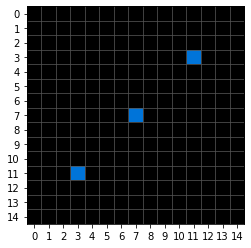

In [280]:
x = input_train[0,4:19,4:19,1]
plot_grid(x)

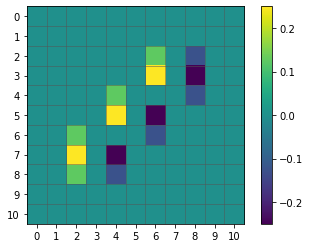

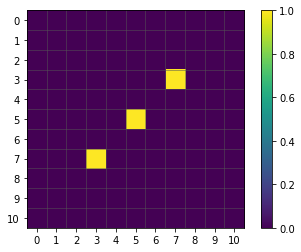

In [603]:
plot_gradient(p[0,...,0]); plt.show()
plot_gradient(_x)

In [285]:
dx = np.outer([1,2,1], [-1,0,1])
dy = dx.T[..., None, None]
dx = dx[..., None, None]

In [284]:
model.dx_a[:,:,0,0]

array([[-0.125,  0.   ,  0.125],
       [-0.25 ,  0.   ,  0.25 ],
       [-0.125,  0.   ,  0.125]], dtype=float32)

In [ ]:
dx = np.outer()

In [281]:
_x = input_train[0,4:19,4:19,1]
for _ in range(30):
    py = tf.nn.depthwise_conv2d(_x[None,...,None], m.dy_a, [1,1,1,1], 'SAME').numpy()
    px = tf.nn.depthwise_conv2d(_x[None,...,None], m.dx_a, [1,1,1,1], 'SAME').numpy()
#     p = np.vstack([px,py])
    p = (px + py)[0,...,0]
    _x = p + _x[0,...,0]
    plot_gradient(_x)
    plt.show();
#     _x /= np.abs(_x).sum()

NameError: name 'm' is not defined

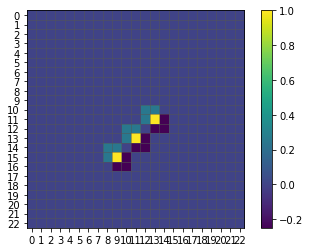

In [491]:
plot_gradient(x0)

In [300]:
def get_pred(x, ch):
    return tf.concat([x[...,:ch], x[...,-1:]], axis=-1)

step 0 - loss : 0.1778 - acc : 0.5556  - best : 0.1778 (0)  - 0.5556 (0)


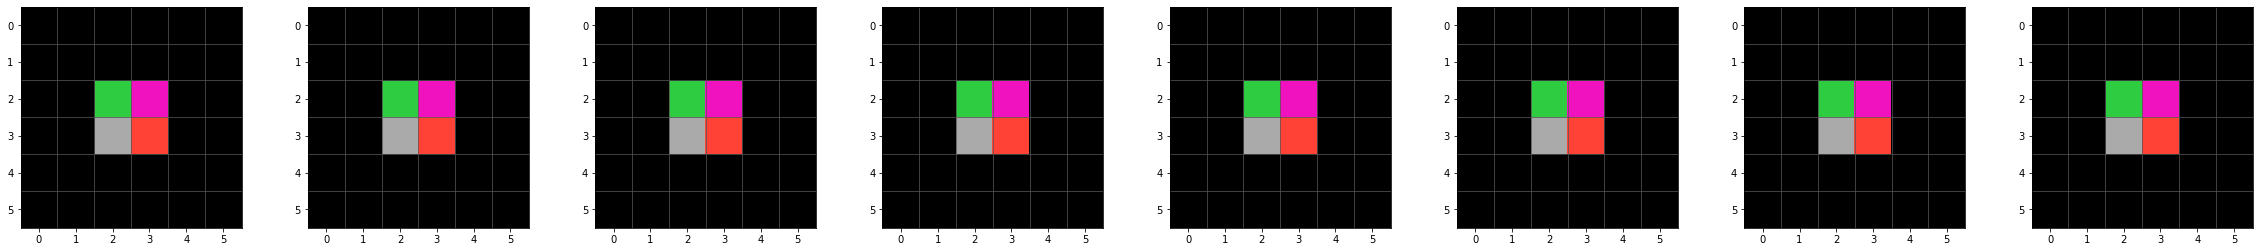

step 1 - loss : 0.2179 - acc : 0.3333  - best : 0.1778 (0)  - 0.5556 (0)
step 2 - loss : 0.1938 - acc : 0.3333  - best : 0.1778 (0)  - 0.5556 (0)
step 3 - loss : 0.1804 - acc : 0.3333  - best : 0.1778 (0)  - 0.5556 (0)
step 4 - loss : 0.1672 - acc : 0.4167  - best : 0.1672 (4)  - 0.5556 (0)


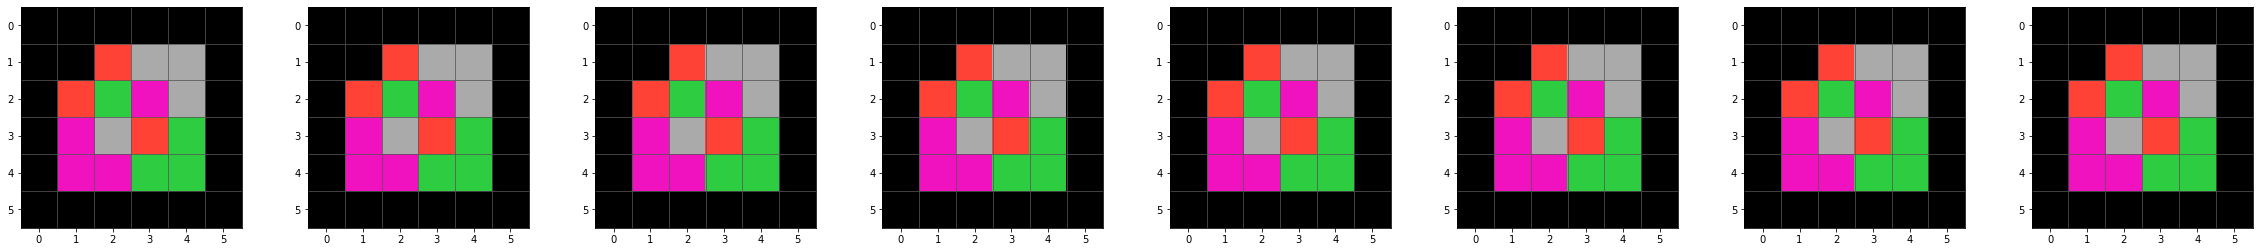

step 5 - loss : 0.1591 - acc : 0.4167  - best : 0.1591 (5)  - 0.5556 (0)


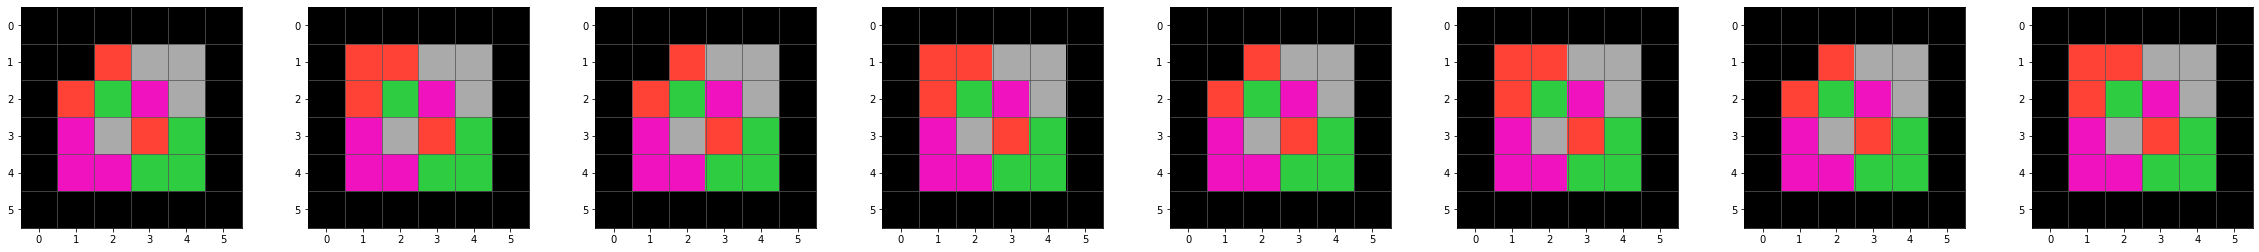

step 6 - loss : 0.1523 - acc : 0.4167  - best : 0.1523 (6)  - 0.5556 (0)


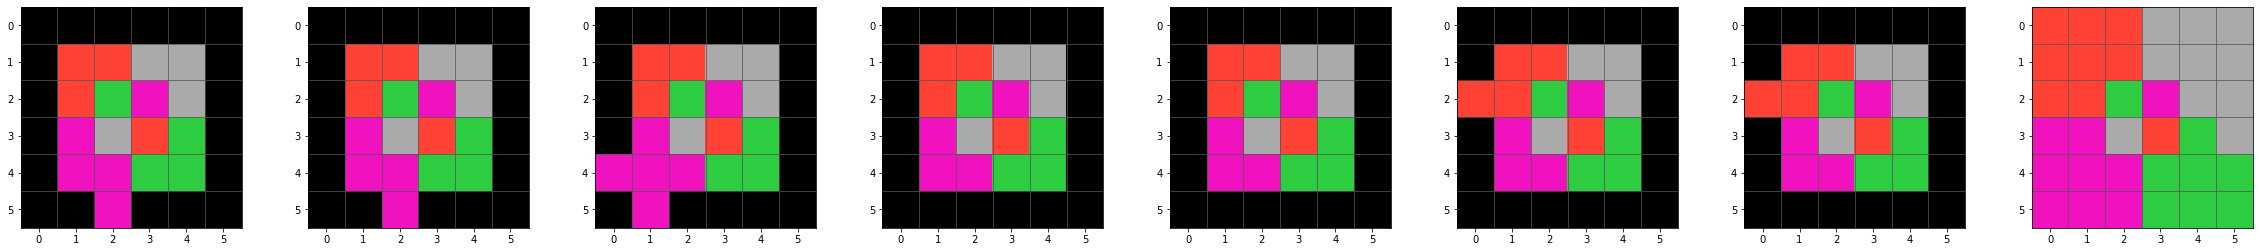

step 7 - loss : 0.1444 - acc : 0.4444  - best : 0.1444 (7)  - 0.5556 (0)


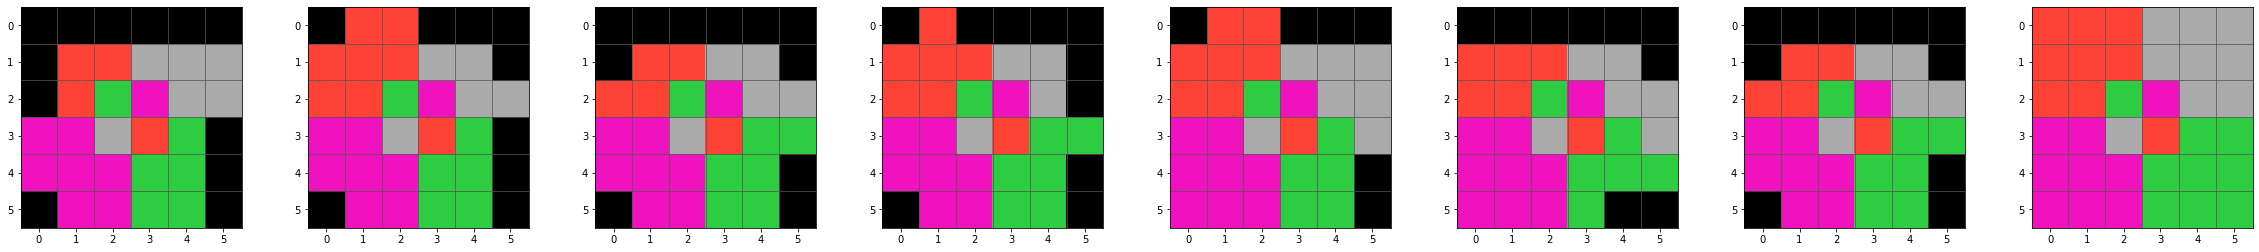

step 8 - loss : 0.1378 - acc : 0.5000  - best : 0.1378 (8)  - 0.5556 (0)


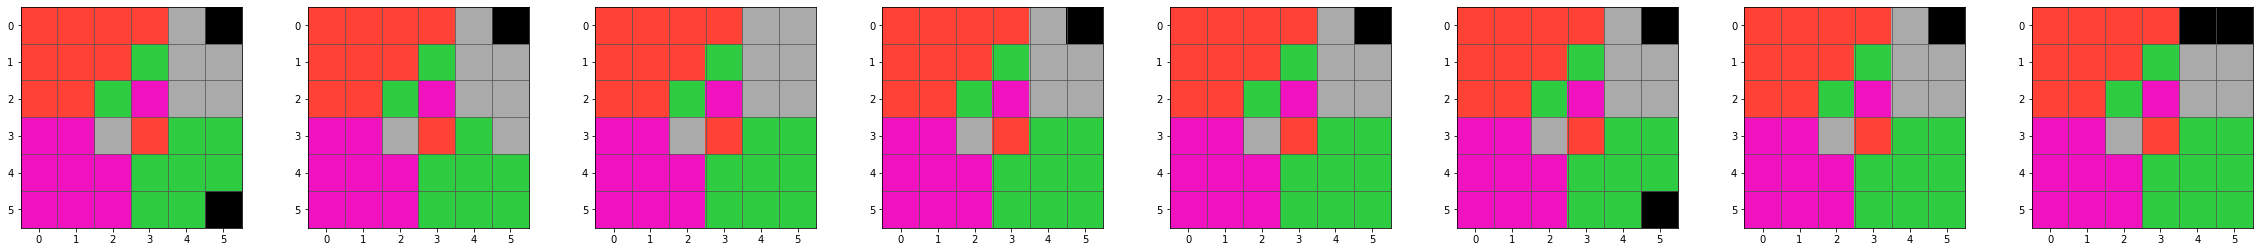

step 9 - loss : 0.1405 - acc : 0.5278  - best : 0.1378 (8)  - 0.5556 (0)
step 10 - loss : 0.1302 - acc : 0.5556  - best : 0.1302 (10)  - 0.5556 (0)


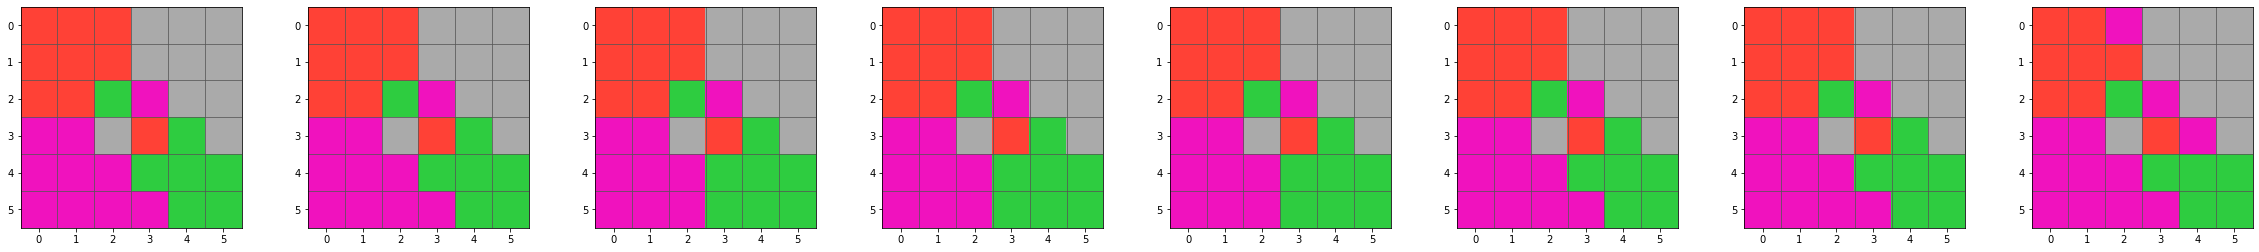

step 11 - loss : 0.1231 - acc : 0.5556  - best : 0.1231 (11)  - 0.5556 (0)


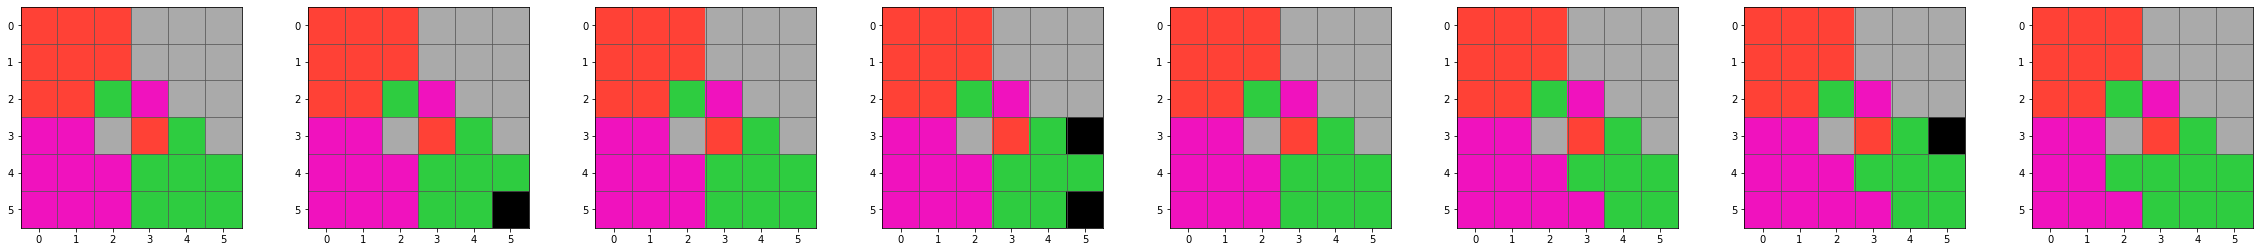

step 12 - loss : 0.0989 - acc : 0.5556  - best : 0.0989 (12)  - 0.5556 (0)


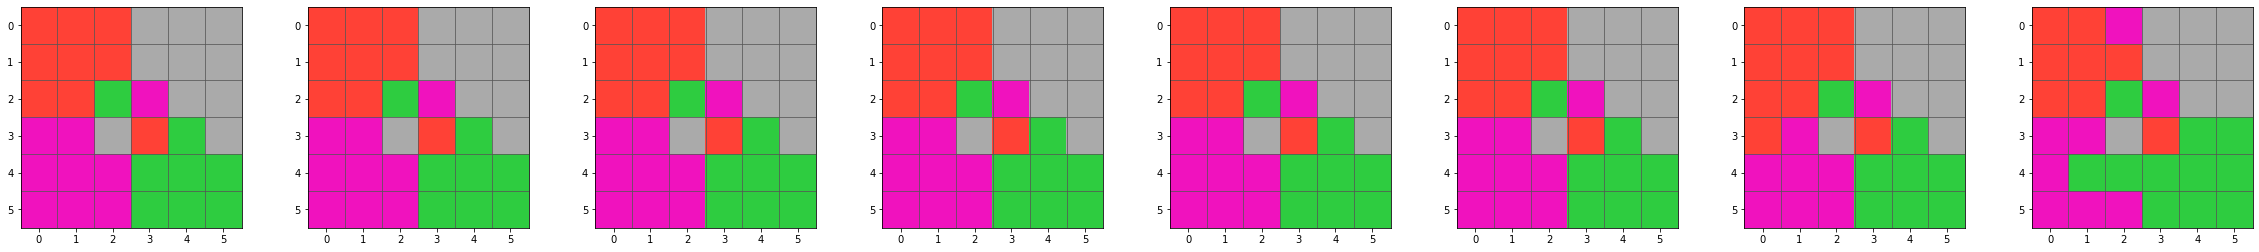

step 13 - loss : 0.1150 - acc : 0.5556  - best : 0.0989 (12)  - 0.5556 (0)
step 14 - loss : 0.0894 - acc : 0.5556  - best : 0.0894 (14)  - 0.5556 (0)


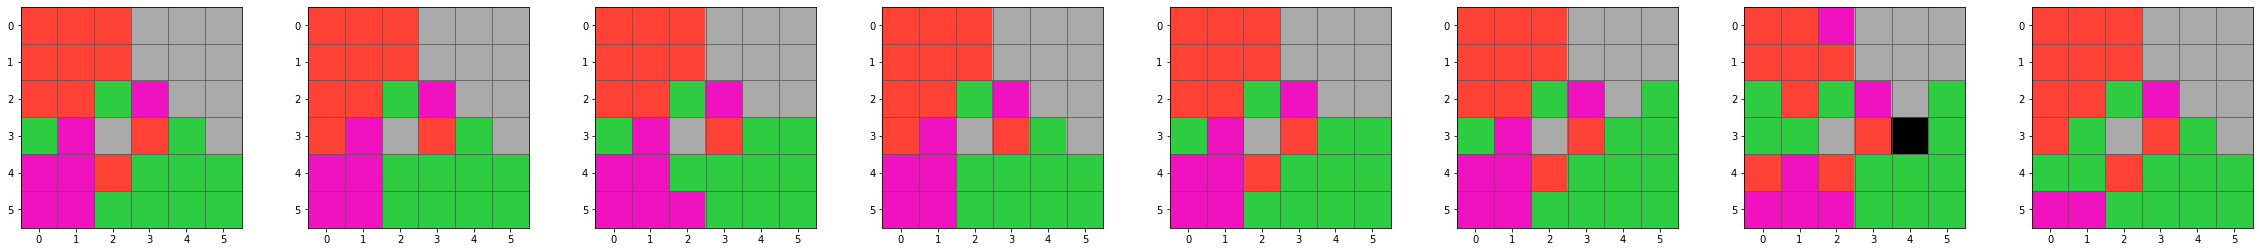

step 15 - loss : 0.0799 - acc : 0.5833  - best : 0.0799 (15)  - 0.5833 (15)


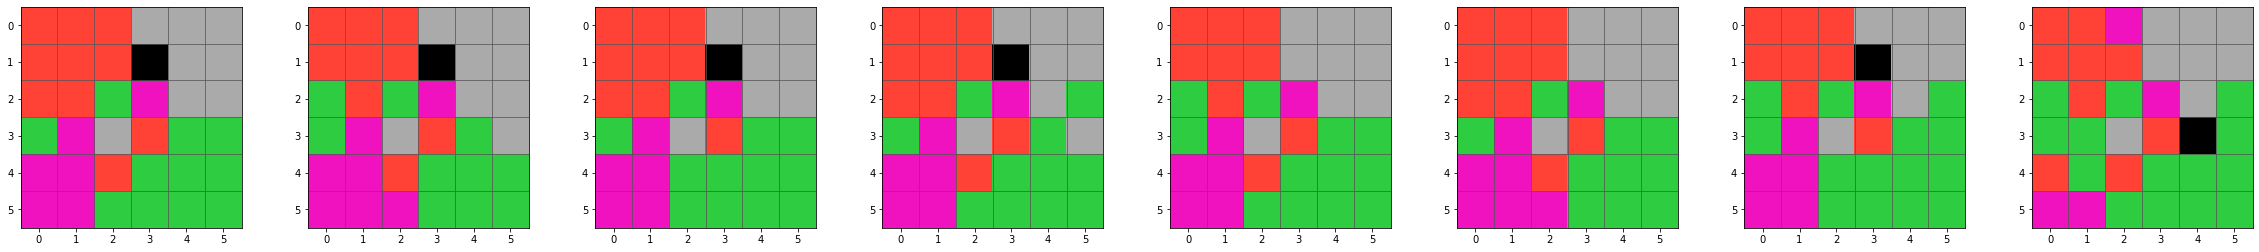

step 16 - loss : 0.0948 - acc : 0.5556  - best : 0.0799 (15)  - 0.5833 (15)
step 17 - loss : 0.0801 - acc : 0.5556  - best : 0.0799 (15)  - 0.5833 (15)
step 18 - loss : 0.0859 - acc : 0.5833  - best : 0.0799 (15)  - 0.5833 (15)
step 19 - loss : 0.0984 - acc : 0.5556  - best : 0.0799 (15)  - 0.5833 (15)
step 20 - loss : 0.0824 - acc : 0.5556  - best : 0.0799 (15)  - 0.5833 (15)
step 21 - loss : 0.0978 - acc : 0.5556  - best : 0.0799 (15)  - 0.5833 (15)
step 22 - loss : 0.1314 - acc : 0.5833  - best : 0.0799 (15)  - 0.5833 (15)
step 23 - loss : 0.1539 - acc : 0.5556  - best : 0.0799 (15)  - 0.5833 (15)
step 24 - loss : 0.1527 - acc : 0.5833  - best : 0.0799 (15)  - 0.5833 (15)
step 25 - loss : 0.1739 - acc : 0.5833  - best : 0.0799 (15)  - 0.5833 (15)
step 26 - loss : 0.1988 - acc : 0.5278  - best : 0.0799 (15)  - 0.5833 (15)
step 27 - loss : 0.1880 - acc : 0.6111  - best : 0.0799 (15)  - 0.6111 (27)


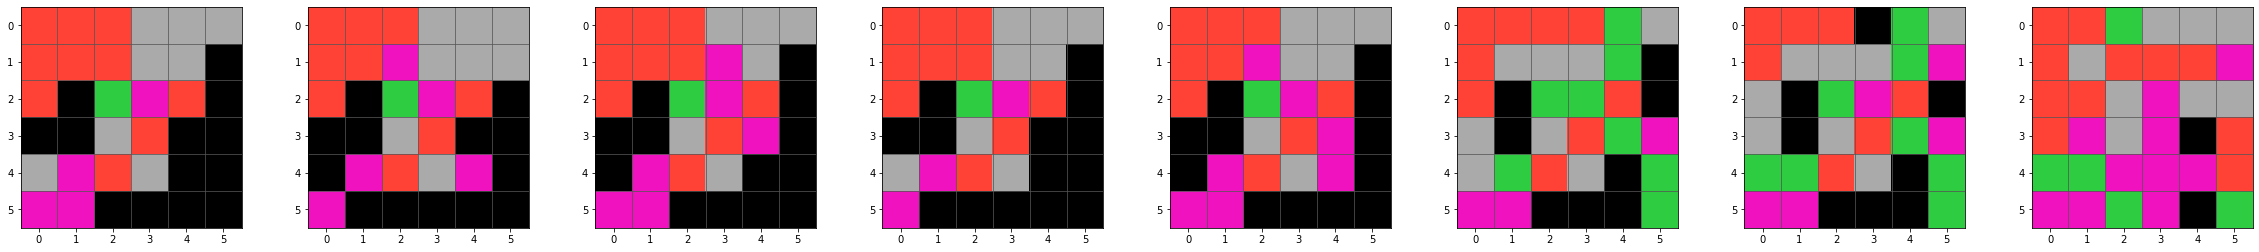

step 28 - loss : 0.1513 - acc : 0.6111  - best : 0.0799 (15)  - 0.6111 (27)
step 29 - loss : 0.1547 - acc : 0.6389  - best : 0.0799 (15)  - 0.6389 (29)


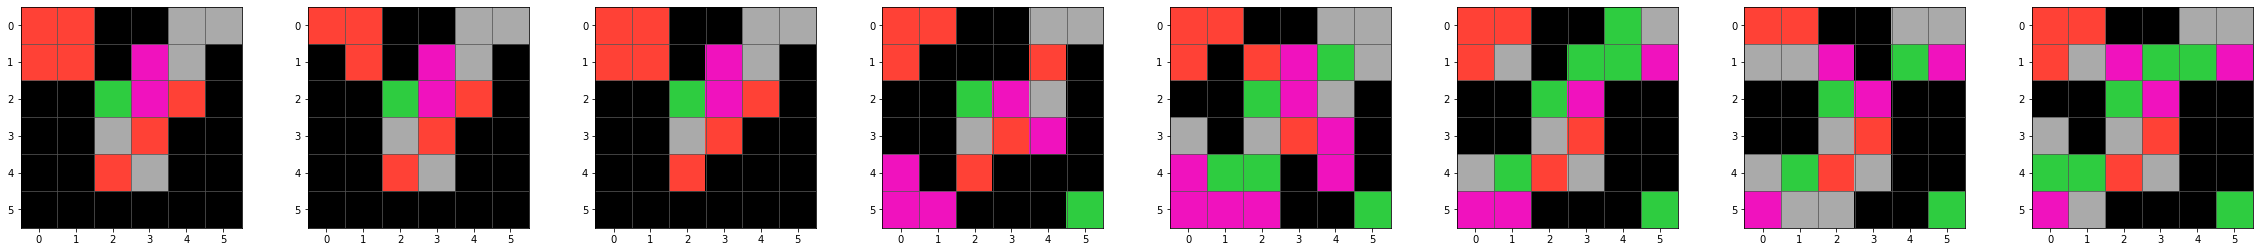

step 30 - loss : 0.1600 - acc : 0.6111  - best : 0.0799 (15)  - 0.6389 (29)
step 31 - loss : 0.1524 - acc : 0.6111  - best : 0.0799 (15)  - 0.6389 (29)
step 32 - loss : 0.1540 - acc : 0.6111  - best : 0.0799 (15)  - 0.6389 (29)
step 33 - loss : 0.1422 - acc : 0.6389  - best : 0.0799 (15)  - 0.6389 (29)
step 34 - loss : 0.1387 - acc : 0.7778  - best : 0.0799 (15)  - 0.7778 (34)


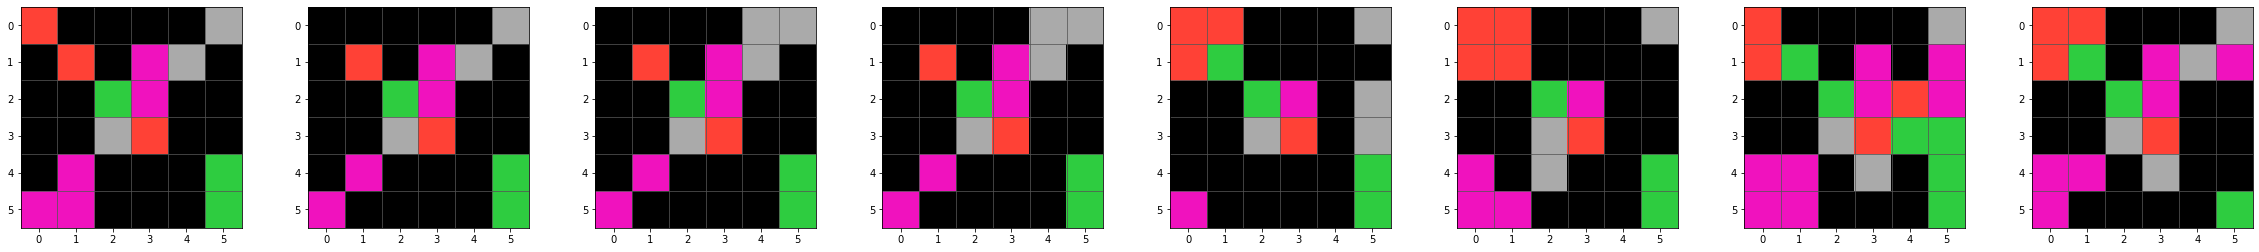

step 35 - loss : 0.1419 - acc : 0.7778  - best : 0.0799 (15)  - 0.7778 (34)
step 36 - loss : 0.1381 - acc : 0.8333  - best : 0.0799 (15)  - 0.8333 (36)


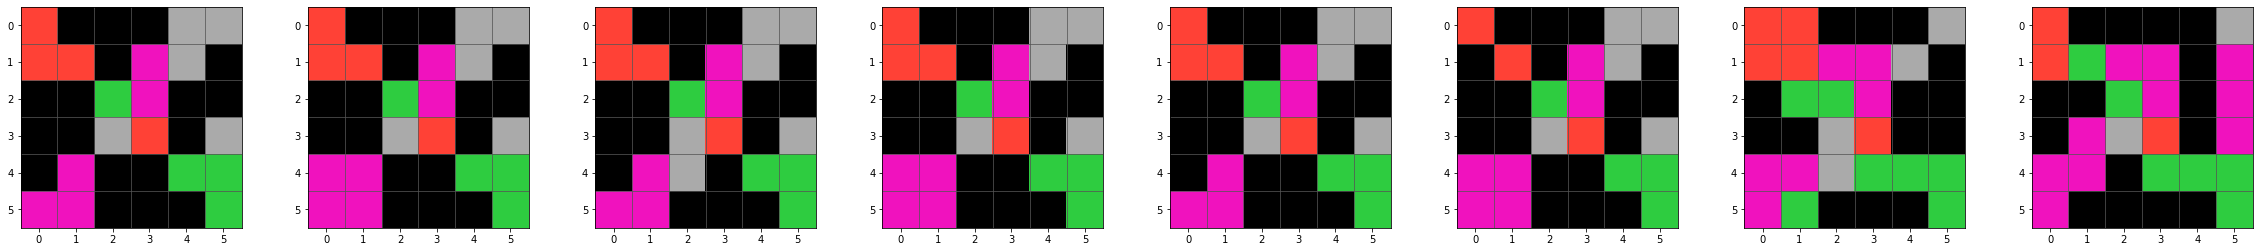

step 37 - loss : 0.1316 - acc : 0.7778  - best : 0.0799 (15)  - 0.8333 (36)
step 38 - loss : 0.1228 - acc : 0.6389  - best : 0.0799 (15)  - 0.8333 (36)
step 39 - loss : 0.1096 - acc : 0.5556  - best : 0.0799 (15)  - 0.8333 (36)
step 40 - loss : 0.1582 - acc : 0.5556  - best : 0.0799 (15)  - 0.8333 (36)
step 41 - loss : 0.1365 - acc : 0.5556  - best : 0.0799 (15)  - 0.8333 (36)
Updating dropout from 0.5 to 0.5358867312681466 at step 0
Updating step_size from 1.0 to 0.95 at step 0
Updating mask_th from 0.1 to 0.11220184543019636 at step 0
step 42 - loss : 0.2099 - acc : 0.5000  - best : 0.0799 (15)  - 0.8333 (36)
step 43 - loss : 0.2492 - acc : 0.5278  - best : 0.0799 (15)  - 0.8333 (36)
step 44 - loss : 0.2697 - acc : 0.5000  - best : 0.0799 (15)  - 0.8333 (36)
step 45 - loss : 0.1303 - acc : 0.5833  - best : 0.0799 (15)  - 0.8333 (36)
step 46 - loss : 0.1609 - acc : 0.5833  - best : 0.0799 (15)  - 0.8333 (36)
step 47 - loss : 0.2482 - acc : 0.5833  - best : 0.0799 (15)  - 0.8333 (36)
s

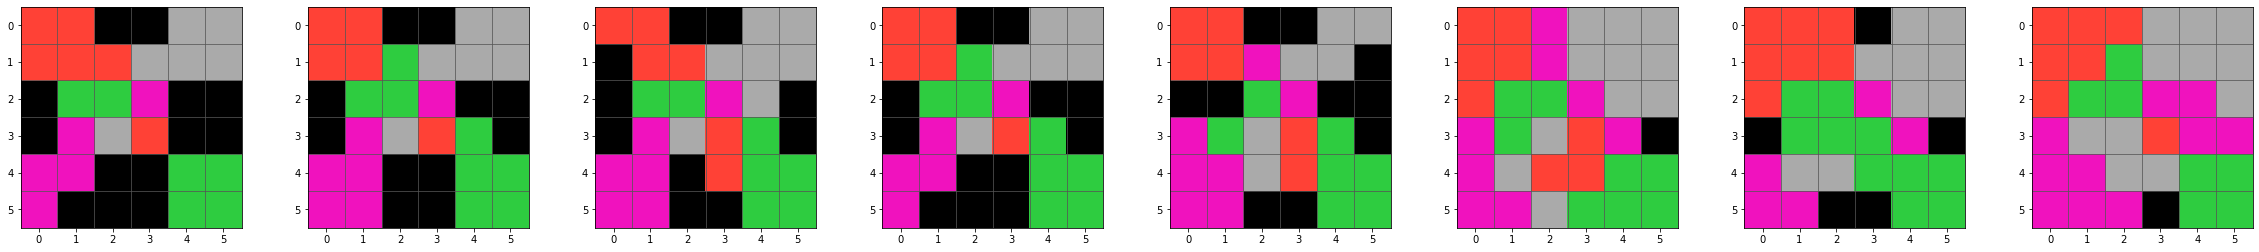

step 60 - loss : 0.1202 - acc : 0.8333  - best : 0.0799 (15)  - 0.8611 (59)
step 61 - loss : 0.0958 - acc : 0.7500  - best : 0.0799 (15)  - 0.8611 (59)
step 62 - loss : 0.0908 - acc : 0.7778  - best : 0.0799 (15)  - 0.8611 (59)
step 63 - loss : 0.1933 - acc : 0.6667  - best : 0.0799 (15)  - 0.8611 (59)
step 64 - loss : 0.1135 - acc : 0.6389  - best : 0.0799 (15)  - 0.8611 (59)
step 65 - loss : 0.0818 - acc : 0.6667  - best : 0.0799 (15)  - 0.8611 (59)
step 66 - loss : 0.0986 - acc : 0.6389  - best : 0.0799 (15)  - 0.8611 (59)
step 67 - loss : 0.1354 - acc : 0.5833  - best : 0.0799 (15)  - 0.8611 (59)
Updating dropout from 0.5358867312681466 to 0.5703818579342118 at step 0
Updating step_size from 0.95 to 0.9025 at step 0
Updating mask_th from 0.11220184543019636 to 0.12516992730317253 at step 0
step 68 - loss : 0.1137 - acc : 0.6111  - best : 0.0799 (15)  - 0.8611 (59)
step 69 - loss : 0.1092 - acc : 0.5556  - best : 0.0799 (15)  - 0.8611 (59)
step 70 - loss : 0.3366 - acc : 0.5556  - b

step 156 - loss : 0.1065 - acc : 0.5833  - best : 0.0799 (15)  - 0.8611 (59)
step 157 - loss : 0.0949 - acc : 0.5556  - best : 0.0799 (15)  - 0.8611 (59)
step 158 - loss : 0.1079 - acc : 0.5556  - best : 0.0799 (15)  - 0.8611 (59)
step 159 - loss : 0.1507 - acc : 0.5556  - best : 0.0799 (15)  - 0.8611 (59)
step 160 - loss : 0.0956 - acc : 0.5556  - best : 0.0799 (15)  - 0.8611 (59)
step 161 - loss : 0.1064 - acc : 0.5556  - best : 0.0799 (15)  - 0.8611 (59)
step 162 - loss : 0.1041 - acc : 0.5833  - best : 0.0799 (15)  - 0.8611 (59)
step 163 - loss : 0.1108 - acc : 0.6667  - best : 0.0799 (15)  - 0.8611 (59)
step 164 - loss : 0.1497 - acc : 0.6667  - best : 0.0799 (15)  - 0.8611 (59)
step 165 - loss : 0.1083 - acc : 0.6667  - best : 0.0799 (15)  - 0.8611 (59)
step 166 - loss : 0.1077 - acc : 0.6389  - best : 0.0799 (15)  - 0.8611 (59)
step 167 - loss : 0.1192 - acc : 0.6389  - best : 0.0799 (15)  - 0.8611 (59)
step 168 - loss : 0.1411 - acc : 0.6111  - best : 0.0799 (15)  - 0.8611 (59)

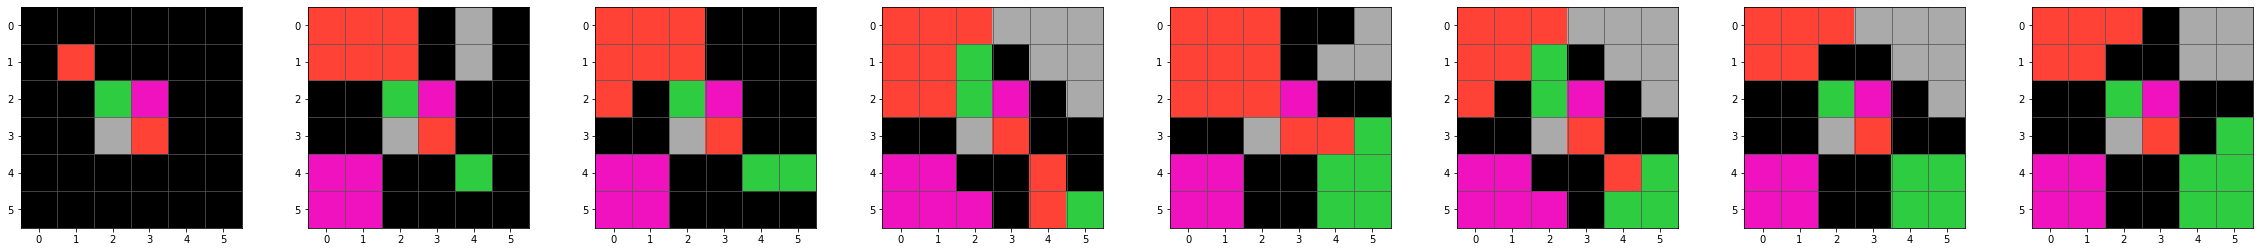

step 203 - loss : 0.1277 - acc : 0.5556  - best : 0.0763 (202)  - 0.8611 (59)
step 204 - loss : 0.1117 - acc : 0.6111  - best : 0.0763 (202)  - 0.8611 (59)
step 205 - loss : 0.1029 - acc : 0.5556  - best : 0.0763 (202)  - 0.8611 (59)
step 206 - loss : 0.1141 - acc : 0.5556  - best : 0.0763 (202)  - 0.8611 (59)
step 207 - loss : 0.0988 - acc : 0.5556  - best : 0.0763 (202)  - 0.8611 (59)
step 208 - loss : 0.1132 - acc : 0.6111  - best : 0.0763 (202)  - 0.8611 (59)
step 209 - loss : 0.1363 - acc : 0.6111  - best : 0.0763 (202)  - 0.8611 (59)
step 210 - loss : 0.0898 - acc : 0.6389  - best : 0.0763 (202)  - 0.8611 (59)
step 211 - loss : 0.0943 - acc : 0.6667  - best : 0.0763 (202)  - 0.8611 (59)
step 212 - loss : 0.1204 - acc : 0.6111  - best : 0.0763 (202)  - 0.8611 (59)
step 213 - loss : 0.0933 - acc : 0.6389  - best : 0.0763 (202)  - 0.8611 (59)
step 214 - loss : 0.0903 - acc : 0.6389  - best : 0.0763 (202)  - 0.8611 (59)
step 215 - loss : 0.1356 - acc : 0.6389  - best : 0.0763 (202)  

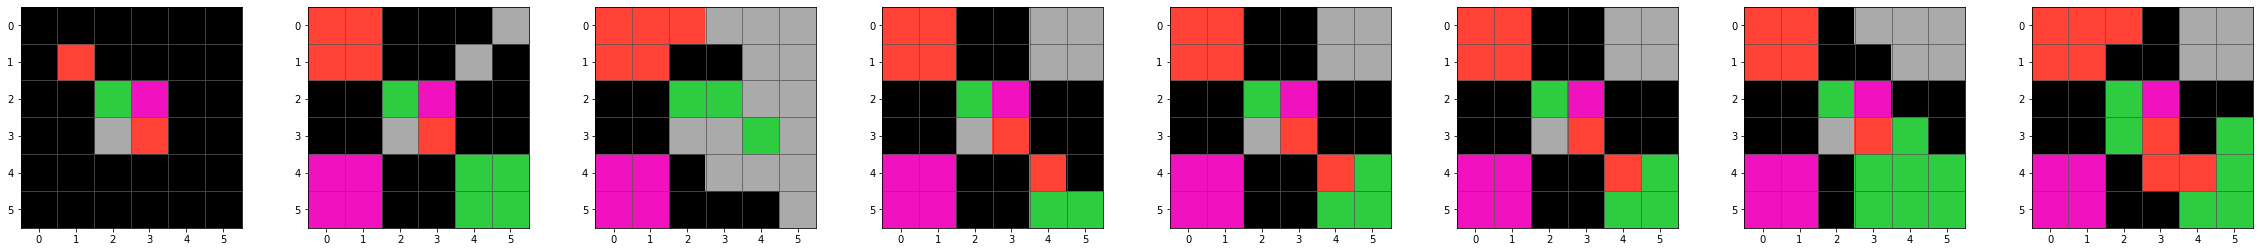

step 235 - loss : 0.1189 - acc : 0.6111  - best : 0.0725 (234)  - 0.8611 (59)
step 236 - loss : 0.1036 - acc : 0.6111  - best : 0.0725 (234)  - 0.8611 (59)
step 237 - loss : 0.0986 - acc : 0.5833  - best : 0.0725 (234)  - 0.8611 (59)
step 238 - loss : 0.0806 - acc : 0.6111  - best : 0.0725 (234)  - 0.8611 (59)
step 239 - loss : 0.1041 - acc : 0.6111  - best : 0.0725 (234)  - 0.8611 (59)
step 240 - loss : 0.1186 - acc : 0.6389  - best : 0.0725 (234)  - 0.8611 (59)
step 241 - loss : 0.0956 - acc : 0.6389  - best : 0.0725 (234)  - 0.8611 (59)
step 242 - loss : 0.0929 - acc : 0.6389  - best : 0.0725 (234)  - 0.8611 (59)
step 243 - loss : 0.0926 - acc : 0.6667  - best : 0.0725 (234)  - 0.8611 (59)
step 244 - loss : 0.1112 - acc : 0.6667  - best : 0.0725 (234)  - 0.8611 (59)
step 245 - loss : 0.0953 - acc : 0.6667  - best : 0.0725 (234)  - 0.8611 (59)
step 246 - loss : 0.1264 - acc : 0.6667  - best : 0.0725 (234)  - 0.8611 (59)
step 247 - loss : 0.0861 - acc : 0.6389  - best : 0.0725 (234)  

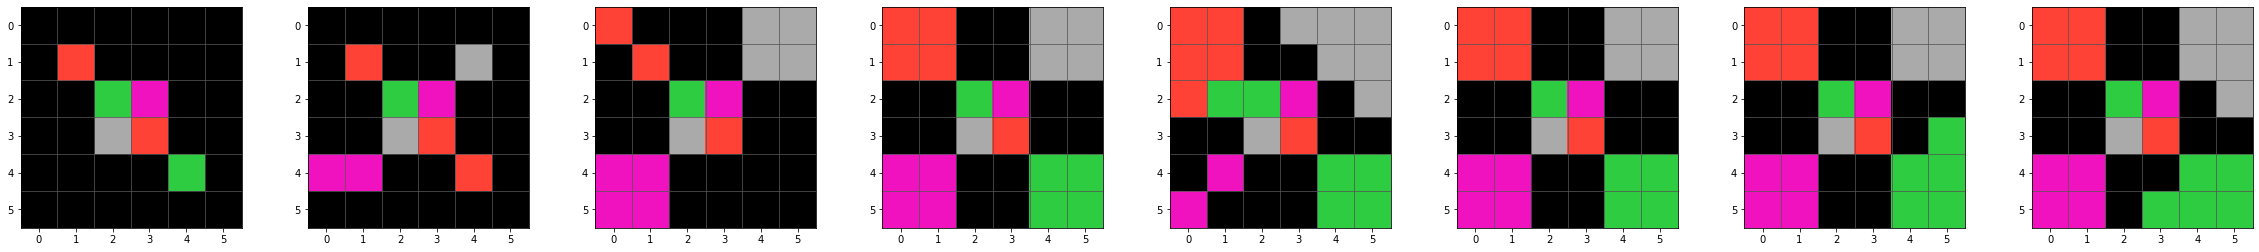

step 259 - loss : 0.1166 - acc : 0.6111  - best : 0.0716 (258)  - 0.8611 (59)
step 260 - loss : 0.1113 - acc : 0.5556  - best : 0.0716 (258)  - 0.8611 (59)
step 261 - loss : 0.1252 - acc : 0.6389  - best : 0.0716 (258)  - 0.8611 (59)
step 262 - loss : 0.1574 - acc : 0.5833  - best : 0.0716 (258)  - 0.8611 (59)
step 263 - loss : 0.0831 - acc : 0.5556  - best : 0.0716 (258)  - 0.8611 (59)
step 264 - loss : 0.1001 - acc : 0.5833  - best : 0.0716 (258)  - 0.8611 (59)
step 265 - loss : 0.0995 - acc : 0.5833  - best : 0.0716 (258)  - 0.8611 (59)
step 266 - loss : 0.1152 - acc : 0.5833  - best : 0.0716 (258)  - 0.8611 (59)
step 267 - loss : 0.0869 - acc : 0.5833  - best : 0.0716 (258)  - 0.8611 (59)
step 268 - loss : 0.0750 - acc : 0.6389  - best : 0.0716 (258)  - 0.8611 (59)
step 269 - loss : 0.0872 - acc : 0.5556  - best : 0.0716 (258)  - 0.8611 (59)
step 270 - loss : 0.0785 - acc : 0.6389  - best : 0.0716 (258)  - 0.8611 (59)
step 271 - loss : 0.0651 - acc : 0.6389  - best : 0.0651 (271)  

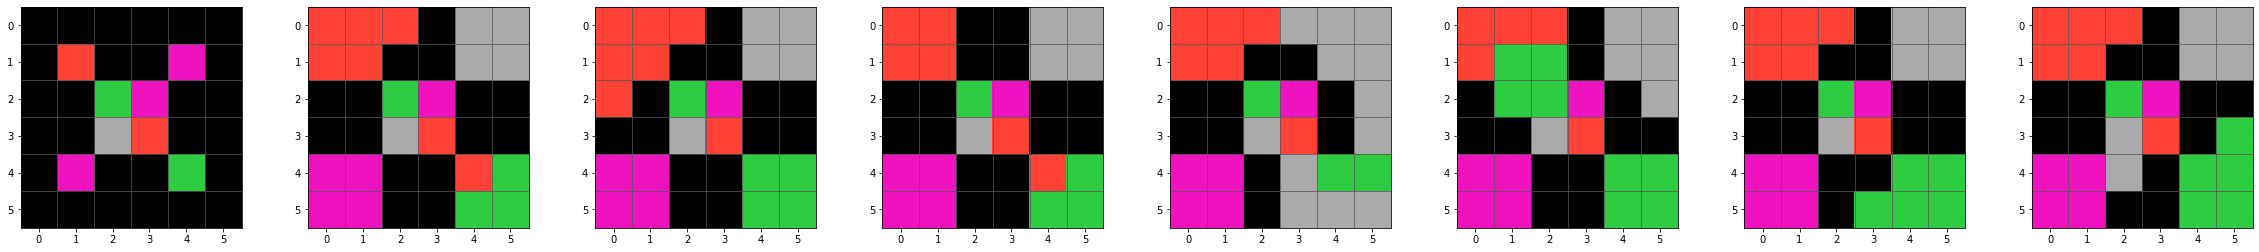

step 272 - loss : 0.0932 - acc : 0.6667  - best : 0.0651 (271)  - 0.8611 (59)
step 273 - loss : 0.1874 - acc : 0.6389  - best : 0.0651 (271)  - 0.8611 (59)
step 274 - loss : 0.1073 - acc : 0.6389  - best : 0.0651 (271)  - 0.8611 (59)
step 275 - loss : 0.1811 - acc : 0.6667  - best : 0.0651 (271)  - 0.8611 (59)
step 276 - loss : 0.1778 - acc : 0.6389  - best : 0.0651 (271)  - 0.8611 (59)
step 277 - loss : 0.1617 - acc : 0.6389  - best : 0.0651 (271)  - 0.8611 (59)
step 278 - loss : 0.1118 - acc : 0.6389  - best : 0.0651 (271)  - 0.8611 (59)
step 279 - loss : 0.0958 - acc : 0.6389  - best : 0.0651 (271)  - 0.8611 (59)
step 280 - loss : 0.1394 - acc : 0.6111  - best : 0.0651 (271)  - 0.8611 (59)
step 281 - loss : 0.0865 - acc : 0.5556  - best : 0.0651 (271)  - 0.8611 (59)
step 282 - loss : 0.1108 - acc : 0.5556  - best : 0.0651 (271)  - 0.8611 (59)
step 283 - loss : 0.1040 - acc : 0.5556  - best : 0.0651 (271)  - 0.8611 (59)
step 284 - loss : 0.1077 - acc : 0.5556  - best : 0.0651 (271)  

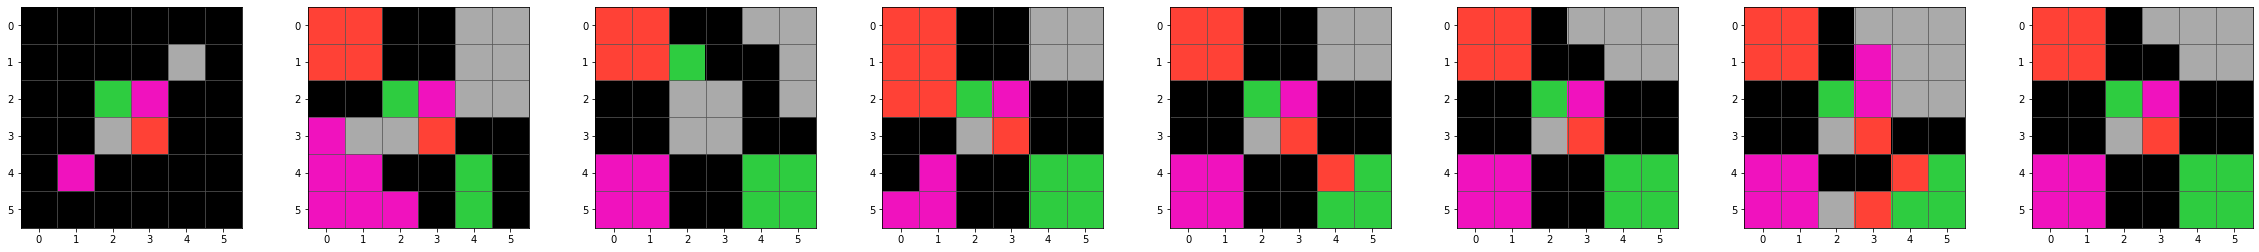

step 333 - loss : 0.0890 - acc : 0.5833  - best : 0.0642 (332)  - 0.8611 (59)
step 334 - loss : 0.1103 - acc : 0.5833  - best : 0.0642 (332)  - 0.8611 (59)
step 335 - loss : 0.1512 - acc : 0.6389  - best : 0.0642 (332)  - 0.8611 (59)
step 336 - loss : 0.1274 - acc : 0.6389  - best : 0.0642 (332)  - 0.8611 (59)
step 337 - loss : 0.0975 - acc : 0.6111  - best : 0.0642 (332)  - 0.8611 (59)
step 338 - loss : 0.1061 - acc : 0.5833  - best : 0.0642 (332)  - 0.8611 (59)
step 339 - loss : 0.1086 - acc : 0.6111  - best : 0.0642 (332)  - 0.8611 (59)
step 340 - loss : 0.1152 - acc : 0.6111  - best : 0.0642 (332)  - 0.8611 (59)
step 341 - loss : 0.0951 - acc : 0.6111  - best : 0.0642 (332)  - 0.8611 (59)
step 342 - loss : 0.1185 - acc : 0.5556  - best : 0.0642 (332)  - 0.8611 (59)
step 343 - loss : 0.0955 - acc : 0.5556  - best : 0.0642 (332)  - 0.8611 (59)
step 344 - loss : 0.0975 - acc : 0.6111  - best : 0.0642 (332)  - 0.8611 (59)
step 345 - loss : 0.0825 - acc : 0.6111  - best : 0.0642 (332)  

step 430 - loss : 0.1039 - acc : 0.5556  - best : 0.0642 (332)  - 0.8611 (59)
step 431 - loss : 0.0874 - acc : 0.5556  - best : 0.0642 (332)  - 0.8611 (59)
step 432 - loss : 0.0803 - acc : 0.5556  - best : 0.0642 (332)  - 0.8611 (59)
step 433 - loss : 0.0733 - acc : 0.5833  - best : 0.0642 (332)  - 0.8611 (59)
step 434 - loss : 0.0691 - acc : 0.5556  - best : 0.0642 (332)  - 0.8611 (59)
step 435 - loss : 0.0601 - acc : 0.5556  - best : 0.0601 (435)  - 0.8611 (59)


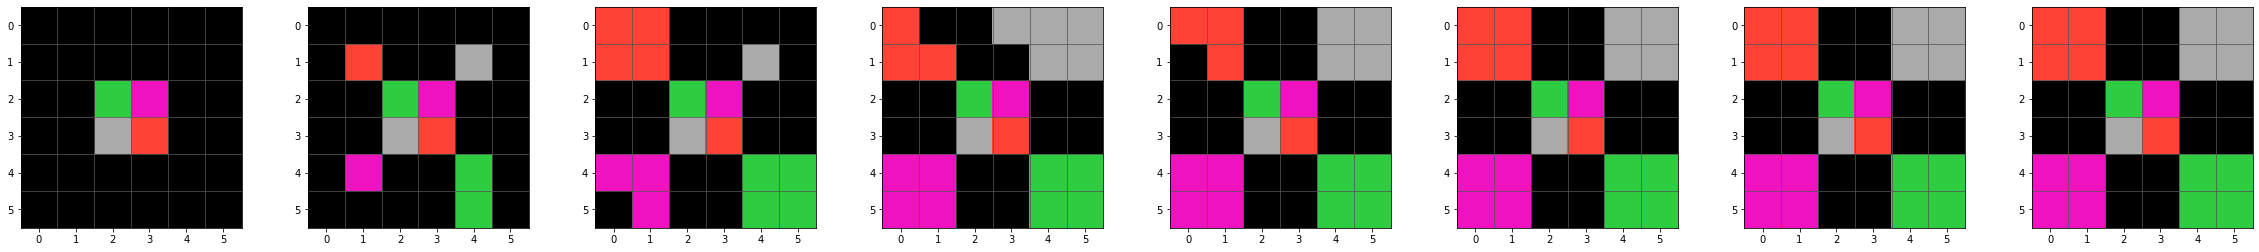

step 436 - loss : 0.1220 - acc : 0.5556  - best : 0.0601 (435)  - 0.8611 (59)
step 437 - loss : 0.1202 - acc : 0.5556  - best : 0.0601 (435)  - 0.8611 (59)
step 438 - loss : 0.0828 - acc : 0.5556  - best : 0.0601 (435)  - 0.8611 (59)
step 439 - loss : 0.0877 - acc : 0.5556  - best : 0.0601 (435)  - 0.8611 (59)
step 440 - loss : 0.1114 - acc : 0.5556  - best : 0.0601 (435)  - 0.8611 (59)
step 441 - loss : 0.0706 - acc : 0.5833  - best : 0.0601 (435)  - 0.8611 (59)
step 442 - loss : 0.0936 - acc : 0.6111  - best : 0.0601 (435)  - 0.8611 (59)
step 443 - loss : 0.0606 - acc : 0.5833  - best : 0.0601 (435)  - 0.8611 (59)
step 444 - loss : 0.0759 - acc : 0.6111  - best : 0.0601 (435)  - 0.8611 (59)
step 445 - loss : 0.1021 - acc : 0.5833  - best : 0.0601 (435)  - 0.8611 (59)
step 446 - loss : 0.1100 - acc : 0.5833  - best : 0.0601 (435)  - 0.8611 (59)
step 447 - loss : 0.0842 - acc : 0.5833  - best : 0.0601 (435)  - 0.8611 (59)
step 448 - loss : 0.1040 - acc : 0.6111  - best : 0.0601 (435)  

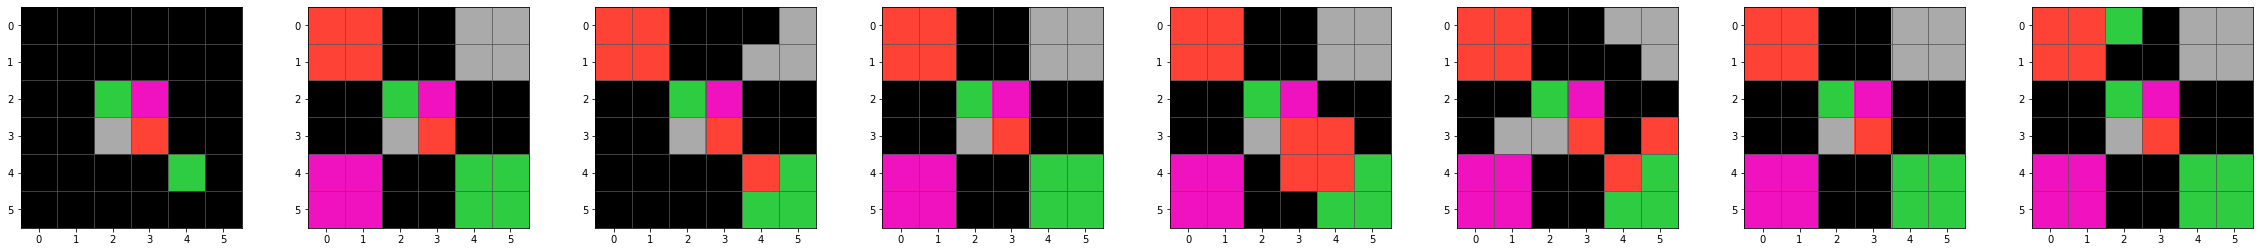

step 466 - loss : 0.1055 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 467 - loss : 0.1082 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 468 - loss : 0.0813 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 469 - loss : 0.1079 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 470 - loss : 0.0799 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 471 - loss : 0.0691 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 472 - loss : 0.0694 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 473 - loss : 0.0682 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 474 - loss : 0.0786 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 475 - loss : 0.0952 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 476 - loss : 0.1029 - acc : 0.5556  - best : 0.0575 (465)  - 0.8611 (59)
step 477 - loss : 0.0754 - acc : 0.5833  - best : 0.0575 (465)  - 0.8611 (59)
step 478 - loss : 0.0852 - acc : 0.5556  - best : 0.0575 (465)  

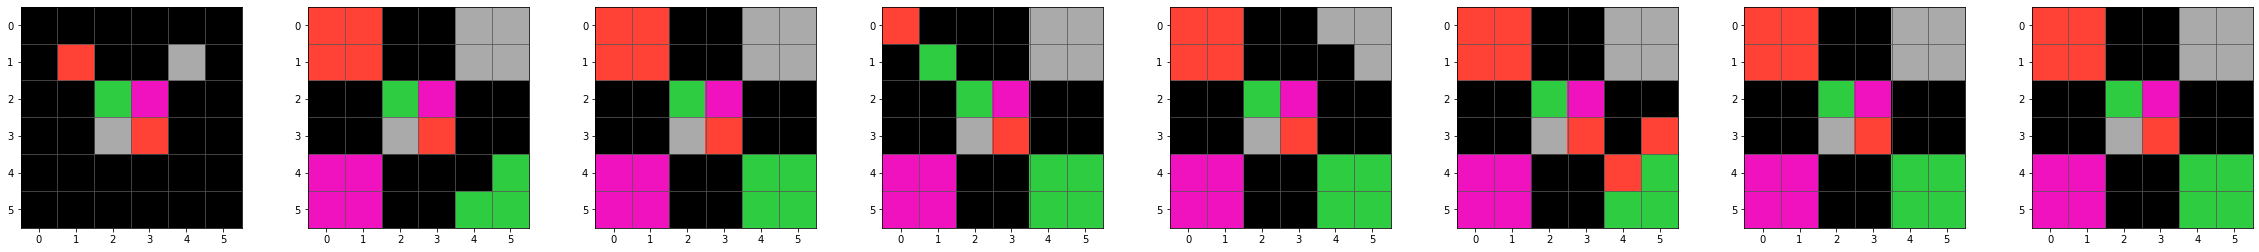

step 489 - loss : 0.0787 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 490 - loss : 0.1210 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 491 - loss : 0.0907 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 492 - loss : 0.0698 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 493 - loss : 0.0694 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 494 - loss : 0.0950 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 495 - loss : 0.0804 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 496 - loss : 0.0884 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 497 - loss : 0.0833 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 498 - loss : 0.0864 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 499 - loss : 0.0920 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 500 - loss : 0.0618 - acc : 0.5556  - best : 0.0504 (488)  - 0.8611 (59)
step 501 - loss : 0.0937 - acc : 0.5556  - best : 0.0504 (488)  

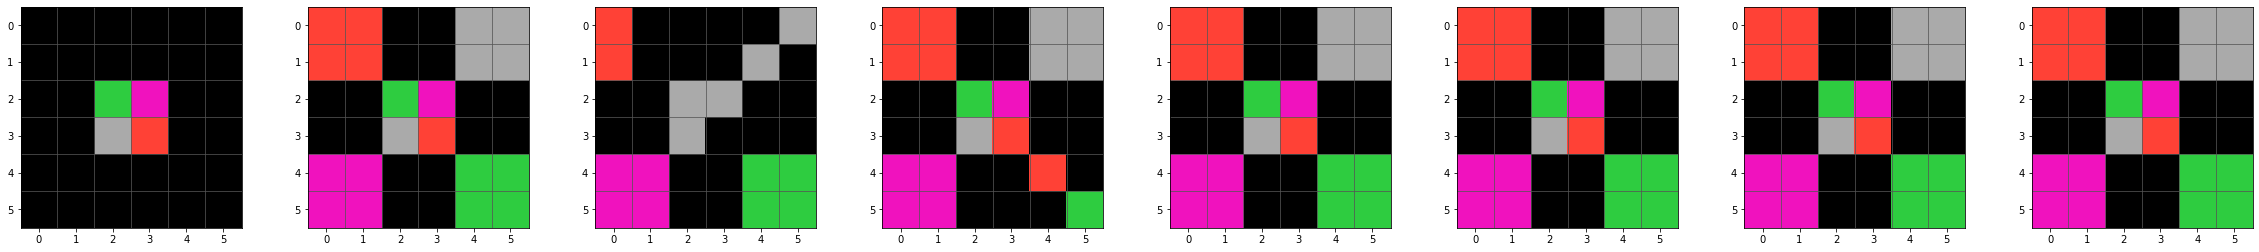

step 540 - loss : 0.0687 - acc : 0.5556  - best : 0.0452 (539)  - 0.8611 (59)
step 541 - loss : 0.0999 - acc : 0.5833  - best : 0.0452 (539)  - 0.8611 (59)
step 542 - loss : 0.0933 - acc : 0.5556  - best : 0.0452 (539)  - 0.8611 (59)
step 543 - loss : 0.0651 - acc : 0.5556  - best : 0.0452 (539)  - 0.8611 (59)
step 544 - loss : 0.0866 - acc : 0.5556  - best : 0.0452 (539)  - 0.8611 (59)
step 545 - loss : 0.0671 - acc : 0.5833  - best : 0.0452 (539)  - 0.8611 (59)
step 546 - loss : 0.0814 - acc : 0.5833  - best : 0.0452 (539)  - 0.8611 (59)
step 547 - loss : 0.0844 - acc : 0.5833  - best : 0.0452 (539)  - 0.8611 (59)
step 548 - loss : 0.0947 - acc : 0.5833  - best : 0.0452 (539)  - 0.8611 (59)
step 549 - loss : 0.0672 - acc : 0.5833  - best : 0.0452 (539)  - 0.8611 (59)
step 550 - loss : 0.0811 - acc : 0.5556  - best : 0.0452 (539)  - 0.8611 (59)
step 551 - loss : 0.0755 - acc : 0.5556  - best : 0.0452 (539)  - 0.8611 (59)
step 552 - loss : 0.0827 - acc : 0.5556  - best : 0.0452 (539)  

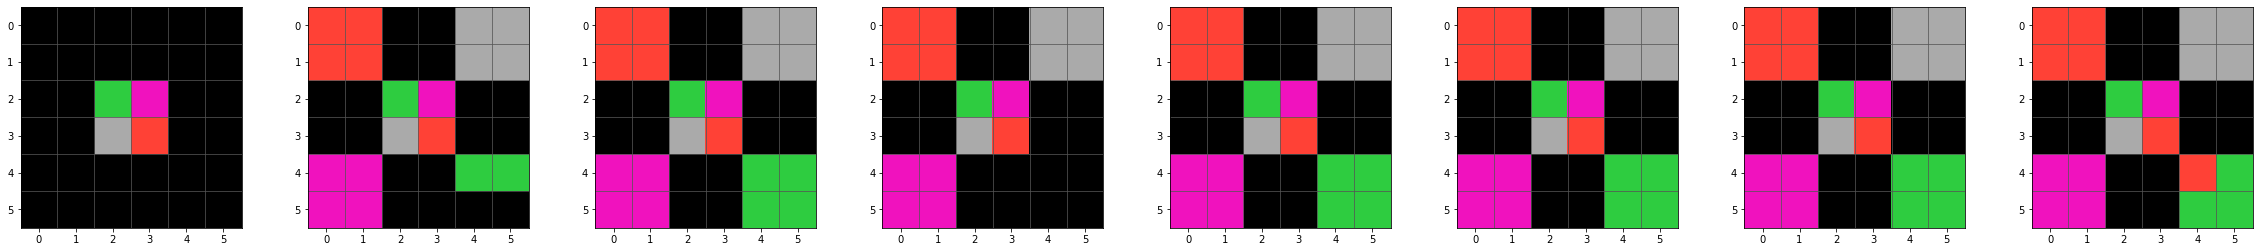

step 594 - loss : 0.0776 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 595 - loss : 0.0910 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 596 - loss : 0.0685 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 597 - loss : 0.0630 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 598 - loss : 0.0504 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 599 - loss : 0.1010 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 600 - loss : 0.0686 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 601 - loss : 0.0783 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 602 - loss : 0.0678 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 603 - loss : 0.0808 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 604 - loss : 0.0712 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 605 - loss : 0.0708 - acc : 0.5556  - best : 0.0436 (593)  - 0.8611 (59)
step 606 - loss : 0.0648 - acc : 0.5556  - best : 0.0436 (593)  

KeyboardInterrupt: 

In [303]:
x = input_train.copy()
# x /= np.sum(x, axis=0).sum(axis=0).sum(axis=0)

input_states = []
output_states = []
grads_x = []
grads_w = []
losses = []
accs = []

best_loss = np.inf
best_acc = 0
best_loss_step = 0
best_acc_step = 0

steps = 1000
sim_range = range(64, 96)
new_best = False

for _ in range(steps):
    step = optim.iterations.numpy()
    
    step_input_states = []
    step_output_states = []
    step_grads_x = []
    step_grads_w = []
    step_losses = []
    step_accs = []

    best_sim = np.inf
    sim_wait = 0
    sim_cooldown = 0
    
    sims = np.random.choice(sim_range)
    
    # update inputs when using sampler
    if use_sampler:
        batch = sampler.sample(batch_size)
        x = batch.data
        loss_rank = mean_squared_error(output_train, get_pred(x, num_channels)).numpy().argsort()[::-1]
        x = x[loss_rank]
        x[:1] = input_train.copy()
    
    for _ in range(sims):
        step_input_states.append(x)
        
        with tf.GradientTape(persistent=True) as g:
            x = model(x, 
                      dropout=dropout.value,
                      step_size=step_size.value, 
                      mask_th=mask_th)
            loss = tf.reduce_mean(mean_squared_error(output_train, get_pred(x, num_channels)))
        
        # backprop
        gw = g.gradient(loss, model.weights)
        gw = [g/(tf.norm(g)+1e-8) for g in gw]
        gx = g.gradient(loss, x)
        acc = score_ca(output_train, get_pred(x, num_channels), ch_to_symbols, mask_th=mask_th)
        
        step_output_states.append(x.numpy())
        step_losses.append(loss.numpy())
        step_grads_w.append(gw)
        step_grads_x.append(gx.numpy())
        step_accs.append(acc)
        
#         if loss < best_sim:
#             best_sim = loss
#         else:
#             sim_cooldown += 1
#             if sim_cooldown >= cooldown:
#                 sim_wait += 1 
#                 if sim_wait > patience:
#                     break
                    
    
    # apply gradients and score response
    optim.apply_gradients(zip(gw, model.weights))
    acc = score_ca(output_train, get_pred(x, num_channels), ch_to_symbols, mask_th=mask_th)
    
    if loss < best_loss:
        best_loss = loss
        best_loss_step = step
        new_best = True
        save_model(model, os.path.join(ckpt_dir, f'{step:04d}_{loss}_{acc}'), sched)
    if acc > best_acc:
        best_acc = acc
        best_acc_step = step
        new_best = True
        save_model(model, os.path.join(ckpt_dir, f'{step:04d}_{loss}_{acc}'), sched)
    
    print(f'step {step} - loss : {loss.numpy():.4f} - acc : {acc:.4f} '
          f' - best : {best_loss:.4f} ({best_loss_step}) '
          f' - {best_acc:.4f} ({best_acc_step})')
    
    if new_best:
        plot_grids(get_pred(x, num_channels), [ch_to_symbols[0]] * len(x), mask_th)
        
    sched(loss, step)
    
    input_states.append(step_input_states)
    output_states.append(step_output_states)
    grads_x.append(step_grads_x)
    grads_w.append(step_grads_w)
    losses.append(step_losses)
    accs.append(step_accs)
    
    if use_sampler:
        batch.update(x)
    else:
        x = input_train.copy()
    
    new_best = False

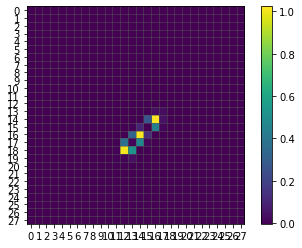

In [265]:
plot_gradient(output_states[-1][-1][0,...,1])

TypeError: Invalid shape (2, 28, 28) for image data

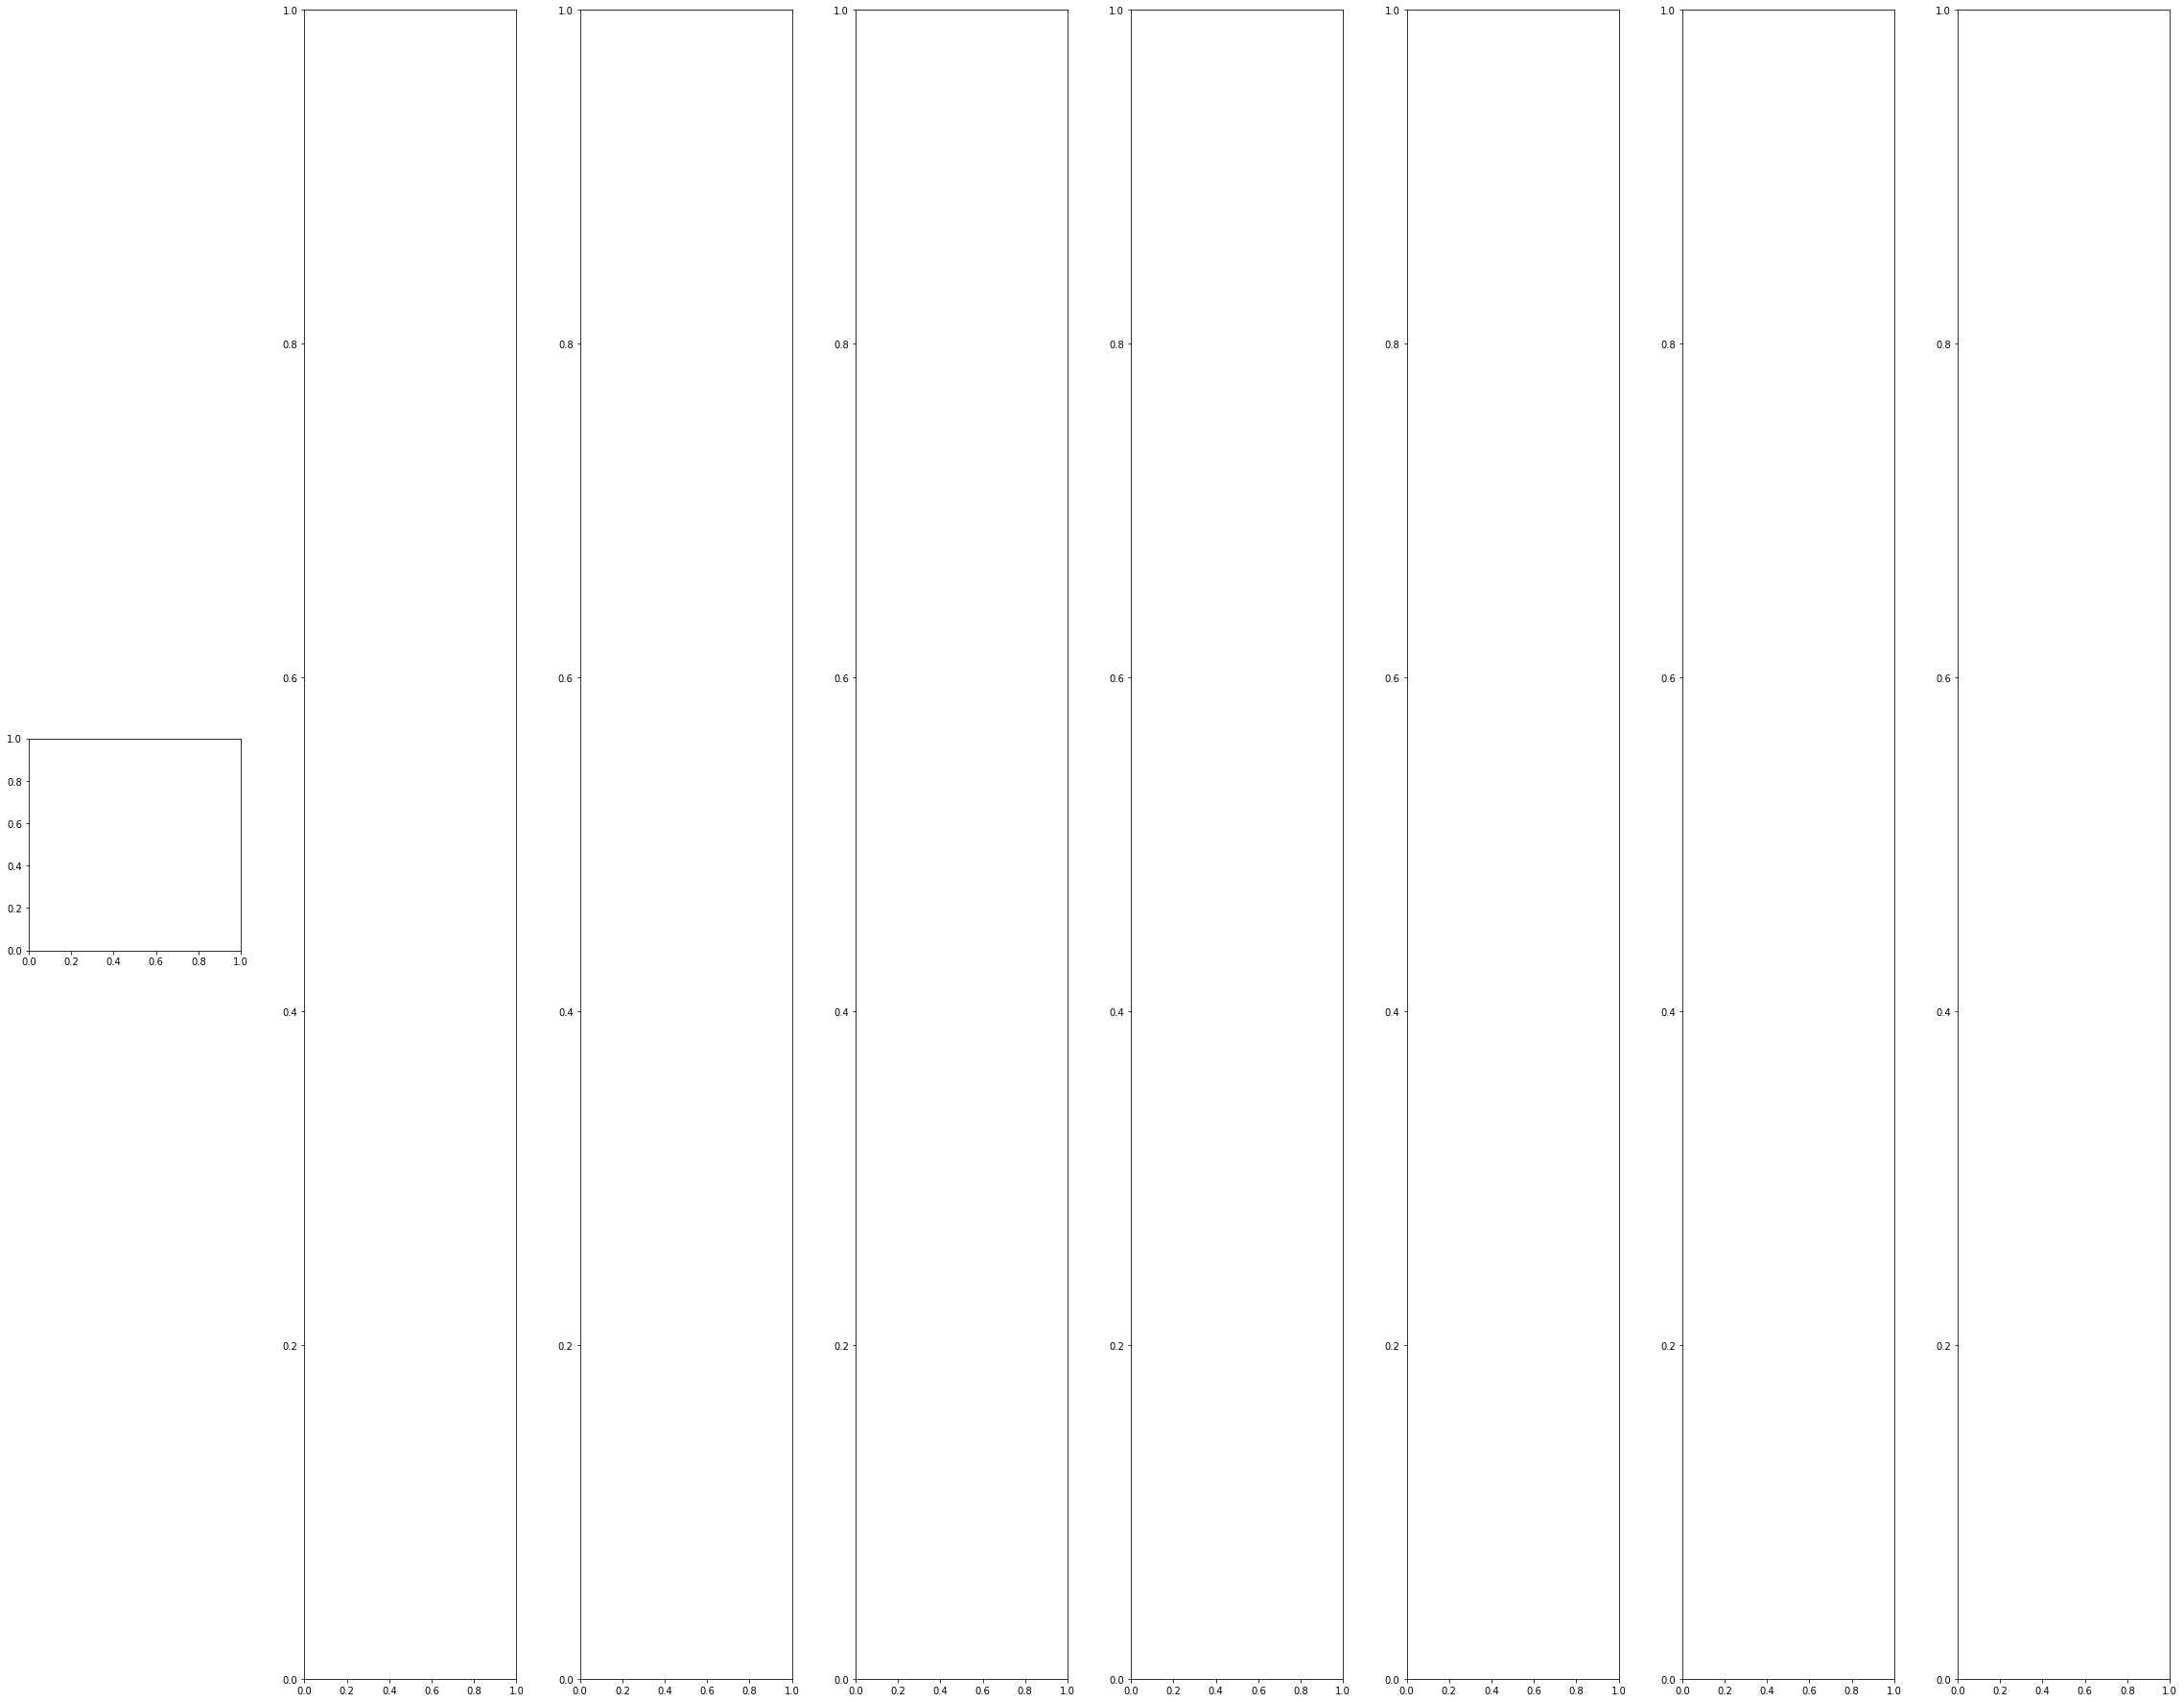

In [243]:
plot_grids(get_pred(x, num_channels), [ch_to_symbols[0]] * len(x), mask_th)

In [242]:
get_pred(x, num_channels).shape

TensorShape([8, 28, 28, 2])

In [616]:
x = model.perceive(input_train)[0]

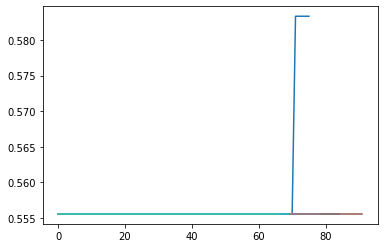

In [305]:
fig = plt.figure()
_a = accs[-10:]
for i in range(len(_a)):
    plt.plot(_a[i], label=i)
# plt.legend()

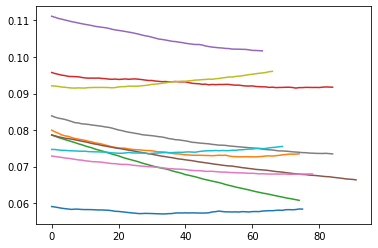

In [306]:
fig = plt.figure()
_l = losses[-10:]
for i in range(len(_l)):
    plt.plot(_l[i], label=i)
# plt.legend()

In [119]:
p = channel_to_grid(output_states[-1][-1][0,...,:2], ch_to_symbols[0], mask_th)

In [128]:
p = channel_to_grid(output_states[-1][-1][0,...,:2], ch_to_symbols[0], .4)

In [129]:
y = channel_to_grid(output_train[0], ch_to_symbols[0])

--------------------------------------------------------------------------------
114
--------------------------------------------------------------------------------


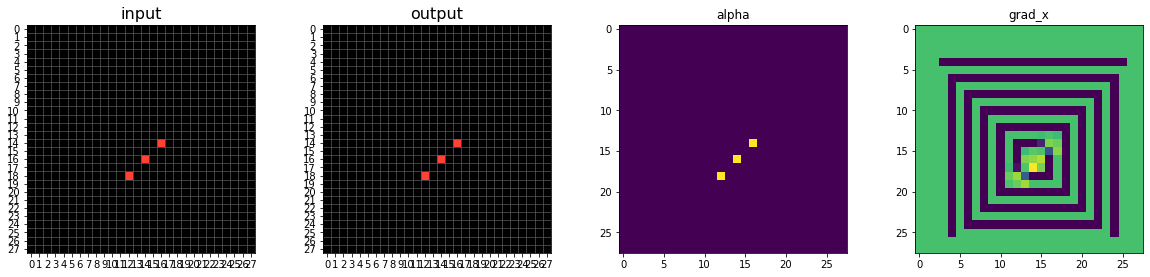

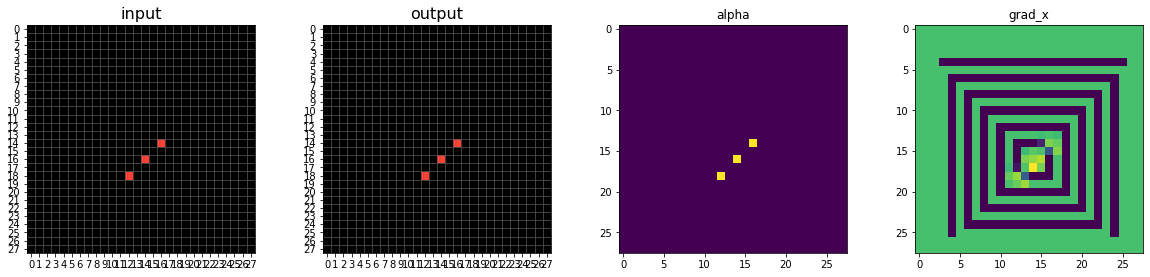

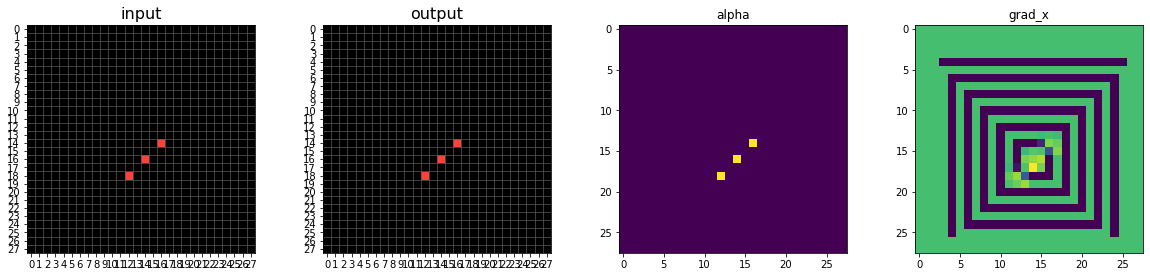

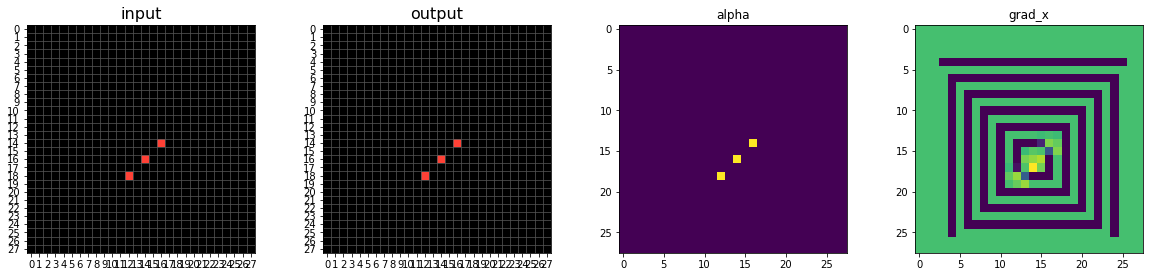

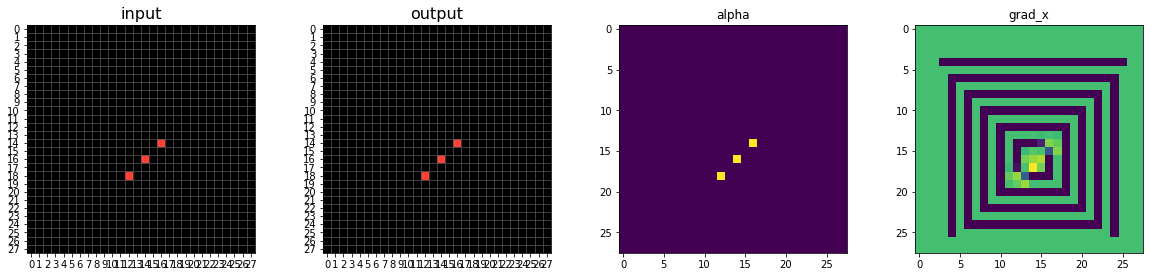

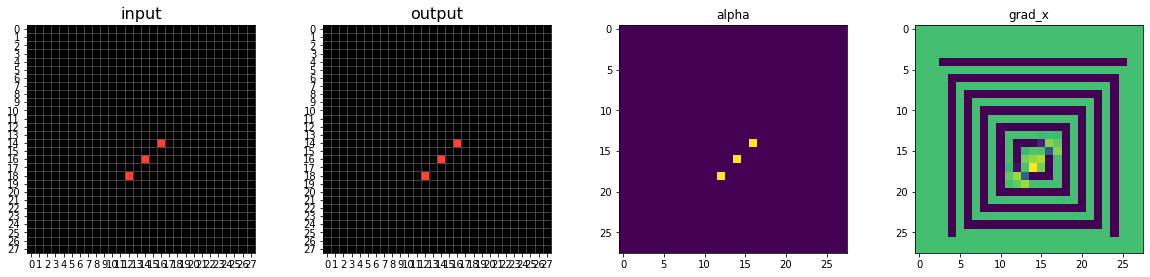

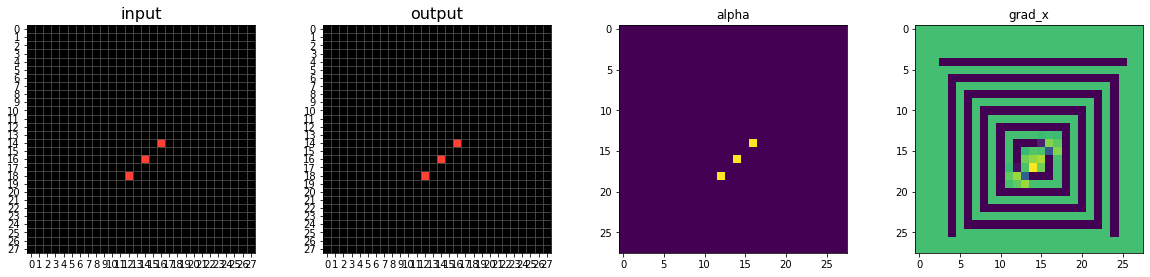

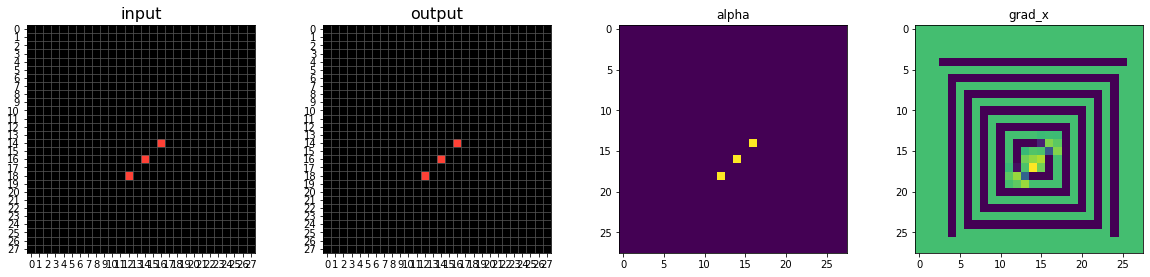

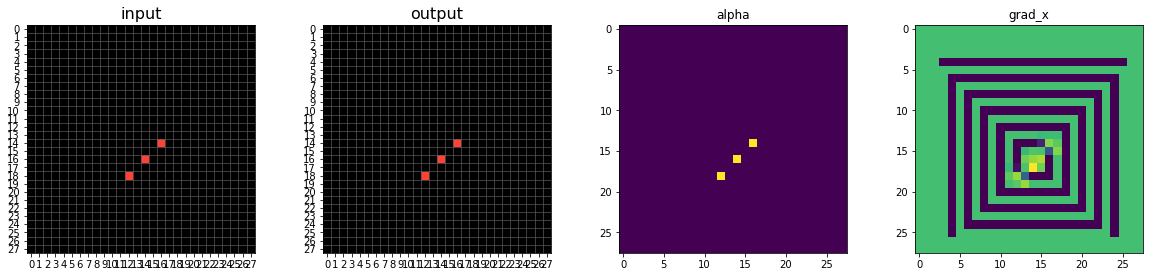

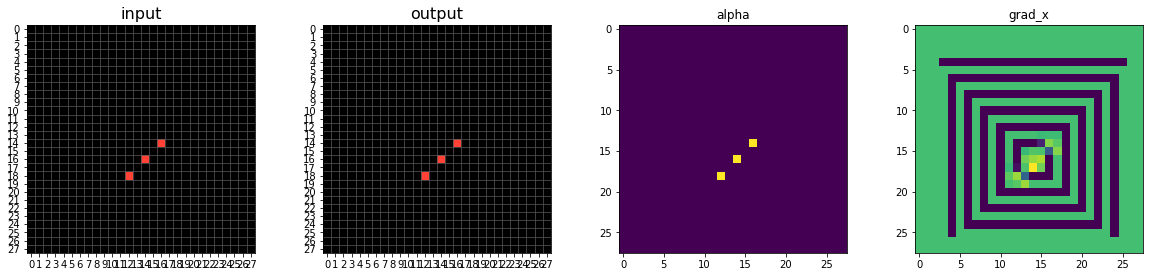

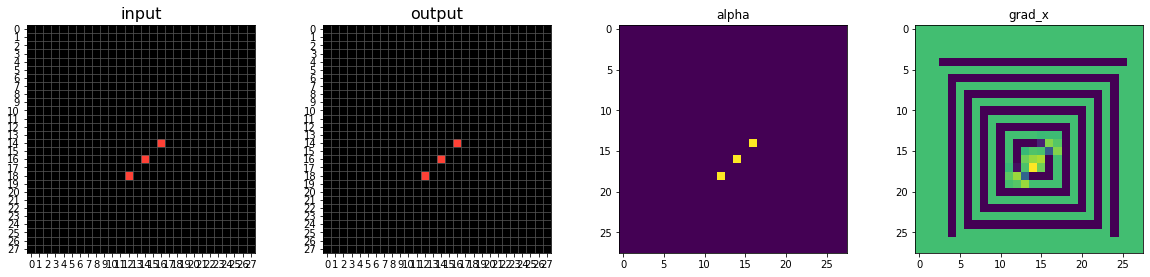

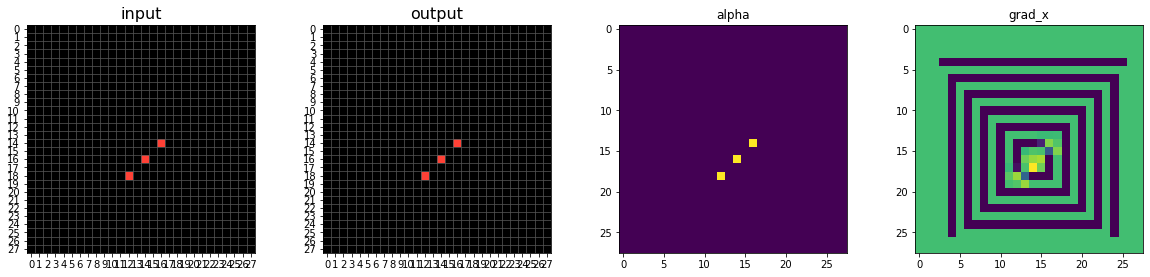

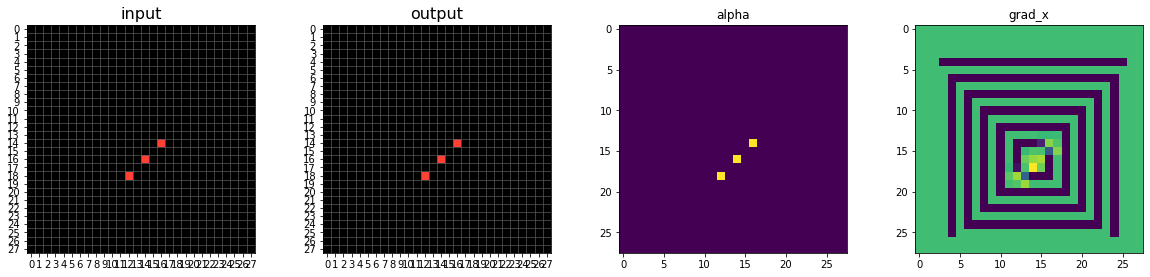

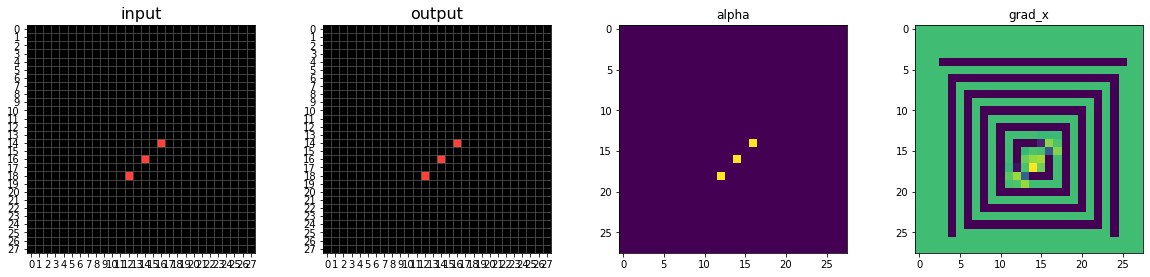

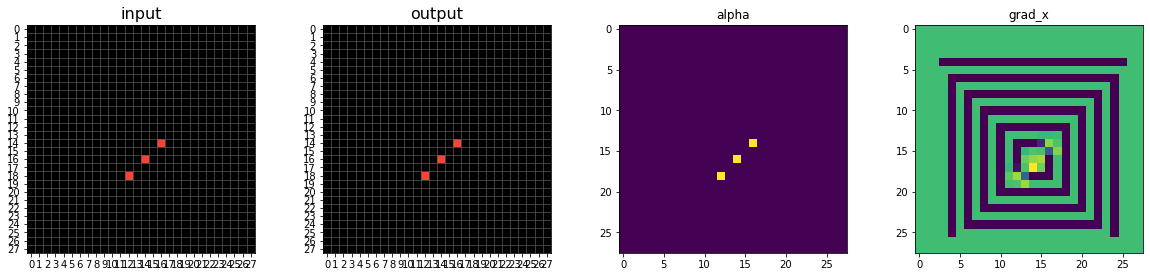

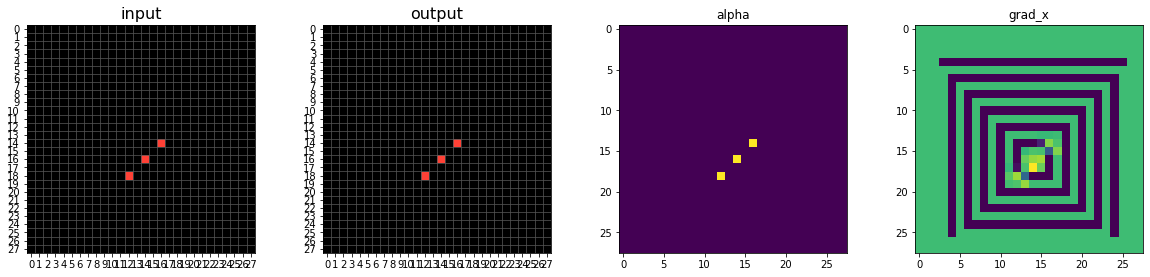

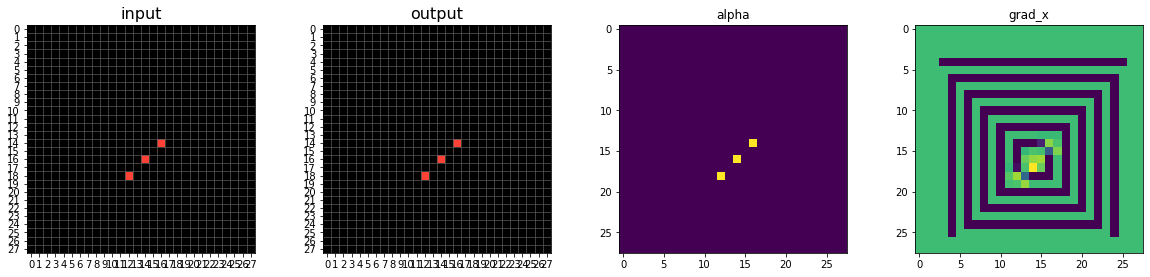

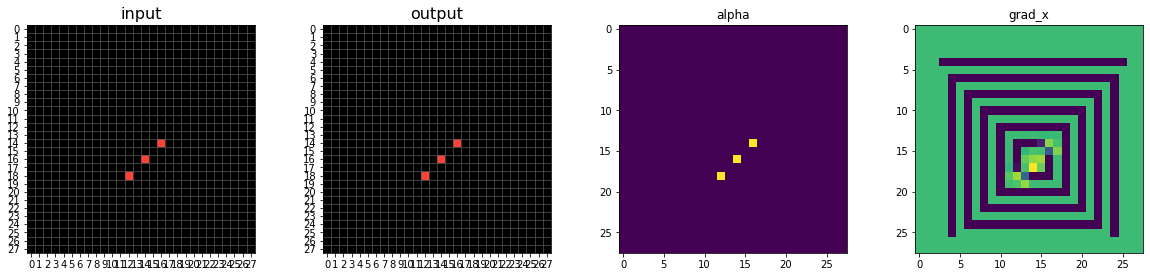

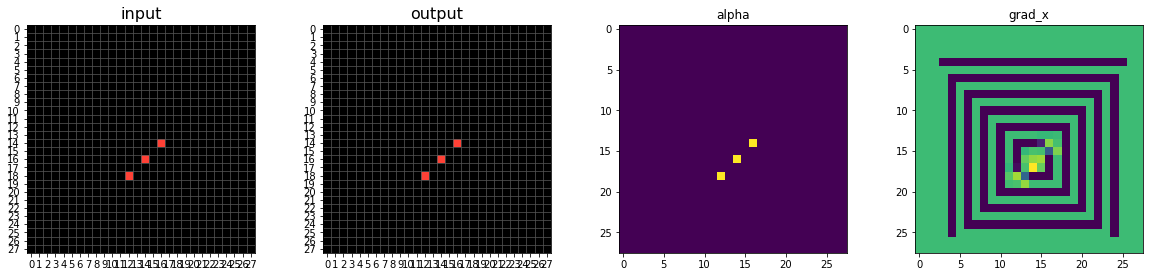

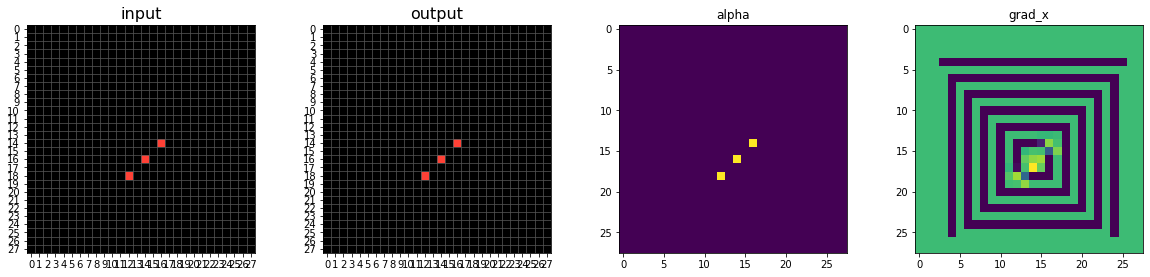

In [162]:
alive_th =  .1 #mask_th.value
idx = 0
ch_to_symbol = ch_to_symbols[idx]
last_n = 20

for step in range(steps):
    step = len(losses)-100
    step = 114
    print('-'*80)
    print(step)
    print('-'*80)
    
    ns = len(input_states[step])
    last_n = ns if last_n == -1 else last_n
    for i in range(ns-last_n, ns):
        inp = input_states[step][i][idx]
        out = output_states[step][i][idx]
        gx = grads_x[step][i][idx]
        
        fig, ax = plt.subplots(1, 4, figsize=(20,12))
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plot_grid(channel_to_grid(inp, mask_th=alive_th, ch_to_symbol=ch_to_symbol), ax[0], title='input')
        plot_grid(channel_to_grid(out, mask_th=alive_th, ch_to_symbol=ch_to_symbol), ax[1], title='output')
        
        ax[2].imshow(out[:,:,-1])
        ax[2].set_title('alpha', size=12)
        ax[3].imshow(gx.sum(axis=-1))
        ax[3].set_title('grad_x', size=12)
        plt.show()
    break

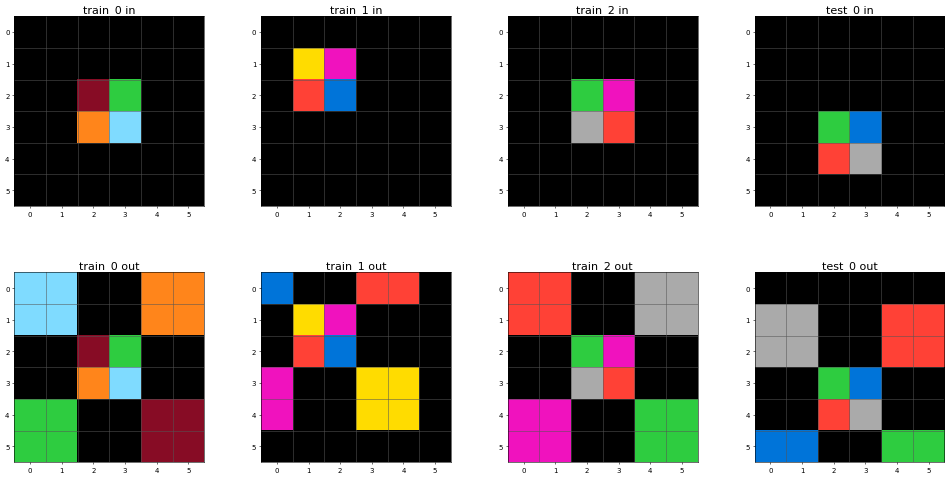

In [307]:
task.plot()

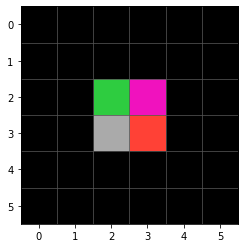

In [308]:
plot_grid(channel_to_grid(input_train[0], ch_to_symbols[0]))

In [310]:
preds = []
idx = 0
ch_to_color = task.ch_to_colors[task.num_train+idx]

x = input_test[idx].copy()[None, ...]
y = output_test[idx][None, ...]

for i in range(2000):
    x = model(x, dropout=.8, step_size=1.)
    loss = tf.reduce_mean(mean_squared_error(y, x)).numpy()
    acc = score_ca(y, x, ch_to_color, mask_th)
    print(f'step {i} - loss : {loss:.4f} - acc : {acc:.4f}')
    preds.append(x.numpy())

step 0 - loss : 0.1342 - acc : 0.6667
step 1 - loss : 0.1346 - acc : 0.6667
step 2 - loss : 0.1333 - acc : 0.6667
step 3 - loss : 0.1331 - acc : 0.6667
step 4 - loss : 0.1333 - acc : 0.6667
step 5 - loss : 0.1330 - acc : 0.6667
step 6 - loss : 0.1333 - acc : 0.6667
step 7 - loss : 0.1330 - acc : 0.6667
step 8 - loss : 0.1332 - acc : 0.6667
step 9 - loss : 0.1332 - acc : 0.6667
step 10 - loss : 0.1336 - acc : 0.6667
step 11 - loss : 0.1340 - acc : 0.6667
step 12 - loss : 0.1348 - acc : 0.6667
step 13 - loss : 0.1353 - acc : 0.6667
step 14 - loss : 0.1359 - acc : 0.6667
step 15 - loss : 0.1370 - acc : 0.6667
step 16 - loss : 0.1378 - acc : 0.6667
step 17 - loss : 0.1380 - acc : 0.6667
step 18 - loss : 0.1386 - acc : 0.6667
step 19 - loss : 0.1394 - acc : 0.6667
step 20 - loss : 0.1399 - acc : 0.6667
step 21 - loss : 0.1411 - acc : 0.6667
step 22 - loss : 0.1418 - acc : 0.6667
step 23 - loss : 0.1428 - acc : 0.6389
step 24 - loss : 0.1428 - acc : 0.6389
step 25 - loss : 0.1433 - acc : 0.6

step 229 - loss : 0.1572 - acc : 0.5833
step 230 - loss : 0.1571 - acc : 0.5833
step 231 - loss : 0.1569 - acc : 0.5833
step 232 - loss : 0.1569 - acc : 0.5833
step 233 - loss : 0.1567 - acc : 0.5833
step 234 - loss : 0.1567 - acc : 0.5833
step 235 - loss : 0.1566 - acc : 0.5833
step 236 - loss : 0.1566 - acc : 0.5833
step 237 - loss : 0.1565 - acc : 0.5833
step 238 - loss : 0.1564 - acc : 0.5833
step 239 - loss : 0.1564 - acc : 0.5833
step 240 - loss : 0.1563 - acc : 0.5833
step 241 - loss : 0.1563 - acc : 0.5833
step 242 - loss : 0.1562 - acc : 0.5833
step 243 - loss : 0.1561 - acc : 0.5833
step 244 - loss : 0.1561 - acc : 0.5833
step 245 - loss : 0.1559 - acc : 0.5833
step 246 - loss : 0.1558 - acc : 0.5833
step 247 - loss : 0.1558 - acc : 0.5833
step 248 - loss : 0.1558 - acc : 0.5833
step 249 - loss : 0.1557 - acc : 0.5833
step 250 - loss : 0.1558 - acc : 0.5833
step 251 - loss : 0.1557 - acc : 0.5833
step 252 - loss : 0.1557 - acc : 0.5833
step 253 - loss : 0.1556 - acc : 0.5833


step 448 - loss : 0.2640 - acc : 0.4167
step 449 - loss : 0.2669 - acc : 0.4444
step 450 - loss : 0.2737 - acc : 0.4444
step 451 - loss : 0.2750 - acc : 0.4444
step 452 - loss : 0.2820 - acc : 0.4444
step 453 - loss : 0.2860 - acc : 0.4444
step 454 - loss : 0.2935 - acc : 0.4444
step 455 - loss : 0.2937 - acc : 0.4444
step 456 - loss : 0.3003 - acc : 0.4444
step 457 - loss : 0.3041 - acc : 0.4444
step 458 - loss : 0.3069 - acc : 0.4444
step 459 - loss : 0.3108 - acc : 0.4444
step 460 - loss : 0.3132 - acc : 0.4444
step 461 - loss : 0.3128 - acc : 0.4444
step 462 - loss : 0.3201 - acc : 0.4444
step 463 - loss : 0.3252 - acc : 0.4444
step 464 - loss : 0.3249 - acc : 0.4444
step 465 - loss : 0.3326 - acc : 0.4444
step 466 - loss : 0.3337 - acc : 0.4444
step 467 - loss : 0.3393 - acc : 0.4444
step 468 - loss : 0.3390 - acc : 0.4444
step 469 - loss : 0.3391 - acc : 0.4444
step 470 - loss : 0.3433 - acc : 0.4444
step 471 - loss : 0.3463 - acc : 0.4444
step 472 - loss : 0.3509 - acc : 0.4444


step 658 - loss : 2.3883 - acc : 0.3333
step 659 - loss : 2.4131 - acc : 0.3333
step 660 - loss : 2.4439 - acc : 0.3333
step 661 - loss : 2.4644 - acc : 0.3611
step 662 - loss : 2.4859 - acc : 0.3611
step 663 - loss : 2.5050 - acc : 0.3611
step 664 - loss : 2.5222 - acc : 0.3611
step 665 - loss : 2.5530 - acc : 0.3611
step 666 - loss : 2.5688 - acc : 0.3611
step 667 - loss : 2.5961 - acc : 0.3611
step 668 - loss : 2.6379 - acc : 0.3611
step 669 - loss : 2.6443 - acc : 0.3611
step 670 - loss : 2.6772 - acc : 0.3611
step 671 - loss : 2.6850 - acc : 0.3611
step 672 - loss : 2.7172 - acc : 0.3611
step 673 - loss : 2.7533 - acc : 0.3611
step 674 - loss : 2.7943 - acc : 0.3611
step 675 - loss : 2.8186 - acc : 0.3611
step 676 - loss : 2.8533 - acc : 0.3611
step 677 - loss : 2.8872 - acc : 0.3611
step 678 - loss : 2.9235 - acc : 0.3611
step 679 - loss : 2.9557 - acc : 0.3611
step 680 - loss : 2.9726 - acc : 0.3611
step 681 - loss : 2.9788 - acc : 0.3611
step 682 - loss : 2.9926 - acc : 0.3611


step 946 - loss : 27.5245 - acc : 0.2500
step 947 - loss : 27.5995 - acc : 0.2500
step 948 - loss : 27.7542 - acc : 0.2500
step 949 - loss : 27.9960 - acc : 0.2500
step 950 - loss : 28.3001 - acc : 0.2500
step 951 - loss : 28.6559 - acc : 0.2500
step 952 - loss : 28.8255 - acc : 0.2500
step 953 - loss : 29.1305 - acc : 0.2222
step 954 - loss : 29.4902 - acc : 0.2222
step 955 - loss : 29.7263 - acc : 0.2222
step 956 - loss : 30.0506 - acc : 0.2222
step 957 - loss : 30.1755 - acc : 0.2222
step 958 - loss : 30.3104 - acc : 0.2222
step 959 - loss : 30.4777 - acc : 0.1944
step 960 - loss : 30.8177 - acc : 0.1944
step 961 - loss : 30.9751 - acc : 0.1944
step 962 - loss : 31.2088 - acc : 0.1944
step 963 - loss : 31.5367 - acc : 0.1944
step 964 - loss : 31.8529 - acc : 0.1944
step 965 - loss : 32.1600 - acc : 0.1944
step 966 - loss : 32.4170 - acc : 0.1944
step 967 - loss : 32.5531 - acc : 0.1944
step 968 - loss : 32.7771 - acc : 0.1944
step 969 - loss : 33.0388 - acc : 0.1944
step 970 - loss 

step 1157 - loss : 113.5600 - acc : 0.2222
step 1158 - loss : 113.9229 - acc : 0.2222
step 1159 - loss : 114.3977 - acc : 0.2222
step 1160 - loss : 115.1077 - acc : 0.2222
step 1161 - loss : 115.3247 - acc : 0.2222
step 1162 - loss : 115.4839 - acc : 0.2222
step 1163 - loss : 115.9252 - acc : 0.2222
step 1164 - loss : 116.5975 - acc : 0.2222
step 1165 - loss : 117.3170 - acc : 0.2222
step 1166 - loss : 118.0677 - acc : 0.2222
step 1167 - loss : 118.5415 - acc : 0.2222
step 1168 - loss : 118.8038 - acc : 0.1944
step 1169 - loss : 119.6152 - acc : 0.1944
step 1170 - loss : 120.1200 - acc : 0.1944
step 1171 - loss : 120.8034 - acc : 0.1944
step 1172 - loss : 121.4667 - acc : 0.1944
step 1173 - loss : 122.5249 - acc : 0.1944
step 1174 - loss : 122.9353 - acc : 0.1944
step 1175 - loss : 123.6401 - acc : 0.1944
step 1176 - loss : 124.1136 - acc : 0.1944
step 1177 - loss : 125.2546 - acc : 0.1944
step 1178 - loss : 125.9670 - acc : 0.1944
step 1179 - loss : 126.4232 - acc : 0.1944
step 1180 -

step 1443 - loss : 376.3941 - acc : 0.1667
step 1444 - loss : 377.8819 - acc : 0.1667
step 1445 - loss : 379.1413 - acc : 0.1667
step 1446 - loss : 380.1954 - acc : 0.1667
step 1447 - loss : 381.5197 - acc : 0.1667
step 1448 - loss : 382.5631 - acc : 0.1667
step 1449 - loss : 383.7307 - acc : 0.1667
step 1450 - loss : 384.9183 - acc : 0.1667
step 1451 - loss : 385.4040 - acc : 0.1667
step 1452 - loss : 386.3440 - acc : 0.1667
step 1453 - loss : 388.0845 - acc : 0.1667
step 1454 - loss : 388.6906 - acc : 0.1667
step 1455 - loss : 389.9894 - acc : 0.1667
step 1456 - loss : 390.9517 - acc : 0.1667
step 1457 - loss : 391.3532 - acc : 0.1667
step 1458 - loss : 392.9468 - acc : 0.1667
step 1459 - loss : 394.2371 - acc : 0.1667
step 1460 - loss : 396.2034 - acc : 0.1667
step 1461 - loss : 397.2855 - acc : 0.1667
step 1462 - loss : 398.7358 - acc : 0.1667
step 1463 - loss : 400.0702 - acc : 0.1667
step 1464 - loss : 401.8868 - acc : 0.1667
step 1465 - loss : 403.2894 - acc : 0.1667
step 1466 -

step 1688 - loss : 707.2684 - acc : 0.1389
step 1689 - loss : 708.6423 - acc : 0.1389
step 1690 - loss : 710.5737 - acc : 0.1389
step 1691 - loss : 711.1423 - acc : 0.1389
step 1692 - loss : 712.6978 - acc : 0.1389
step 1693 - loss : 714.5751 - acc : 0.1389
step 1694 - loss : 715.5651 - acc : 0.1389
step 1695 - loss : 716.7798 - acc : 0.1389
step 1696 - loss : 718.4741 - acc : 0.1389
step 1697 - loss : 720.0941 - acc : 0.1389
step 1698 - loss : 721.1745 - acc : 0.1389
step 1699 - loss : 722.1802 - acc : 0.1389
step 1700 - loss : 724.2849 - acc : 0.1389
step 1701 - loss : 726.6988 - acc : 0.1389
step 1702 - loss : 727.6821 - acc : 0.1389
step 1703 - loss : 729.2334 - acc : 0.1389
step 1704 - loss : 730.0545 - acc : 0.1389
step 1705 - loss : 731.7843 - acc : 0.1389
step 1706 - loss : 733.1038 - acc : 0.1389
step 1707 - loss : 734.6227 - acc : 0.1389
step 1708 - loss : 736.5937 - acc : 0.1389
step 1709 - loss : 738.2979 - acc : 0.1389
step 1710 - loss : 738.8984 - acc : 0.1389
step 1711 -

step 1891 - loss : 1011.7213 - acc : 0.2222
step 1892 - loss : 1014.6382 - acc : 0.2222
step 1893 - loss : 1015.9842 - acc : 0.2222
step 1894 - loss : 1016.6577 - acc : 0.2222
step 1895 - loss : 1018.7259 - acc : 0.2222
step 1896 - loss : 1019.6484 - acc : 0.2222
step 1897 - loss : 1020.5240 - acc : 0.2222
step 1898 - loss : 1021.9852 - acc : 0.2222
step 1899 - loss : 1023.3460 - acc : 0.2222
step 1900 - loss : 1023.9256 - acc : 0.2222
step 1901 - loss : 1024.8651 - acc : 0.2222
step 1902 - loss : 1027.3068 - acc : 0.2222
step 1903 - loss : 1029.1346 - acc : 0.2222
step 1904 - loss : 1030.8151 - acc : 0.2222
step 1905 - loss : 1032.2045 - acc : 0.2222
step 1906 - loss : 1034.6497 - acc : 0.2222
step 1907 - loss : 1036.3213 - acc : 0.2222
step 1908 - loss : 1038.2616 - acc : 0.2222
step 1909 - loss : 1039.7958 - acc : 0.2222
step 1910 - loss : 1041.1770 - acc : 0.2222
step 1911 - loss : 1043.3076 - acc : 0.2222
step 1912 - loss : 1045.0334 - acc : 0.2222
step 1913 - loss : 1045.7751 - a

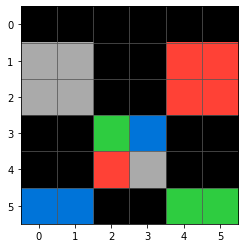

In [349]:
y_padded = unpad(y, task.output_shapes[-1])
y_test = channel_to_grid(y_padded[0], ch_to_symbols[-1])
plot_grid(y_test)

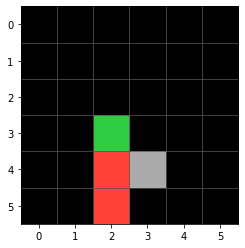

In [353]:
p_idx = 30
pred_padded = unpad(preds[p_idx], task.output_shapes[-1])
y_pred = channel_to_grid(pred_padded[0], ch_to_symbols[-1], mask_th)
plot_grid(y_pred)

In [1815]:
def visualize_batch_2(x0, x, step_i):
    vis0 = np.hstack(channel_to_grid(x0))
    vis1 = np.hstack(channel_to_grid(x.numpy()))
    vis = np.vstack([vis0, vis1])
    plt.imshow(vis)

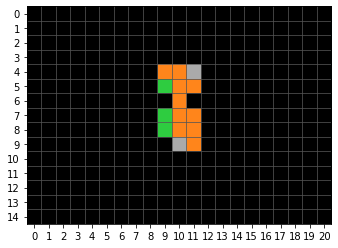

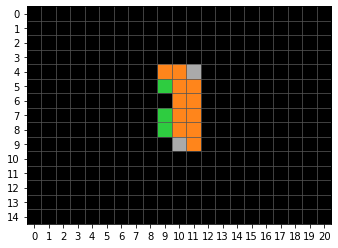

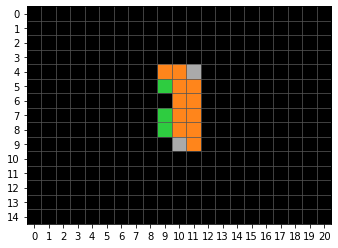

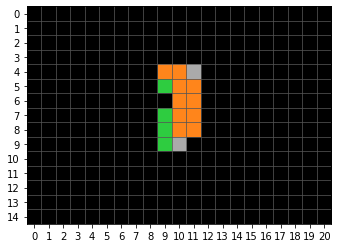

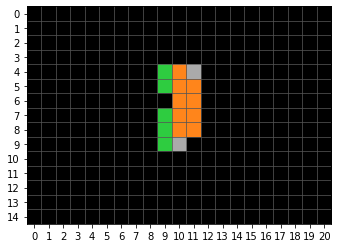

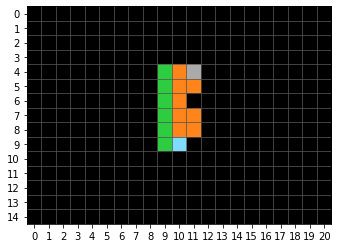

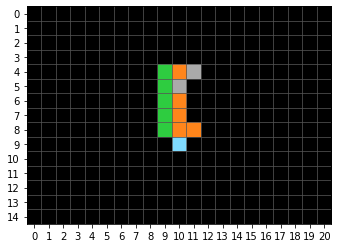

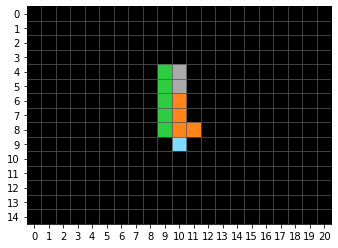

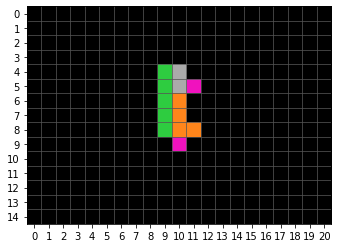

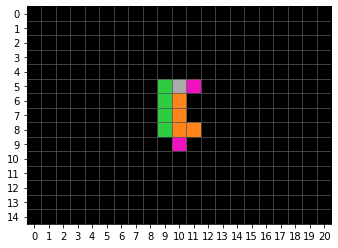

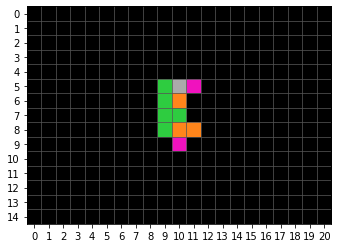

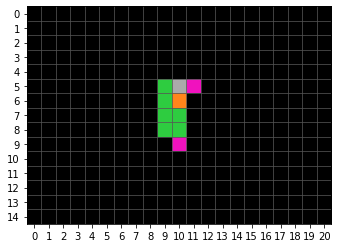

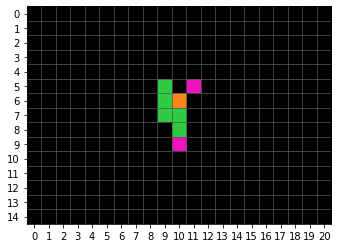

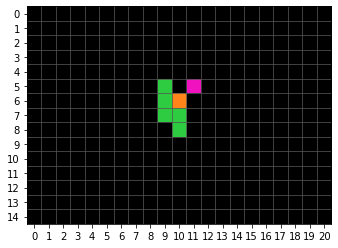

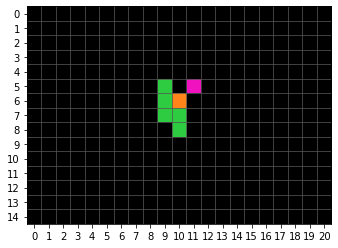

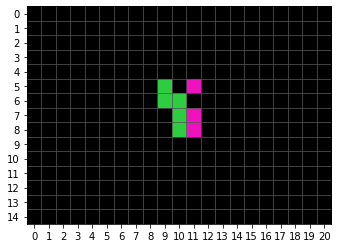

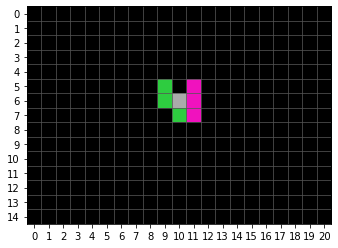

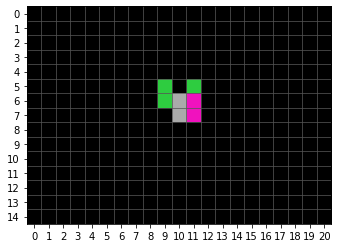

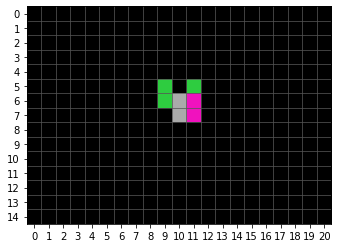

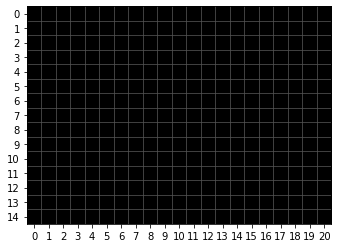

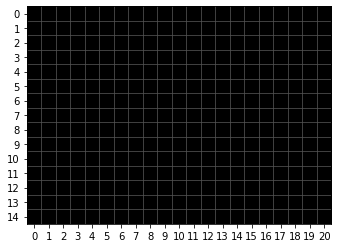

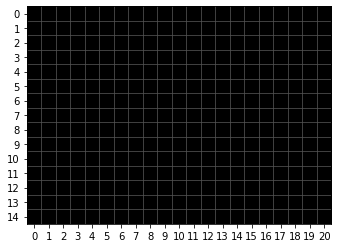

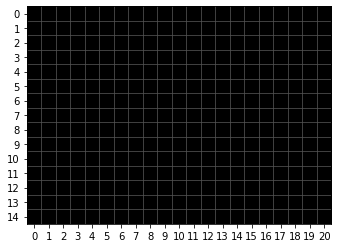

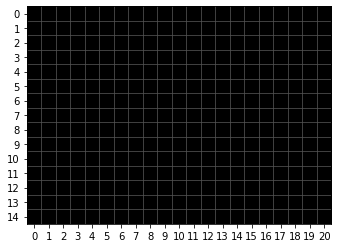

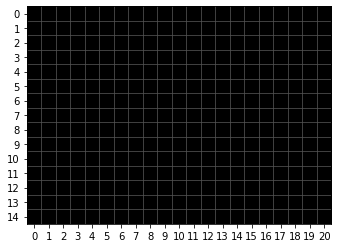

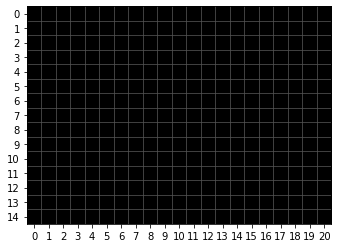

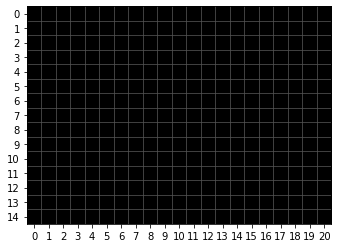

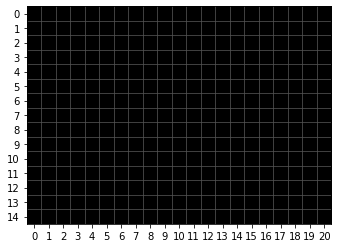

KeyboardInterrupt: 

In [2771]:
for i in range(100):
    p = model(p)
    plot_grid(channel_to_grid(p[0,:,:,:], th=.01))
    plt.show()